<a href="https://colab.research.google.com/github/vaas-umputer/edge-cloud-workflow-scheduler/blob/main/UNCERTAINTY_AWARE_SCHEDULER_TEAM41.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torch_geometric stable-baselines3 gym numpy shimmy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18

In [3]:
# ContrastiveGAT: GNN for task embeddings in edge-cloud scheduling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.data import Data
import json
import networkx as nx
import numpy as np
from rich.console import Console
import os

class ContrastiveGAT(nn.Module):
    def __init__(self, in_channels=9, hidden_channels=16, embedding_dim=32, heads=4):
        super().__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=0.2, add_self_loops=False)
        self.gat2 = GATConv(hidden_channels * heads, hidden_channels, heads=heads, dropout=0.2, add_self_loops=False)
        self.node_to_embed = nn.Linear(hidden_channels * heads, embedding_dim)
        self.edge_proj = nn.Linear(1, hidden_channels)
        self.graph_fc = nn.Linear(hidden_channels * heads, embedding_dim)

    def forward(self, x, edge_index, edge_attr, batch):
        # Generate task and graph embeddings with shape annotations
        # Inputs:
        #   x: Node features, shape [num_nodes, in_channels=9]
        #   edge_index: Edge indices, shape [2, num_edges]
        #   edge_attr: Edge attributes, shape [num_edges, 1]
        #   batch: Batch vector, shape [num_nodes]
        # Outputs:
        #   task_embeddings: [num_nodes, embedding_dim=32]
        #   graph_embedding: [num_graphs, embedding_dim=32]

        # Handle NaNs: [num_nodes, 9]
        x = torch.nan_to_num(x, nan=0.0, posinf=1.0, neginf=-1.0)

        # Default edge weights if None: [num_edges, 1]
        edge_attr = torch.ones((edge_index.shape[1], 1), device=x.device) * 0.1 if edge_attr is None else edge_attr
        edge_attr = torch.nan_to_num(edge_attr, nan=0.1)

        # Project edge weights: [num_edges, 1] -> [num_edges, hidden_channels=16]
        edge_attr = self.edge_proj(edge_attr)

        # First GAT: [num_nodes, 9] -> [num_nodes, hidden_channels*heads=16*4=64]
        x = F.relu(self.gat1(x, edge_index, edge_attr=edge_attr))

        # Dropout: [num_nodes, 64] (no shape change, for MC Dropout)
        x = F.dropout(x, p=0.2, training=True)

        # Second GAT: [num_nodes, 64] -> [num_nodes, 16*4=64]
        x = F.relu(self.gat2(x, edge_index, edge_attr=edge_attr))

        # Task embeddings: [num_nodes, 64] -> [num_nodes, embedding_dim=32]
        task_embeddings = self.node_to_embed(x)

        # Pool nodes: [num_nodes, 64] -> [num_graphs, 64]
        graph_embedding = global_mean_pool(x, batch)

        # Graph embedding: [num_graphs, 64] -> [num_graphs, embedding_dim=32]
        graph_embedding = self.graph_fc(graph_embedding)

        return task_embeddings, graph_embedding

    def contrastive_loss(self, embeddings, edge_index, num_nodes):
        # Contrastive loss: Aligns embeddings for connected tasks
        embeddings = torch.nan_to_num(embeddings, nan=0.0)
        if edge_index.shape[1] == 0:
            return torch.tensor(0.0, device=embeddings.device, requires_grad=True)
        pos_pairs = embeddings[edge_index[0]] - embeddings[edge_index[1]]
        pos_loss = (pos_pairs ** 2).sum(dim=1).mean()
        num_neg = min(int(num_nodes * 0.1), 500)
        neg_idx1 = torch.randint(0, num_nodes, (num_neg,), device=embeddings.device)
        neg_idx2 = torch.randint(0, num_nodes, (num_neg,), device=embeddings.device)
        mask = neg_idx1 != neg_idx2
        neg_idx1, neg_idx2 = neg_idx1[mask], neg_idx2[mask]
        if len(neg_idx1) == 0:
            return pos_loss
        neg_pairs = embeddings[neg_idx1] - embeddings[neg_idx2]
        neg_loss = F.relu(1.0 - (neg_pairs ** 2).sum(dim=1)).mean()
        return pos_loss + 0.5 * neg_loss

In [4]:
# GNNTrainer: Trains ContrastiveGAT and generates task embeddings for edge-cloud scheduling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.data import Data
import json
import networkx as nx
import numpy as np
from rich.console import Console
import os

class GNNTrainer:
    def __init__(self, dag_file, embeddings_file, model_file="gnn_model.pth", max_nodes=1000, embedding_dim=32):
        # Initialize trainer for GNN model
        self.dag_file = dag_file
        self.embeddings_file = embeddings_file
        self.model_file = model_file
        self.max_nodes = max_nodes
        self.embedding_dim = embedding_dim
        self.console = Console()
        self.dag = self.load_dag()  # Load DAG
        self.model = ContrastiveGAT(embedding_dim=self.embedding_dim)  # Initialize ContrastiveGAT

    def load_dag(self):
        # Load DAG from JSON, cap at max_nodes
        # Returns: NetworkX DAG
        if not os.path.exists(self.dag_file):
            self.console.log(f"Error: DAG file {self.dag_file} not found")
            raise FileNotFoundError(f"DAG file {self.dag_file} not found")
        with open(self.dag_file, "r") as f:
            dag_json = json.load(f)
        dag = nx.node_link_graph(dag_json, edges="links")
        if len(dag.nodes) > self.max_nodes:
            nodes = list(dag.nodes)[:self.max_nodes]
            dag = dag.subgraph(nodes).copy()
        return dag

    def load_model(self, path):
        # Load pre-trained model weights
        self.model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
        self.model.eval()

    def prepare_data(self):
        # Prepare DAG as PyTorch Geometric Data
        # Returns: Data object with shapes:
        #   x: [num_nodes, 9] (node features)
        #   edge_index: [2, num_edges]
        #   edge_attr: [num_edges, 1] (T_comm)
        #   batch: [num_nodes] (graph assignments)
        if not self.dag.nodes:
            x = torch.tensor([[0.5] * 9], dtype=torch.float)  # [1, 9]
            edge_index = torch.tensor([[], []], dtype=torch.long)  # [2, 0]
            edge_attr = torch.tensor([[0.1]], dtype=torch.float)  # [1, 1]
            batch = torch.zeros(1, dtype=torch.long)  # [1]
            return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, batch=batch)
        node_to_idx = {nid: i for i, nid in enumerate(self.dag.nodes)}
        feature_keys = ["execution_time", "cpu_usage", "memory_usage", "arrival_time", "power_usage", "monetary_cost", "energy_cost"]
        x = [[float(self.dag.nodes[n].get(k, 0.5)) for k in feature_keys] +
             ([1.0, 0.0] if self.dag.nodes[n].get("machine_type", "cloud") == "edge" else [0.0, 1.0])
             for n in self.dag.nodes]  # Raw: [num_nodes, 9]
        x = torch.tensor(x, dtype=torch.float)  # [num_nodes, 9]
        x = torch.nan_to_num(x, nan=0.5, posinf=1.0, neginf=0.0)  # Handle NaNs: [num_nodes, 9]
        mean = x.mean(dim=0)  # [9]
        std = torch.where(x.std(dim=0) > 0, x.std(dim=0), torch.ones_like(x.std(dim=0)))  # [9]
        x = (x - mean) / std  # Normalize: [num_nodes, 9] z-score normalization
        edge_index = torch.tensor([[node_to_idx[e[0]], node_to_idx[e[1]]] for e in self.dag.edges], dtype=torch.long).t() if self.dag.edges else torch.tensor([[], []], dtype=torch.long)  # [2, num_edges]
        edge_attr = torch.tensor([[self.dag.edges[e].get("T_comm", 0.1)] for e in self.dag.edges], dtype=torch.float) if self.dag.edges else torch.tensor([[0.1]], dtype=torch.float)  # [num_edges, 1]
        edge_attr = torch.nan_to_num(edge_attr, nan=0.1)  # [num_edges, 1]
        batch = torch.zeros(len(self.dag.nodes), dtype=torch.long)  # [num_nodes]
        return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, batch=batch)

    def get_mc_embeddings(self, model, data, num_samples=30):
        # Generate Monte Carlo embeddings for tasks
        # Inputs:
        #   data.x: [num_nodes, 9]
        #   data.edge_index: [2, num_edges]
        #   data.edge_attr: [num_edges, 1]
        #   data.batch: [num_nodes]
        # Returns:
        #   task_mean: [num_nodes, embedding_dim=32]
        #   task_var: [num_nodes, embedding_dim=32]
        model.eval()
        task_embed_samples = []
        for _ in range(num_samples):
            with torch.no_grad():
                task_embeds, _ = model(data.x, data.edge_index, data.edge_attr, data.batch)  # [num_nodes, 32]
                task_embed_samples.append(task_embeds.unsqueeze(0))  # [1, num_nodes, 32]
        task_embed_samples = torch.cat(task_embed_samples, dim=0)  # [num_samples, num_nodes, 32]
        task_mean = task_embed_samples.mean(dim=0)  # [num_nodes, 32]
        task_var = task_embed_samples.var(dim=0)  # [num_nodes, 32]
        return task_mean, task_var

    def compute_metrics(self, embeddings, edge_index, task_ids):
        # Compute embedding quality metrics (pos_sim, neg_sim, emb_var)
        embeddings = embeddings.detach().cpu()  # [num_nodes, embedding_dim=32]
        embeddings = torch.nan_to_num(embeddings, nan=0.0, posinf=1.0, neginf=-1.0)  # [num_nodes, 32]
        embeddings_np = embeddings.numpy()  # [num_nodes, 32]
        pos_sim = neg_sim = emb_var = 0.0
        if edge_index.shape[1] > 0:
            pos_sim = np.mean([
                np.dot(embeddings_np[i], embeddings_np[j]) / (max(np.linalg.norm(embeddings_np[i]), 1e-8) * max(np.linalg.norm(embeddings_np[j]), 1e-8))
                for i, j in zip(edge_index[0].cpu().numpy(), edge_index[1].cpu().numpy())
            ])
        n_samples = min(100, len(task_ids))
        idx1, idx2 = np.random.choice(len(task_ids), (2, n_samples), replace=True)
        mask = idx1 != idx2
        idx1, idx2 = idx1[mask], idx2[mask]
        if len(idx1) > 0:
            neg_sim = np.mean([
                np.dot(embeddings_np[i], embeddings_np[j]) / (max(np.linalg.norm(embeddings_np[i]), 1e-8) * max(np.linalg.norm(embeddings_np[j]), 1e-8))
                for i, j in zip(idx1, idx2)
            ])
        emb_var = np.var(embeddings_np, axis=0).mean() if embeddings_np.size > 0 else 0.0
        return {"pos_sim": pos_sim, "neg_sim": neg_sim, "emb_var": emb_var}

    def save_embeddings(self, data, device):
        # Save task embeddings without training
        # Input: data.x: [num_nodes, 9], data.edge_index: [2, num_edges], etc.
        # Output: Saves dict to embeddings_file
        self.model.eval()
        data = data.to(device)
        with torch.no_grad():
            task_mean, task_var = self.get_mc_embeddings(self.model, data)  # [num_nodes, 32], [num_nodes, 32]
            task_mean = torch.nan_to_num(task_mean, nan=0.0)  # [num_nodes, 32]
            task_var = torch.nan_to_num(task_var, nan=0.0)  # [num_nodes, 32]
            task_embeddings_dict = {
                nid: {"mean": mean.tolist(), "uncertainty": var.tolist()}
                for nid, mean, var in zip(self.dag.nodes, task_mean, task_var)
            }
            torch.save({"task_embeddings": task_embeddings_dict}, self.embeddings_file)
            self.console.log(f"Saved embeddings to {self.embeddings_file}")

    def train(self, epochs=10):
        # Train GNN model and save embeddings
        # Input: epochs (default 10)
        # Output: Saves model to model_file, embeddings to embeddings_file
        self.console.log(f"Training GNN with embedding_dim={self.embedding_dim}...")
        device = "cuda" if torch.cuda.is_available() else "cpu"
        self.console.log(f"Using device: {device}")
        self.model = self.model.to(device)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
        data = self.prepare_data().to(device)  # x: [num_nodes, 9], etc.
        if data.x.shape[0] == 0 or data.edge_index.shape[1] == 0:
            self.console.log("Empty graph, skipping training")
            return
        for epoch in range(1, epochs + 1):
            self.model.train()
            optimizer.zero_grad()
            task_embeddings, _ = self.model(data.x, data.edge_index, data.edge_attr, data.batch)  # [num_nodes, 32]
            loss = self.model.contrastive_loss(task_embeddings, data.edge_index, len(data.x))  # Scalar
            if torch.isnan(loss) or torch.isinf(loss):
                self.console.log(f"Epoch {epoch}: Invalid loss ({loss.item()}), skipping")
                continue
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            optimizer.step()
            if epoch % 2 == 0:
                metrics = self.compute_metrics(task_embeddings, data.edge_index, list(self.dag.nodes))
                self.console.log(
                    f"Epoch {epoch}/{epochs}: Loss={loss.item():.4f}, "
                    f"Pos Sim={metrics['pos_sim']:.4f}, Neg Sim={metrics['neg_sim']:.4f}, "
                    f"Emb Var={metrics['emb_var']:.4f}"
                )
        self.model.eval()
        with torch.no_grad():
            task_mean, task_var = self.get_mc_embeddings(self.model, data)  # [num_nodes, 32], [num_nodes, 32]
            task_mean = torch.nan_to_num(task_mean, nan=0.0)  # [num_nodes, 32]
            task_var = torch.nan_to_num(task_var, nan=0.0)  # [num_nodes, 32]
            task_embeddings_dict = {
                nid: {"mean": mean.tolist(), "uncertainty": var.tolist()}
                for nid, mean, var in zip(self.dag.nodes, task_mean, task_var)
            }
            torch.save({"task_embeddings": task_embeddings_dict}, self.embeddings_file)
            self.console.log(f"Saved embeddings and uncertainties to {self.embeddings_file}")
            torch.save(self.model.state_dict(), self.model_file)
            self.console.log(f"Saved GNN model to {self.model_file}")
            metrics = self.compute_metrics(task_mean, data.edge_index, list(self.dag.nodes))
            self.console.log(
                f"Final Metrics: Pos Sim={metrics['pos_sim']:.4f}, Neg Sim={metrics['neg_sim']:.4f}, "
                f"Emb Var={metrics['emb_var']:.4f}"
            )

In [5]:
import torch
import numpy as np
import gymnasium as gym
from gymnasium import Env, spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from rich.console import Console
import json
import networkx as nx
import os
import seaborn as sns
import matplotlib.pyplot as plt
from rich.table import Table

# TaskQueue: Simulates task execution for edge-cloud scheduling
class TaskQueue:
    def __init__(self, dag, embeddings, task_ids, num_servers=5):
        # Initialize task queue with DAG and embeddings
        # Inputs:
        #   dag: NetworkX DAG
        #   embeddings: [num_nodes, embedding_dim=32]
        #   task_ids: List of task IDs [num_nodes]
        #   num_servers: Number of servers per placement (default 5)
        self.dag = dag
        self.task_ids = task_ids
        self.tasks = {
            node: {
                "embedding": embeddings[i] if i < len(embeddings) else np.zeros(embeddings.shape[1]),  # [32]
                "dependencies": set(dag.predecessors(node)),  # Set of task IDs
                "exec_time": dag.nodes[node].get("execution_time", 1.0),  # Scalar
                "arrival_time": dag.nodes[node].get("arrival_time", 0.0),  # Scalar
                "monetary_cost": dag.nodes[node].get("monetary_cost", 1.0),  # Scalar
                "energy_cost": dag.nodes[node].get("energy_cost", 1.0),  # Scalar
                "placement": None,  # String or None
                "server": None,  # Int or None
                "history": []  # List of dicts
            } for i, node in enumerate(task_ids)  # Dict: [num_nodes] keys
        }
        self.completed = set()  # Set of task IDs
        self.running = {}  # Dict: task_id -> dict
        self.server_loads = {"cloud": np.zeros(num_servers), "edge": np.zeros(num_servers)}  # Dict: [num_servers]
        self.edge_battery = np.full(num_servers, 100.0)  # [num_servers]
        self.network_latency = 0.5  # Scalar
        self.current_time = 0.0  # Scalar
        self.total_cost = 0.0  # Scalar
        self.total_energy = 0.0  # Scalar
        self.console = Console()
        self.cloud_base_power = np.random.uniform(10, 15, num_servers)  # [num_servers]
        self.edge_base_power = np.random.uniform(2, 5, num_servers)  # [num_servers]
        self.load_history = {"cloud": [], "edge": []}  # Dict: Lists of [num_servers]
        self.placement_log = {}  # Dict: task_id -> dict
        self.overload_feedback = {"cloud": False, "edge": False}  # Dict: Booleans

    def reset(self):
        # Reset queue state
        self.completed = set()  # Empty set
        self.running = {}  # Empty dict
        self.server_loads = {"cloud": np.zeros(len(self.server_loads["cloud"])), "edge": np.zeros(len(self.server_loads["edge"]))}  # [num_servers]
        self.edge_battery = np.full(len(self.server_loads["edge"]), 100.0)  # [num_servers]
        self.network_latency = 0.5  # Scalar
        self.current_time = 0.0  # Scalar
        self.total_cost = 0.0  # Scalar
        self.total_energy = 0.0  # Scalar
        self.load_history = {"cloud": [], "edge": []}  # Empty lists
        self.placement_log = {}  # Empty dict
        for task in self.tasks.values():
            task["placement"] = None  # None
            task["server"] = None  # None
            task["history"] = []  # Empty list

    def update_conditions(self):
        # Update server and network conditions
        self.network_latency = np.random.uniform(0.3, 0.7)  # Scalar
        self.server_loads["cloud"] += np.random.uniform(0, 0.2, len(self.server_loads["cloud"]))  # [num_servers]
        self.server_loads["edge"] += np.random.uniform(0, 0.1, len(self.server_loads["edge"]))  # [num_servers]
        self.server_loads["cloud"] = np.clip(self.server_loads["cloud"], 0, 2.0)  # [num_servers]
        self.server_loads["edge"] = np.clip(self.server_loads["edge"], 0, 1.5)  # [num_servers]
        self.edge_battery += 0.5  # [num_servers]
        self.edge_battery = np.clip(self.edge_battery, 0, 100)  # [num_servers]
        self.load_history["cloud"].append(self.server_loads["cloud"].copy())  # List append: [num_servers]
        self.load_history["edge"].append(self.server_loads["edge"].copy())  # List append: [num_servers]
        if len(self.load_history["cloud"]) > 10:
            self.load_history["cloud"].pop(0)  # Remove oldest
            self.load_history["edge"].pop(0)  # Remove oldest
        self.overload_feedback["cloud"] = np.any(self.server_loads["cloud"] > 2.0)  # Boolean
        self.overload_feedback["edge"] = np.any(self.server_loads["edge"] > 1.5) or np.any(self.edge_battery < 20)  # Boolean

    def get_ready_tasks(self):
        # Get tasks ready to execute
        # Returns: List of task IDs
        ready = [tid for tid, t in self.tasks.items() if
                 tid not in self.running and tid not in self.completed and
                 t["arrival_time"] <= self.current_time and
                 t["dependencies"].issubset(self.completed)]
        if not ready and self.running:
            stuck_tasks = [tid for tid in self.running if self.current_time - self.running[tid]["expected_end"] > 10.0]
            if stuck_tasks:
                self.console.log(f"Stuck tasks detected: {stuck_tasks[:5]}")
            self.console.log(f"Waiting for running tasks: {list(self.running.keys())[:5]}")
        return ready

    def update_running(self):
        # Update running tasks, complete finished ones
        completed = [t for t, info in self.running.items() if self.current_time >= info["expected_end"]]
        for task in completed:
            self.complete_task(task)
        self.edge_battery = np.minimum(self.edge_battery + 0.5, 100.0)  # [num_servers]
        if not completed and self.running:
            self.current_time += 0.5  # Scalar
            if hasattr(self, 'active_phase') and self.active_phase:
                self.console.log(f"Advancing time to {self.current_time:.2f} due to running tasks")

    def clear_running(self):
        # Clear all running tasks
        for task in list(self.running.keys()):
            self.complete_task(task)
        self.running.clear()  # Empty dict
        self.current_time = max(self.current_time, 0.0)  # Scalar

    def start_task(self, task_id, placement, server, exec_time):
        # Start a task on a server
        # Inputs:
        #   task_id: Task ID
        #   placement: "cloud" or "edge"
        #   server: Server index
        #   exec_time: Execution time (scalar)
        if task_id not in self.tasks:
            self.console.log(f"Task {task_id} not found")
            return
        exec_time = min(exec_time, 10.0)  # Scalar
        energy = 0  # Scalar
        if placement == "cloud":
            base_power = self.cloud_base_power[server]  # Scalar
            load_factor = min(self.server_loads[placement][server] / 3.0, 0.4)  # Scalar
            energy = (base_power + load_factor * 5) * exec_time  # Scalar
        elif placement == "edge":
            base_power = self.edge_base_power[server]  # Scalar
            load_factor = min(self.server_loads[placement][server] / 2.0, 0.4)  # Scalar
            energy = (base_power + load_factor * 5) * exec_time  # Scalar
            self.edge_battery[server] -= energy  # [num_servers]
            self.edge_battery[server] = max(0.0, self.edge_battery[server])  # Scalar
        self.server_loads[placement][server] += self.tasks[task_id]["exec_time"] / (3.0 if placement == "cloud" else 2.0)  # [num_servers]
        self.running[task_id] = {
            "placement": placement,
            "server": server,
            "expected_end": self.current_time + exec_time,  # Scalar
            "energy": energy,  # Scalar
            "exec_time": exec_time  # Scalar
        }
        self.placement_log[task_id] = {"placement": placement, "server": server}  # Dict

    def complete_task(self, task_id):
        # Complete a task, update metrics
        # Input: task_id
        if task_id not in self.running:
            self.console.log(f"Task {task_id} not running")
            return
        task_info = self.running[task_id]
        exec_time = task_info["exec_time"]  # Scalar
        placement = task_info["placement"]
        server = task_info["server"]
        self.server_loads[placement][server] = max(0, self.server_loads[placement][server] - exec_time * 0.1)  # [num_servers]
        base_power = self.cloud_base_power[server] if placement == "cloud" else self.edge_base_power[server]  # Scalar
        load_factor = min(self.server_loads[placement][server] / (2.0 if placement == "cloud" else 1.5), 0.4)  # Scalar
        energy = (base_power + load_factor * 5) * exec_time  # Scalar
        cost = exec_time * (0.10 if placement == "cloud" else 0.05)  # Scalar
        sla_deadline = self.tasks[task_id]["exec_time"] * 1.5  # Scalar
        sla_met = 1 if exec_time <= sla_deadline else 0  # Scalar
        self.total_energy += energy  # Scalar
        self.total_cost += cost  # Scalar
        self.tasks[task_id]["history"].append({
            "exec_time": exec_time,
            "energy": energy,
            "cost": cost,
            "sla": sla_met,
            "placement": placement,
            "server": server,
            "timestamp": self.current_time
        })  # List append: Dict
        self.completed.add(task_id)  # Set
        del self.running[task_id]  # Dict remove

    def get_historical_state(self, task_id):
        # Get task execution history
        # Input: task_id
        # Returns: [5] (exec_time, energy, cost, sla, placement)
        history = self.tasks[task_id]["history"]
        return np.array([1.0, 0.8, 0.5, 0.0, 1.0]) if not history else np.array([
            history[-1]["exec_time"],
            history[-1]["energy"],
            history[-1]["cost"],
            history[-1]["sla"],
            1 if history[-1]["placement"] == "cloud" else 0
        ])  # [5]

    def predict_load(self, placement):
        # Predict server loads from history
        # Input: placement ("cloud" or "edge")
        # Returns: [num_servers]
        history = self.load_history[placement]  # List of [num_servers]
        return np.mean(history, axis=0) if history else self.server_loads[placement]  # [num_servers]

In [6]:
import torch
import numpy as np
import gymnasium as gym
from gymnasium import Env, spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from rich.console import Console
import json
import networkx as nx
import os
import seaborn as sns
import matplotlib.pyplot as plt
from rich.table import Table

# Tier1SchedulerEnv: RL environment for Tier 1 (cloud/edge placement) in HRL
class Tier1SchedulerEnv(Env):
    def __init__(self, task_queue, embeddings, task_ids, embeddings_var=None):
        # Initialize Tier 1 environment
        # Inputs:
        #   task_queue: TaskQueue instance
        #   embeddings: [num_nodes, embedding_dim=32]
        #   task_ids: List of task IDs [num_nodes]
        #   embeddings_var: [num_nodes, 32] or None
        super().__init__()
        self.task_queue = task_queue
        self.embeddings = embeddings  # [num_nodes, 32]
        self.task_ids = task_ids  # [num_nodes]
        self.embeddings_var = embeddings_var  # [num_nodes, 32] or None
        self.action_space = spaces.MultiBinary(5)  # [5] binary (0=cloud, 1=edge)
        emb_dim = embeddings.shape[1]  # 32
        system_state_dim = 19  # time, running, ready, latency, loads, battery
        historical_dim = 5  # exec_time, energy, cost, sla, placement
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf,
            shape=((emb_dim + system_state_dim + historical_dim) * 5,),  # [5 * (32 + 19 + 5) = 280]
            dtype=np.float32
        )
        self.max_exec_time = 10.0  # Scalar
        self.console = Console()
        self.seed_value = None

    def reset(self, seed=None, options=None):
        # Reset environment
        # Returns: obs [280], info dict
        if seed is not None:
            self.seed_value = seed
            np.random.seed(seed)
        self.task_queue.reset()
        obs = self._get_obs()  # [280]
        if obs.shape != self.observation_space.shape:
            self.console.log(f"Observation shape mismatch: got {obs.shape}, expected {self.observation_space.shape}")
        return obs, {"reset": True}

    def _get_obs(self):
        # Generate observation for up to 5 ready tasks
        # Returns: [280] (5 * [embedding, system_state, historical_state])
        ready_tasks = self.task_queue.get_ready_tasks()[:5]  # List: Up to 5 task IDs
        emb_dim = self.embeddings.shape[1]  # 32
        task_obs_dim = emb_dim + 19 + 5  # 32 + 19 + 5 = 56
        obs = []
        for i in range(5):
            if i < len(ready_tasks):
                tid = ready_tasks[i]
                if tid not in self.task_ids:
                    obs.append(np.zeros(task_obs_dim))  # [56]
                    continue
                idx = self.task_ids.index(tid)
                emb = np.nan_to_num(self.embeddings[idx], nan=0.0)  # [32]
                system_state = np.concatenate([
                    [self.task_queue.current_time, len(self.task_queue.running), len(ready_tasks), self.task_queue.network_latency],  # [4]
                    self.task_queue.server_loads["cloud"],  # [5]
                    self.task_queue.server_loads["edge"],  # [5]
                    self.task_queue.edge_battery  # [5]
                ])  # [4 + 5 + 5 + 5 = 19]
                historical_state = self.task_queue.get_historical_state(tid)  # [5]
                obs.append(np.concatenate([emb, system_state, historical_state]))  # [32 + 19 + 5 = 56]
            else:
                obs.append(np.zeros(task_obs_dim))  # [56]
        obs_array = np.concatenate(obs).astype(np.float32)  # [5 * 56 = 280]
        return obs_array

    def step(self, action):
        # Execute step, assign cloud/edge to tasks
        # Inputs: action [5] binary
        # Returns: obs [280], reward (scalar), terminated (bool), truncated (bool), info dict
        self.task_queue.update_running()
        ready_tasks = self.task_queue.get_ready_tasks()[:5]  # List: Up to 5 task IDs
        if not ready_tasks:
            self.task_queue.current_time += 0.5  # Scalar
            return self._get_obs(), 0, False, False, {"placements": {}}
        self.task_queue.update_conditions()
        placements = {}
        total_reward = 0
        cloud_count = 0
        for i, tid in enumerate(ready_tasks):
            if i >= len(action):
                break
            placement = "cloud" if action[i] == 0 else "edge"
            if placement == "cloud":
                cloud_count += 1
            base_time = self.task_queue.tasks[tid]["exec_time"]  # Scalar
            exec_time = base_time  # Scalar
            if placement == "edge" and base_time > 5.0 and np.mean(self.task_queue.edge_battery) < 20:
                fragments = int(np.ceil(base_time / 2.0))  # Scalar
                exec_time = base_time / fragments  # Scalar
            load_factor = min(np.mean(self.task_queue.server_loads[placement]) / (2.0 if placement == "cloud" else 1.5), 0.3)  # Scalar
            exec_time *= (1 + load_factor * 0.3 + min(self.task_queue.network_latency * 0.3, 0.5))  # Scalar
            exec_time = min(exec_time, 5.0)  # Scalar
            base_power = np.mean(self.task_queue.cloud_base_power) if placement == "cloud" else np.mean(self.task_queue.edge_base_power)  # Scalar
            energy = (base_power + load_factor * 5) * exec_time  # Scalar
            cost = exec_time * (0.10 if placement == "cloud" else 0.05)  # Scalar
            sla_met = 1 if exec_time <= base_time * 1.5 else 0  # Scalar
            edge_bonus = 1.0 if placement == "edge" and np.mean(self.task_queue.edge_battery) > 50 else 0.0  # Scalar
            reward = 30.0 * sla_met - 0.1 * (exec_time / 5.0) - 0.05 * (energy / 5.0) - 0.05 * (cost / 10.0) + edge_bonus  # Scalar
            if self.task_queue.overload_feedback[placement]:
                reward -= 0.5
            if self.embeddings_var is not None and placement == "cloud":  # Safe check
                idx = self.task_ids.index(tid)
                if np.mean(self.embeddings_var[idx]) < 0.05:  # [32]
                    reward -= 0.5
            total_reward += reward
            placements[tid] = {"placement": placement, "exec_time": exec_time, "energy": energy, "cost": cost}
        cloud_ratio = cloud_count / len(ready_tasks) if ready_tasks else 0.0  # Scalar
        if cloud_ratio < 0.3 or cloud_ratio > 0.7:
            total_reward -= 3.0
        terminated = len(self.task_queue.completed) == len(self.task_ids)  # Bool
        truncated = False
        return self._get_obs(), total_reward, terminated, truncated, {"placements": placements, "cloud_ratio": cloud_ratio}

In [7]:
import torch
import numpy as np
import gymnasium as gym
from gymnasium import Env, spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from rich.console import Console
import json
import networkx as nx
import os
import seaborn as sns
import matplotlib.pyplot as plt
from rich.table import Table

# Tier2SchedulerEnv: RL environment for Tier 2 (server selection) in HRL
class Tier2SchedulerEnv(Env):
    def __init__(self, task_queue, embeddings, task_ids):
        # Initialize Tier 2 environment
        # Inputs:
        #   task_queue: TaskQueue instance
        #   embeddings: [num_nodes, embedding_dim=32]
        #   task_ids: List of task IDs [num_nodes]
        super().__init__()
        self.task_queue = task_queue
        self.embeddings = embeddings  # [num_nodes, 32]
        self.task_ids = task_ids  # [num_nodes]
        self.action_space = spaces.MultiDiscrete([5] * 5)  # [5] discrete (server 0-4)
        emb_dim = embeddings.shape[1]  # 32
        system_state_dim = 19  # time, running, ready, latency, loads, battery
        historical_dim = 5  # exec_time, energy, cost, sla, placement
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf,
            shape=((emb_dim + system_state_dim + historical_dim) * 5,),  # [5 * (32 + 19 + 5) = 280]
            dtype=np.float32
        )
        self.current_tasks = []  # List: Up to 5 task IDs
        self.placements = {}  # Dict: task_id -> placement
        self.max_exec_time = 10.0  # Scalar
        self.console = Console()
        self.seed_value = None

    def reset(self, seed=None, options=None):
        # Reset environment
        # Returns: obs [280], info dict
        if seed is not None:
            self.seed_value = seed
            np.random.seed(seed)
        self.current_tasks = []  # Empty list
        self.placements = {}  # Empty dict
        obs = self._get_obs()  # [280]
        if obs.shape != self.observation_space.shape:
            self.console.log(f"Observation shape mismatch: got {obs.shape}, expected {self.observation_space.shape}")
        return obs, {"reset": True}

    def _get_obs(self):
        # Generate observation for up to 5 current tasks
        # Returns: [280] (5 * [embedding, system_state, historical_state])
        emb_dim = self.embeddings.shape[1]  # 32
        task_obs_dim = emb_dim + 19 + 5  # 32 + 19 + 5 = 56
        obs = []
        for i in range(5):
            if i < len(self.current_tasks):
                tid = self.current_tasks[i]
                if tid not in self.task_ids:
                    obs.append(np.zeros(task_obs_dim))  # [56]
                    continue
                idx = self.task_ids.index(tid)
                emb = np.nan_to_num(self.embeddings[idx], nan=0.0)  # [32]
                system_state = np.concatenate([
                    [self.task_queue.current_time, len(self.task_queue.running), len(self.task_queue.get_ready_tasks()), self.task_queue.network_latency],  # [4]
                    self.task_queue.server_loads["cloud"],  # [5]
                    self.task_queue.server_loads["edge"],  # [5]
                    self.task_queue.edge_battery if self.placements.get(tid) == "edge" else np.zeros(5)  # [5]
                ])  # [4 + 5 + 5 + 5 = 19]
                historical_state = self.task_queue.get_historical_state(tid)  # [5]
                obs.append(np.concatenate([emb, system_state, historical_state]))  # [32 + 19 + 5 = 56]
            else:
                obs.append(np.zeros(task_obs_dim))  # [56]
        obs_array = np.concatenate(obs).astype(np.float32)  # [5 * 56 = 280]
        return obs_array

    def step(self, action):
        # Execute step, assign servers to tasks
        # Inputs: action [5] discrete (server indices)
        # Returns: obs [280], reward (scalar), terminated (bool), truncated (bool), info dict
        if not isinstance(action, np.ndarray) or len(action) != 5:
            return self._get_obs(), 0, False, False, {}
        total_reward = 0
        info_dict = {}
        edge_placements = sum(1 for tid in self.current_tasks if self.placements.get(tid) == "edge")
        cloud_placements = len(self.current_tasks) - edge_placements
        cloud_ratio = cloud_placements / len(self.current_tasks) if self.current_tasks else 0.0  # Scalar
        for i, tid in enumerate(self.current_tasks[:5]):
            if i >= len(action) or tid not in self.task_queue.tasks:
                continue
            server = int(action[i]) % 5  # Scalar
            placement = self.placements.get(tid, "cloud")
            base_time = self.task_queue.tasks[tid]["exec_time"]  # Scalar
            base_time = min(base_time, 5.0)  # Scalar
            exec_time = base_time  # Scalar
            if base_time > 3.0 and self.task_queue.server_loads["cloud"][server] < 1.5:
                placement = "cloud"
            if placement == "edge" and base_time > 5.0 and self.task_queue.edge_battery[server] < 20:
                fragments = int(np.ceil(base_time / 2.0))  # Scalar
                exec_time = base_time / fragments  # Scalar
            predicted_load = self.task_queue.predict_load(placement)  # [5]
            if predicted_load[server] >= (3.0 if placement == "cloud" else 2.0):
                total_reward -= 1
                continue
            load_factor = min(self.task_queue.server_loads[placement][server] / (3.0 if placement == "cloud" else 2.0), 0.3)  # Scalar
            exec_time *= (1 + load_factor * 0.3 + min(self.task_queue.network_latency * 0.3, 0.5))  # Scalar
            exec_time = min(exec_time, 5.0)  # Scalar
            self.task_queue.start_task(tid, placement, server, exec_time)
            sla_met = 1 if exec_time <= base_time * 1.5 else 0  # Scalar
            base_power = self.task_queue.cloud_base_power[server] if placement == "cloud" else self.task_queue.edge_base_power[server]  # Scalar
            energy = (base_power + load_factor * 5) * exec_time  # Scalar
            cost = exec_time * (0.10 if placement == "cloud" else 0.05)  # Scalar
            load_balance = -0.5 * np.std(self.task_queue.server_loads[placement])  # Scalar
            if cloud_ratio < 0.4:
                load_balance -= 0.7 * np.std(self.task_queue.server_loads["edge"])  # Scalar
                total_reward -= 5.0
            reward = 40.0 * sla_met - 0.05 * (exec_time / 5.0) - 0.02 * (energy / 5.0) - 0.03 * (cost / 10.0) + load_balance  # Scalar
            total_reward += reward
            info_dict[tid] = {"task": tid, "exec_time": exec_time, "energy": energy, "cost": cost, "placement": placement}
        self.task_queue.update_running()
        terminated = len(self.task_queue.completed) == len(self.task_ids)  # Bool
        truncated = False
        self.current_tasks = []  # Empty list
        self.placements = {}  # Empty dict
        return self._get_obs(), total_reward, terminated, truncated, {"tasks": info_dict, "cloud_ratio": cloud_ratio}

In [16]:
# WorkflowScheduler: Orchestrates HRL training and validation for edge-cloud scheduling
class WorkflowScheduler:
    def __init__(self, dag_file, embeddings_file, validation_dag_file="balanced_montage_dag.json", max_nodes=1000):
        # Initialize scheduler with training and validation DAGs
        # Inputs:
        #   dag_file: Path to CyberShake DAG
        #   embeddings_file: Path to CyberShake embeddings
        #   validation_dag_file: Path to Montage DAG
        #   max_nodes: Max nodes per DAG (default 1000)
        self.dag_file = dag_file  # Scalar
        self.embeddings_file = embeddings_file  # Scalar
        self.validation_dag_file = validation_dag_file  # Scalar
        self.max_nodes = max_nodes  # Scalar
        self.console = Console()
        # Load CyberShake DAG and embeddings
        self.dag, self.embeddings, self.task_ids, self.embeddings_var = self.load_dag_and_embeddings(
            self.dag_file, self.embeddings_file, is_validation=False
        )  # dag: NetworkX, embeddings: [num_nodes, 32], task_ids: [num_nodes], embeddings_var: [num_nodes, 32] or None
        self.task_queue = TaskQueue(self.dag, self.embeddings, self.task_ids)  # TaskQueue instance
        self.tier1_env = Tier1SchedulerEnv(self.task_queue, self.embeddings, self.task_ids, self.embeddings_var)  # Tier1SchedulerEnv
        self.tier2_env = Tier2SchedulerEnv(self.task_queue, self.embeddings, self.task_ids)  # Tier2SchedulerEnv
        self.tier1_model = None  # PPO or None
        self.tier2_model = None  # PPO or None
        self.metrics = {"hrl": None, "cloud": None, "edge": None}  # Dict: Mode -> metrics dict or None

    def load_dag_and_embeddings(self, dag_file, embeddings_file, is_validation=False):
        # Load DAG and embeddings
        # Inputs:
        #   dag_file: DAG path
        #   embeddings_file: Embeddings path
        #   is_validation: Boolean (True for Montage)
        # Returns: dag (NetworkX), embeddings [num_nodes, 32], task_ids [num_nodes], embeddings_var [num_nodes, 32] or None
        if not os.path.exists(dag_file):
            self.console.log(f"Error: DAG file {dag_file} not found")
            raise FileNotFoundError(f"DAG file {dag_file} not found")
        with open(dag_file, "r") as f:
            dag_json = json.load(f)  # Dict
        dag = nx.node_link_graph(dag_json, edges="links")  # NetworkX DAG
        if len(dag.nodes) > self.max_nodes:
            nodes = list(dag.nodes)[:self.max_nodes]
            dag = dag.subgraph(nodes).copy()  # Subgraph
        if not os.path.exists(embeddings_file):
            self.console.log(f"Generating embeddings for {dag_file}...")
            trainer = GNNTrainer(dag_file, embeddings_file, embedding_dim=32)  # GNNTrainer instance
            trainer.dag = dag
            if is_validation:
                if not os.path.exists("gnn_model.pth"):
                    self.console.log("Error: gnn_model.pth not found for Montage embeddings")
                    raise FileNotFoundError("gnn_model.pth required for Montage embeddings")
                trainer.load_model("gnn_model.pth")
                data = trainer.prepare_data()  # Data object
                device = "cuda" if torch.cuda.is_available() else "cpu"
                trainer.save_embeddings(data, device)
            else:
                task_embeddings_dict = {tid: {"mean": np.zeros(32), "uncertainty": np.zeros(32)} for tid in dag.nodes()}  # Dict: [num_nodes]
                torch.save({"task_embeddings": task_embeddings_dict}, embeddings_file)
        embeddings_data = torch.load(embeddings_file, map_location=torch.device('cpu'))  # Dict
        task_embeddings_dict = embeddings_data["task_embeddings"]  # Dict: [num_nodes]
        task_ids = list(dag.nodes())  # [num_nodes]
        task_embeddings = np.array([
            task_embeddings_dict.get(tid, {"mean": np.zeros(32)}).get("mean", np.zeros(32)) for tid in task_ids
        ])  # [num_nodes, 32]
        task_embeddings_var = np.array([
            task_embeddings_dict.get(tid, {"uncertainty": np.zeros(32)}).get("uncertainty", np.zeros(32)) for tid in task_ids
        ])  # [num_nodes, 32]
        embeddings_var = task_embeddings_var if any(np.any(v) for v in task_embeddings_var) else None  # [num_nodes, 32] or None
        if embeddings_var is None:
            self.console.log(f"Warning: No variance data in embeddings for {dag_file}, uncertainty penalty disabled")
        return dag, task_embeddings, task_ids, embeddings_var

    def print_comparative_metrics(self):
        # Print metrics table for HRL, cloud-only, edge-only
        if not all(self.metrics.values()):
            self.console.log("Error: Not all metrics are available. Ensure validation completed.")
            return
        headers = ["Metric", "HRL", "Cloud-Only", "Edge-Only"]
        metrics_to_display = [
            ("DAG Used", None, "Montage", "Montage", "Montage"),
            ("Makespan (s)", "makespan", "{:.2f}"),
            ("Avg Exec Time (s)", "avg_exec_time", "{:.2f}"),
            ("Avg Energy (units)", "avg_energy", "{:.2f}"),
            ("Avg Cost ($)", "avg_cost", "{:.2f}"),
            ("SLA Compliance (%)", "sla_rate", "{:.2%}"),
            ("Cloud Ratio (%)", "cloud_ratio", "{:.2%}"),
            ("Throughput (tasks/s)", "throughput", "{:.2f}"),
            ("Avg Queue Length", "avg_queue_length", "{:.2f}"),
            ("Cloud Load Balance (std)", "cloud_load_balance", "{:.2f}"),
            ("Edge Load Balance (std)", "edge_load_balance", "{:.2f}"),
            ("Avg Edge Battery (%)", "avg_edge_battery", "{:.2f}"),
            ("Avg Reward", "avg_reward", "{:.2f}"),
            ("Tasks Completed", "completed_count", "{}/{}")
        ]
        table = []
        for row_def in metrics_to_display:
            if len(row_def) == 5:
                label, _, hrl_val, cloud_val, edge_val = row_def
                row = [label, hrl_val, cloud_val, edge_val]
            else:
                label, key, fmt = row_def
                row = [label]
                for mode in ["hrl", "cloud", "edge"]:
                    metric = self.metrics[mode]
                    if key == "completed_count":
                        value = fmt.format(metric[key], metric["total_tasks"])
                    else:
                        value = fmt.format(metric[key])
                    row.append(value)
            table.append(row)
        from rich.table import Table
        t = Table(title="Validation Metrics (Training: CyberShake, Validation: Montage)")
        for h in headers:
            t.add_column(h, justify="center")
        for row in table:
            t.add_row(*row)
        self.console.print(t)

    def train_tier1(self, timesteps=20000):
        # Train Tier 1 PPO model
        self.console.log("Training Tier 1...")
        self.tier1_env.task_queue.active_phase = True
        self.tier1_model = PPO("MlpPolicy", DummyVecEnv([lambda: self.tier1_env]), verbose=0, n_steps=256, ent_coef=0.05)
        self.tier1_model.learn(total_timesteps=timesteps)
        self.tier1_model.save("tier1_scheduler_new")
        self.tier1_env.task_queue.clear_running()
        self.tier1_env.task_queue.active_phase = False
        self.console.log("Tier 1 training complete, saved to tier1_scheduler.zip")

    def train_tier2(self, timesteps=20000):
        # Train Tier 2 PPO model with Tier 1
        # Inputs: timesteps (default 20000)
        self.console.log("Training Tier 2...")
        self.tier1_env.reset()
        self.tier2_env.reset()
        self.tier1_env.task_queue.clear_running()
        self.tier2_env.task_queue.clear_running()
        self.tier1_env.task_queue.active_phase = True
        self.tier2_env.task_queue.active_phase = True
        try:
            self.tier1_model = PPO.load("tier1_scheduler_new")
        except FileNotFoundError:
            self.console.log("Tier 1 model not found, training Tier 1 first...")
            self.train_tier1(timesteps=5000)
        self.tier2_model = PPO("MlpPolicy", DummyVecEnv([lambda: self.tier2_env]), verbose=0, n_steps=256, ent_coef=0.05)
        obs = self.tier1_env.reset()[0]  # [280]
        total_steps = timesteps // 128
        steps_taken = 0
        while steps_taken < total_steps and len(self.tier1_env.task_queue.completed) < len(self.task_ids):
            ready_tasks = self.tier1_env.task_queue.get_ready_tasks()  # List
            if not ready_tasks and not self.tier1_env.task_queue.running:
                future_arrivals = [t["arrival_time"] for t in self.tier1_env.task_queue.tasks.values()
                                   if t["arrival_time"] > self.tier1_env.task_queue.current_time
                                   and t["dependencies"].issubset(self.tier1_env.task_queue.completed)]  # List
                if future_arrivals:
                    self.tier1_env.task_queue.current_time = min(future_arrivals)  # Scalar
                    self.tier2_env.task_queue.current_time = self.tier1_env.task_queue.current_time  # Scalar
                    continue
                incomplete = [tid for tid in self.task_ids if tid not in self.tier1_env.task_queue.completed]  # List
                if incomplete:
                    dep_issues = [(tid, list(self.tier1_env.task_queue.tasks[tid]["dependencies"] - self.tier1_env.task_queue.completed))
                                  for tid in incomplete[:5]]  # List
                    self.console.log(f"No ready tasks, incomplete: {incomplete[:10]}, dependencies: {dep_issues}")
                break
            action = np.zeros(5, dtype=int)  # [5]
            for i in range(min(5, len(ready_tasks))):
                action[i] = self.tier1_model.predict(obs, deterministic=False)[0][i]  # Scalar
            obs, reward, _, _, info = self.tier1_env.step(action)  # obs: [280], reward: Scalar, info: Dict
            if info["placements"]:
                self.tier2_env.current_tasks = list(info["placements"].keys())  # List
                self.tier2_env.placements = {tid: info["placements"][tid]["placement"] for tid in info["placements"]}  # Dict
                tier2_obs = self.tier2_env._get_obs()  # [280]
                tier2_action = self.tier2_model.predict(tier2_obs, deterministic=False)[0]  # [5]
                tier2_obs, reward2, done, _, tier2_info = self.tier2_env.step(tier2_action)  # obs: [280], reward: Scalar, info: Dict
                if tier2_info["tasks"]:
                    self.tier2_model.learn(total_timesteps=128, reset_num_timesteps=False)
                    steps_taken += 1
            self.tier1_env.task_queue.update_running()
            self.tier2_env.task_queue.update_running()
            obs = self.tier1_env._get_obs()  # [280]
        self.tier2_model.save("tier2_scheduler_new")
        self.tier1_env.task_queue.active_phase = False
        self.tier2_env.task_queue.active_phase = False
        self.console.log("Tier 2 training complete, saved to tier2_scheduler.zip")

    def validate(self, baseline=False, mode="hrl"):
        # Validate scheduler on Montage DAG
        # Inputs:
        #   baseline: Boolean (True for cloud/edge-only)
        #   mode: "hrl", "cloud", or "edge"
        # Returns: Metrics dict
        validation_embeddings_file = "montage_embeddings.pth"
        if not os.path.exists(self.validation_dag_file):
            self.console.log(f"Error: Validation DAG file {self.validation_dag_file} not found")
            return None
        validation_dag, validation_embeddings, validation_task_ids, validation_embeddings_var = self.load_dag_and_embeddings(
            self.validation_dag_file, validation_embeddings_file, is_validation=True
        )  # embeddings: [num_nodes, 32], task_ids: [num_nodes], embeddings_var: [num_nodes, 32] or None
        self.task_queue = TaskQueue(validation_dag, validation_embeddings, validation_task_ids)  # TaskQueue
        self.tier1_env = Tier1SchedulerEnv(self.task_queue, validation_embeddings, validation_task_ids, validation_embeddings_var)  # Tier1SchedulerEnv
        self.tier2_env = Tier2SchedulerEnv(self.task_queue, validation_embeddings, validation_task_ids)  # Tier2SchedulerEnv
        self.task_queue.reset()
        self.tier1_env.reset()
        self.tier2_env.reset()
        try:
            if mode == "hrl":
                self.tier1_model = PPO.load("tier1_scheduler_new")
                self.tier2_model = PPO.load("tier2_scheduler_new")
        except FileNotFoundError:
            self.console.log(f"{mode.upper()} models missing")
            return None
        total_exec_time = total_energy = total_cost = sla_compliance = tasks_started = 0
        queue_lengths = []  # List
        total_reward = 0
        cloud_tasks = 0
        max_steps = len(validation_task_ids) * 10
        step = 0
        tier1_obs = self.tier1_env.reset()[0]  # [280]
        self.tier2_env.reset()
        if baseline:
            for tid in self.task_queue.tasks:
                self.task_queue.tasks[tid]["dependencies"] = set()  # Empty set
        while len(self.task_queue.completed) < len(validation_task_ids) and step < max_steps:
            self.task_queue.update_running()
            queue_lengths.append(len(self.task_queue.get_ready_tasks()))  # List append
            ready_tasks = self.task_queue.get_ready_tasks()  # List
            if not ready_tasks and not self.task_queue.running:
                future_arrivals = [t["arrival_time"] for t in self.task_queue.tasks.values()
                                  if t["arrival_time"] > self.task_queue.current_time and
                                  t["dependencies"].issubset(self.task_queue.completed)]  # List
                if future_arrivals:
                    self.task_queue.current_time = min(future_arrivals)  # Scalar
                    continue
                incomplete = [tid for tid in validation_task_ids if tid not in self.task_queue.completed]  # List
                if incomplete:
                    self.console.log(f"Validation stopped: {len(incomplete)} tasks incomplete")
                break
            if mode == "hrl":
                action = np.zeros(5, dtype=int)  # [5]
                for i in range(min(5, len(ready_tasks))):
                    action[i] = self.tier1_model.predict(tier1_obs, deterministic=True)[0][i]  # Scalar
                tier1_obs, reward1, _, _, tier1_info = self.tier1_env.step(action)  # obs: [280], reward: Scalar, info: Dict
                total_reward += reward1
                placements = tier1_info.get("placements", {})
                if not placements:
                    self.task_queue.current_time += 0.5  # Scalar
                    step += 1
                    continue
                self.tier2_env.current_tasks = list(placements.keys())  # List
                self.tier2_env.placements = {tid: placements[tid]["placement"] for tid in placements}  # Dict
                tier2_obs = self.tier2_env._get_obs()  # [280]
                tier2_action = self.tier2_model.predict(tier2_obs, deterministic=True)[0]  # [5]
                tier2_obs, reward2, done, _, tier2_info = self.tier2_env.step(tier2_action)  # obs: [280], reward: Scalar, info: Dict
                total_reward += reward2
            else:
                tier2_info = {"tasks": {}}
                for tid in ready_tasks[:1]:
                    placement = mode
                    server = np.random.randint(0, 5)  # Scalar
                    base_time = self.task_queue.tasks[tid]["exec_time"]  # Scalar
                    exec_time = base_time  # Scalar
                    if placement == "edge" and base_time > 5.0 and np.mean(self.task_queue.edge_battery) < 20:
                        fragments = int(np.ceil(base_time / 2.0))  # Scalar
                        exec_time = base_time / fragments  # Scalar
                    load_factor = min(np.mean(self.task_queue.server_loads[placement]) / (2.0 if placement == "cloud" else 1.5), 0.3)  # Scalar
                    exec_time *= (1 + load_factor * 0.3 + min(self.task_queue.network_latency * 0.3, 0.5))  # Scalar
                    exec_time = min(exec_time, 5.0)  # Scalar
                    self.task_queue.start_task(tid, placement, server, exec_time)
                    base_power = np.mean(self.task_queue.cloud_base_power) if placement == "cloud" else np.mean(self.task_queue.edge_base_power)  # Scalar
                    energy = (base_power + load_factor * 5) * exec_time  # Scalar
                    cost = exec_time * (0.10 if placement == "cloud" else 0.05)  # Scalar
                    sla_met = 1 if exec_time <= base_time * 1.5 else 0  # Scalar
                    total_reward += (30.0 * sla_met - 0.1 * (exec_time / 5.0) - 0.05 * (energy / 5.0))
                    tier2_info["tasks"][tid] = {
                        "task": tid,
                        "exec_time": exec_time,
                        "energy": energy,
                        "cost": cost,
                        "placement": placement,
                        "server": server
                    }
            for tid in tier2_info["tasks"]:
                tasks_started += 1
                exec_time = tier2_info["tasks"][tid]["exec_time"]  # Scalar
                total_exec_time += exec_time
                total_energy += tier2_info["tasks"][tid]["energy"]  # Scalar
                total_cost += tier2_info["tasks"][tid]["cost"]  # Scalar
                sla_deadline = self.task_queue.tasks[tid]["exec_time"] * 1.5  # Scalar
                sla_compliance += 1 if exec_time <= sla_deadline else 0
                if tier2_info["tasks"][tid].get("placement") == "cloud":
                    cloud_tasks += 1
            step += 1
        self.save_schedule(mode=mode)
        self.console.log(f"Validation for {mode} completed, schedule saved")
        completed_count = len(self.task_queue.completed)
        throughput = completed_count / self.task_queue.current_time if self.task_queue.current_time > 0 else 0
        avg_queue_length = np.mean(queue_lengths) if queue_lengths else 0
        cloud_load_balance = np.std(self.task_queue.server_loads["cloud"])  # Scalar
        edge_load_balance = np.std(self.task_queue.server_loads["edge"])  # Scalar
        avg_edge_battery = np.mean(self.task_queue.edge_battery)  # Scalar
        avg_reward = total_reward / step if step > 0 else 0
        cloud_ratio = cloud_tasks / tasks_started if tasks_started > 0 else 0
        avg_exec_time = total_exec_time / tasks_started if tasks_started else 0
        avg_energy = total_energy / tasks_started if tasks_started else 0
        avg_cost = total_cost / tasks_started if tasks_started else 0
        sla_rate = sla_compliance / tasks_started if tasks_started > 0 else 0
        metrics = {
            "makespan": self.task_queue.current_time,
            "avg_exec_time": avg_exec_time,
            "avg_energy": avg_energy,
            "avg_cost": avg_cost,
            "sla_rate": sla_rate,
            "cloud_ratio": cloud_ratio,
            "throughput": throughput,
            "avg_queue_length": avg_queue_length,
            "cloud_load_balance": cloud_load_balance,
            "edge_load_balance": edge_load_balance,
            "avg_edge_battery": avg_edge_battery,
            "avg_reward": avg_reward,
            "completed_count": completed_count,
            "total_tasks": len(validation_task_ids)
        }
        self.metrics[mode] = metrics
        return metrics

    def run_baselines(self):
        # Run cloud-only and edge-only baselines
        for mode in ["cloud", "edge"]:
            validation_embeddings_file = "montage_embeddings.pth"
            if not os.path.exists(self.validation_dag_file):
                self.console.log(f"Error: Validation DAG file {self.validation_dag_file} not found")
                return
            validation_dag, validation_embeddings, validation_task_ids, validation_embeddings_var = self.load_dag_and_embeddings(
                self.validation_dag_file, validation_embeddings_file, is_validation=True
            )  # embeddings: [num_nodes, 32]
            self.task_queue = TaskQueue(validation_dag, validation_embeddings, validation_task_ids)  # TaskQueue
            self.tier1_env = Tier1SchedulerEnv(self.task_queue, validation_embeddings, validation_task_ids, validation_embeddings_var)  # Tier1SchedulerEnv
            self.tier2_env = Tier2SchedulerEnv(self.task_queue, validation_embeddings, validation_task_ids)  # Tier2SchedulerEnv
            self.validate(baseline=True, mode=mode)

    # Modified save_schedule in WorkflowScheduler
    def save_schedule(self, mode="hrl"):
        # Save task schedule with completion timestamp
        # Input: mode ("hrl", "cloud", "edge")
        schedule = {
            tid: {
                "placement": task["history"][-1]["placement"] if task["history"] else "N/A",
                "server": task["history"][-1]["server"] if task["history"] else -1,
                "exec_time": task["history"][-1]["exec_time"] if task["history"] else 0.0,
                "timestamp": task["history"][-1]["timestamp"] if task["history"] else 0.0  # Completion time
            } for tid, task in self.task_queue.tasks.items() if task["history"]
        }  # Dict: [num_completed]
        filename = f"schedule_{mode}.json"
        if not schedule:
            self.console.log(f"Warning: No tasks with history to save in {filename}")
            with open(filename, "w") as f:
                json.dump({}, f)
        else:
            with open(filename, "w") as f:
                json.dump(schedule, f)
            self.console.log(f"Saved schedule with {len(schedule)} tasks to {filename}")

    def _print_schedule_summary(self):
        # Print schedule summaries
        modes = ["hrl", "cloud", "edge"]
        mode_labels = ["HRL", "Cloud-Only", "Edge-Only"]
        for mode, label in zip(modes, mode_labels):
            filename = f"schedule_{mode}.json"
            if not os.path.exists(filename):
                self.console.log(f"Warning: {filename} not found, no schedule to summarize for {label}")
                continue
            with open(filename, "r") as f:
                schedule = json.load(f)  # Dict
            if not schedule:
                self.console.log(f"Warning: {filename} is empty for {label}")
                continue
            cloud_count = sum(1 for task in schedule.values() if task["placement"] == "cloud")
            edge_count = len(schedule) - cloud_count
            avg_exec_time = np.mean([task["exec_time"] for task in schedule.values() if task["exec_time"] > 0]) if schedule else 0.0
            self.console.log(f"\n[bold]Schedule Summary ({label}, Montage DAG)[/bold]")
            self.console.log(f"Total Tasks Scheduled: {len(schedule)}")
            self.console.log(f"Cloud Placements: {cloud_count} ({cloud_count/len(schedule)*100:.1f}%)")
            self.console.log(f"Edge Placements: {edge_count} ({edge_count/len(schedule)*100:.1f}%)")
            self.console.log(f"Average Execution Time per Task: {avg_exec_time:.2f}s")
            self.console.log(f"\n[bold]Sample Schedule (First 5 Tasks, {label})[/bold]")
            table = Table(title=f"Task Placements ({label})")
            table.add_column("Task ID", justify="center")
            table.add_column("Placement", justify="center")
            table.add_column("Server", justify="center")
            table.add_column("Exec Time (s)", justify="center")
            for tid, info in list(schedule.items())[:5]:
                table.add_row(tid, str(info["placement"]), str(info["server"]), f"{info['exec_time']:.2f}")
            self.console.print(table)
            self.console.log(f"Full schedule saved to {filename}")

    def present_results(self):
        # Generate and display metrics, graphs, schedules
        if not all(self.metrics.values()):
            self.console.log("Error: Not all metrics are available. Ensure validation completed.")
            return
        self.print_comparative_metrics()
        sns.set_style("whitegrid")
        plt.rcParams.update({'font.size': 12})
        metrics_to_plot = {
            "Makespan (s)": "makespan",
            "Avg Exec Time (s)": "avg_exec_time",
            "Avg Energy (units)": "avg_energy",
            "Avg Cost ($)": "avg_cost",
            "SLA Compliance (%)": "sla_rate"
        }
        modes = ["hrl", "cloud", "edge"]
        mode_labels = ["HRL", "Cloud-Only", "Edge-Only"]
        fig, ax = plt.subplots(figsize=(12, 6))
        x = np.arange(len(metrics_to_plot))
        width = 0.25
        for i, mode in enumerate(modes):
            values = [self.metrics[mode][key] * (100 if key == "sla_rate" else 1) for key in metrics_to_plot.values()]  # [5]
            ax.bar(x + i * width, values, width, label=mode_labels[i])
        ax.set_ylabel("Value")
        ax.set_title("Comparison of Scheduling Strategies (Montage DAG)")
        ax.set_xticks(x + width)
        ax.set_xticklabels(metrics_to_plot.keys(), rotation=15)
        ax.legend()
        plt.tight_layout()
        plt.savefig("metrics_comparison.png", dpi=300, bbox_inches='tight')
        plt.close()
        self.console.log("Saved metrics comparison plot to metrics_comparison.png")
        hrl_metrics = self.metrics["hrl"]
        cloud_tasks = int(hrl_metrics["cloud_ratio"] * hrl_metrics["completed_count"])
        edge_tasks = hrl_metrics["completed_count"] - cloud_tasks
        labels = ["Cloud", "Edge"]
        sizes = [cloud_tasks, edge_tasks]  # [2]
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff9999'])
        ax.axis('equal')
        plt.title("Task Placement Distribution (HRL, Montage DAG)")
        plt.savefig("placement_distribution.png", dpi=300, bbox_inches='tight')
        plt.close()
        self.console.log("Saved placement distribution plot to placement_distribution.png")
        fig, ax = plt.subplots(figsize=(8, 5))
        cloud_bal = [self.metrics[mode]["cloud_load_balance"] for mode in modes]  # [3]
        edge_bal = [self.metrics[mode]["edge_load_balance"] for mode in modes]  # [3]
        x = np.arange(len(modes))
        ax.bar(x - 0.2, cloud_bal, 0.4, label="Cloud Load Std", color='#66b3ff')
        ax.bar(x + 0.2, edge_bal, 0.4, label="Edge Load Std", color='#ff9999')
        ax.set_ylabel("Load Std (Lower is Better)")
        ax.set_title("Server Load Balance (Montage DAG)")
        ax.set_xticks(x)
        ax.set_xticklabels(mode_labels)
        ax.legend()
        plt.tight_layout()
        plt.savefig("load_balance.png", dpi=300, bbox_inches='tight')
        plt.close()
        self.console.log("Saved load balance plot to load_balance.png")
        self._print_schedule_summary()
        self._display_pngs()

    def _display_pngs(self):
        # Display generated PNGs
        from IPython.display import Image, display
        png_files = [
            "metrics_comparison.png",
            "placement_distribution.png",
            "load_balance.png"
        ]
        for png in png_files:
            if os.path.exists(png):
                self.console.log(f"Displaying {png}")
                display(Image(filename=png))
            else:
                self.console.log(f"Warning: {png} not found, cannot display")

[05:34:11] Training GNN with embedding_dim=32...                                 <ipython-input-4-ed195cea830d>:138

           Using device: cpu                                                     <ipython-input-4-ed195cea830d>:140

           Epoch 2/50: Loss=0.8754, Pos Sim=0.8117, Neg Sim=0.7701, Emb          <ipython-input-4-ed195cea830d>:160
           Var=0.0090                                                                                              

           Epoch 4/50: Loss=0.7617, Pos Sim=0.8196, Neg Sim=0.8015, Emb          <ipython-input-4-ed195cea830d>:160
           Var=0.0069                                                                                              

[05:34:12] Epoch 6/50: Loss=0.6109, Pos Sim=0.8234, Neg Sim=0.8468, Emb          <ipython-input-4-ed195cea830d>:160
           Var=0.0050                                                                                              

           Epoch 8/50: Loss=0.5822, Pos Sim=0.8272, Neg Sim=0.8392, Emb          <ipython-input-4-ed195cea830d>:160
           Var=0.0042                                                                                              

           Epoch 10/50: Loss=0.6022, Pos Sim=0.8357, Neg Sim=0.7802, Emb         <ipython-input-4-ed195cea830d>:160
           Var=0.0033                                                                                              

           Epoch 12/50: Loss=0.5846, Pos Sim=0.8383, Neg Sim=0.7668, Emb         <ipython-input-4-ed195cea830d>:160
           Var=0.0029                                                                                              

           Epoch 14/50: Loss=0.5471, Pos Sim=0.8476, Neg Sim=0.8183, Emb         <ipython-input-4-ed195cea830d>:160
           Var=0.0027                                                                                              

           Epoch 16/50: Loss=0.5375, Pos Sim=0.8488, Neg Sim=0.8432, Emb         <ipython-input-4-ed195cea830d>:160
           Var=0.0023                                                                                              

           Epoch 18/50: Loss=0.5512, Pos Sim=0.8623, Neg Sim=0.8125, Emb         <ipython-input-4-ed195cea830d>:160
           Var=0.0020                                                                                              

           Epoch 20/50: Loss=0.5166, Pos Sim=0.8683, Neg Sim=0.8243, Emb         <ipython-input-4-ed195cea830d>:160
           Var=0.0019                                                                                              

           Epoch 22/50: Loss=0.5412, Pos Sim=0.8815, Neg Sim=0.8843, Emb         <ipython-input-4-ed195cea830d>:160
           Var=0.0017                                                                                              

           Epoch 24/50: Loss=0.5590, Pos Sim=0.8835, Neg Sim=0.8758, Emb         <ipython-input-4-ed195cea830d>:160
           Var=0.0015                                                                                              

           Epoch 26/50: Loss=0.5201, Pos Sim=0.8858, Neg Sim=0.8619, Emb         <ipython-input-4-ed195cea830d>:160
           Var=0.0015                                                                                              

           Epoch 28/50: Loss=0.5236, Pos Sim=0.8970, Neg Sim=0.8798, Emb         <ipython-input-4-ed195cea830d>:160
           Var=0.0014                                                                                              

           Epoch 30/50: Loss=0.5221, Pos Sim=0.9014, Neg Sim=0.8441, Emb         <ipython-input-4-ed195cea830d>:160
           Var=0.0013                                                                                              

           Epoch 32/50: Loss=0.5201, Pos Sim=0.9058, Neg Sim=0.9109, Emb         <ipython-input-4-ed195cea830d>:160
           Var=0.0011                                                                                              

           Epoch 34/50: Loss=0.5173, Pos Sim=0.9129, Neg Sim=0.8907, Emb         <ipython-input-4-ed195cea830d>:160
           Var=0.0011                                                                                              

           Epoch 36/50: Loss=0.5257, Pos Sim=0.9143, Neg Sim=0.8778, Emb         <ipython-input-4-ed195cea830d>:160
           Var=0.0010                                                                                              

           Epoch 38/50: Loss=0.5150, Pos Sim=0.9130, Neg Sim=0.9067, Emb         <ipython-input-4-ed195cea830d>:160
           Var=0.0010                                                                                              

           Epoch 40/50: Loss=0.5217, Pos Sim=0.9192, Neg Sim=0.8795, Emb         <ipython-input-4-ed195cea830d>:160
           Var=0.0009                                                                                              

           Epoch 42/50: Loss=0.5223, Pos Sim=0.9194, Neg Sim=0.9187, Emb         <ipython-input-4-ed195cea830d>:160
           Var=0.0009                                                                                              

           Epoch 44/50: Loss=0.5048, Pos Sim=0.9206, Neg Sim=0.9012, Emb         <ipython-input-4-ed195cea830d>:160
           Var=0.0008                                                                                              

           Epoch 46/50: Loss=0.5131, Pos Sim=0.9210, Neg Sim=0.8646, Emb         <ipython-input-4-ed195cea830d>:160
           Var=0.0008                                                                                              

           Epoch 48/50: Loss=0.5220, Pos Sim=0.9255, Neg Sim=0.8795, Emb         <ipython-input-4-ed195cea830d>:160
           Var=0.0008                                                                                              

           Epoch 50/50: Loss=0.5106, Pos Sim=0.9264, Neg Sim=0.9359, Emb         <ipython-input-4-ed195cea830d>:160
           Var=0.0007                                                                                              

           Saved embeddings and uncertainties to dag_embeddings_uncert.pth       <ipython-input-4-ed195cea830d>:175

           Saved GNN model to gnn_model.pth                                      <ipython-input-4-ed195cea830d>:177

           Final Metrics: Pos Sim=0.9931, Neg Sim=0.9906, Emb Var=0.0000         <ipython-input-4-ed195cea830d>:179

[05:34:12] Training Tier 1...                                                   <ipython-input-16-f356d06d38b6>:119

[05:34:55] Tier 1 training complete, saved to tier1_scheduler.zip               <ipython-input-16-f356d06d38b6>:126

           Training Tier 2...                                                   <ipython-input-16-f356d06d38b6>:131

[05:34:55] Advancing time to 0.51 due to running tasks                           <ipython-input-5-2862c1c163d2>:111

           Advancing time to 1.01 due to running tasks                           <ipython-input-5-2862c1c163d2>:111

           Advancing time to 1.51 due to running tasks                           <ipython-input-5-2862c1c163d2>:111

[05:34:56] Advancing time to 2.01 due to running tasks                           <ipython-input-5-2862c1c163d2>:111

           Advancing time to 2.51 due to running tasks                           <ipython-input-5-2862c1c163d2>:111

           Advancing time to 3.01 due to running tasks                           <ipython-input-5-2862c1c163d2>:111

           Advancing time to 3.51 due to running tasks                           <ipython-input-5-2862c1c163d2>:111

           Advancing time to 4.01 due to running tasks                           <ipython-input-5-2862c1c163d2>:111

           Advancing time to 4.51 due to running tasks                           <ipython-input-5-2862c1c163d2>:111

           Advancing time to 5.01 due to running tasks                           <ipython-input-5-2862c1c163d2>:111

           Advancing time to 5.51 due to running tasks                           <ipython-input-5-2862c1c163d2>:111

           Advancing time to 6.01 due to running tasks                           <ipython-input-5-2862c1c163d2>:111

           Advancing time to 6.51 due to running tasks                           <ipython-input-5-2862c1c163d2>:111

[05:34:57] Advancing time to 7.01 due to running tasks                           <ipython-input-5-2862c1c163d2>:111

           Advancing time to 7.51 due to running tasks                           <ipython-input-5-2862c1c163d2>:111

           Advancing time to 8.01 due to running tasks                           <ipython-input-5-2862c1c163d2>:111

           Advancing time to 8.51 due to running tasks                           <ipython-input-5-2862c1c163d2>:111

           Advancing time to 9.01 due to running tasks                           <ipython-input-5-2862c1c163d2>:111

           Advancing time to 9.51 due to running tasks                           <ipython-input-5-2862c1c163d2>:111

           Advancing time to 10.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 10.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 11.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 11.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

[05:34:58] Advancing time to 12.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 12.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 13.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 13.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 14.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 14.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 15.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 15.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 16.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 16.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

[05:34:59] Advancing time to 17.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 17.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 18.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 18.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 19.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 19.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 20.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 20.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 21.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 21.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

[05:35:00] Advancing time to 22.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 22.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 23.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 23.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 24.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 24.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 25.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 25.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 26.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 26.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

[05:35:01] Advancing time to 27.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 27.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 28.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 28.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 29.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 29.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 30.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 30.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 31.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 31.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 32.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

[05:35:02] Advancing time to 32.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 33.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 33.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 34.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 34.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 35.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 35.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 36.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 36.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 37.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 37.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 38.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 38.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 39.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 39.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 40.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 40.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 41.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 41.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

[05:35:03] Advancing time to 42.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 42.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 43.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 43.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 44.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 44.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 45.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 45.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 46.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 46.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

[05:35:04] Advancing time to 47.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 47.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 48.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 48.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 49.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 49.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 50.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 50.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 51.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 51.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

[05:35:05] Advancing time to 52.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 52.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 53.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 53.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 54.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 54.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 55.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 55.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 56.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 56.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 57.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 57.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 58.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 58.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 59.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 59.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 60.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 60.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 61.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 61.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

[05:35:06] Advancing time to 62.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 62.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 63.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 63.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 64.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 64.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 65.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 65.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 66.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 66.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

[05:35:07] Advancing time to 67.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 67.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 68.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 68.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 69.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 69.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 70.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 70.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 71.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 71.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

[05:35:08] Advancing time to 72.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 72.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 73.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 73.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 74.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 74.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 75.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 75.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 76.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 76.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 77.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 77.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 78.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 78.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 79.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 79.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 80.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 80.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 81.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 81.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

[05:35:09] Advancing time to 82.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 82.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 83.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 83.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 84.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 84.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 85.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 85.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 86.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 86.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

[05:35:10] Advancing time to 87.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 87.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 88.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 88.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 89.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 89.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 90.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 90.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 91.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 91.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

[05:35:11] Advancing time to 92.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 92.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 93.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 93.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 94.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 94.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 95.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 95.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 96.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 96.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

[05:35:12] Advancing time to 97.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 97.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 98.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 98.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 99.01 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 99.51 due to running tasks                          <ipython-input-5-2862c1c163d2>:111

           Advancing time to 100.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 100.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 101.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 101.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:35:13] Advancing time to 102.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 102.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 103.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 103.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 104.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 104.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 105.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 105.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 106.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 106.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:35:14] Advancing time to 107.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 107.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 108.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 108.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 109.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 109.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 110.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 110.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 111.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 111.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:35:15] Advancing time to 112.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 112.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 113.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 113.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 114.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 114.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 115.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 115.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 116.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 116.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 117.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 117.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 118.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 118.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 119.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 119.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 120.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 120.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 121.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 121.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:35:16] Advancing time to 122.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 122.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 123.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 123.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 124.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 124.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 125.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 125.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 126.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 126.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:35:17] Advancing time to 127.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 127.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 128.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 128.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 129.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 129.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 130.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 130.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 131.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 131.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:35:18] Advancing time to 132.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 132.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 133.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 133.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 134.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 134.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 135.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 135.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 136.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 136.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:35:19] Advancing time to 137.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 137.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 138.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 138.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 139.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 139.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 140.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 140.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 141.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 141.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 142.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 142.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 143.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 143.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 144.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 144.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 145.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 145.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 146.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 146.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:35:20] Advancing time to 147.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 147.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 148.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 148.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 149.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 149.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 150.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 150.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 151.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 151.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:35:21] Advancing time to 152.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 152.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 153.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 153.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 154.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 154.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 155.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 155.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 156.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 156.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:35:22] Advancing time to 157.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 157.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 158.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 158.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 159.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 159.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 160.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 160.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 161.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 161.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 162.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 162.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 163.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:35:23] Advancing time to 163.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 164.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 164.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 165.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 165.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 166.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 166.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 167.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 167.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 168.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:35:24] Advancing time to 168.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 169.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 169.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 170.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 170.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 171.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 171.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 172.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 172.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 173.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:35:25] Advancing time to 173.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 174.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 174.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 175.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 175.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 176.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 176.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 177.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 177.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 178.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:35:26] Advancing time to 178.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 179.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 179.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 180.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 180.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 181.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 181.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 182.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 182.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 183.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:35:27] Advancing time to 183.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 184.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 184.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 185.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 185.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:35:28] Advancing time to 186.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 186.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 187.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 187.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 188.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 188.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 189.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 189.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 190.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 190.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:35:29] Advancing time to 191.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 191.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 192.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 192.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 193.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 193.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 194.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 194.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 195.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 195.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 196.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 196.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 197.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 197.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 198.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 198.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 199.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 199.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 200.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 200.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:35:30] Advancing time to 201.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 201.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 202.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 202.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 203.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 203.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 204.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 204.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 205.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 205.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:35:31] Advancing time to 206.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 206.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 207.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 207.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 208.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 208.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 209.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 209.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 210.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 210.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:35:32] Advancing time to 211.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 211.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 212.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 212.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 213.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 213.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 214.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 214.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 215.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 215.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:35:33] Advancing time to 216.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 216.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 217.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 217.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 218.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 218.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 219.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 219.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 220.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 220.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 221.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:35:34] Advancing time to 221.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 222.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 222.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 223.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 223.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 224.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 224.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 225.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 225.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 226.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 226.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 227.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:35:35] Advancing time to 227.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 228.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 228.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 229.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 229.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:35:36] Advancing time to 230.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 230.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 231.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 231.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 232.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 232.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 233.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 233.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 234.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 234.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:35:37] Advancing time to 235.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 235.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 236.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 236.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 237.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 237.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 238.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 238.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 239.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 239.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:35:38] Advancing time to 240.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 240.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 241.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 241.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 242.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 242.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 243.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 243.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 244.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 244.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:35:39] Advancing time to 245.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 245.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 246.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 246.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 247.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 247.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 248.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 248.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 249.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 249.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:35:40] Advancing time to 250.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 250.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 251.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 251.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 252.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 252.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 253.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 253.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 254.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 254.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:35:41] Advancing time to 255.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 255.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 256.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 256.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 257.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 257.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 258.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 258.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 259.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 259.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 260.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 260.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 261.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 261.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 262.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 262.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 263.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 263.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 264.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 264.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:35:42] Advancing time to 265.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 265.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 266.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 266.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 267.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 267.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 268.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 268.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 269.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 269.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:35:43] Advancing time to 270.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 270.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 271.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 271.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 272.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 272.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 273.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 273.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 274.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 274.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:35:44] Advancing time to 275.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 275.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 276.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 276.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 277.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 277.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 278.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 278.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 279.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 279.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:35:45] Advancing time to 280.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 280.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 281.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 281.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 282.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 282.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 283.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 283.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 284.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 284.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 285.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 285.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 286.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 286.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 287.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 287.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 288.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 288.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 289.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 289.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:35:46] Advancing time to 290.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 290.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 291.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 291.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 292.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 292.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 293.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 293.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 294.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 294.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:35:47] Advancing time to 295.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 295.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 296.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 296.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 297.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 297.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 298.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 298.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 299.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 299.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:35:48] Advancing time to 300.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 300.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 301.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 301.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 302.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 302.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 303.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 303.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 304.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 304.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:35:49] Advancing time to 305.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 305.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 306.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 306.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 307.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 307.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 308.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 308.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 309.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 309.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:35:50] Advancing time to 310.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 310.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 311.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 311.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 312.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 312.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 313.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 313.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 314.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 314.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:35:51] Advancing time to 315.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 315.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 316.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 316.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 317.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 317.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 318.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 318.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 319.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 319.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:35:52] Advancing time to 320.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 320.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 321.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 321.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 322.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 322.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 323.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 323.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 324.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 324.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:35:53] Advancing time to 325.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 325.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 326.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 326.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 327.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 327.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 328.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 328.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 329.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 329.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 330.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 330.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 331.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 331.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 332.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 332.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 333.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:35:54] Advancing time to 333.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 334.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 334.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 335.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 335.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 336.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 336.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 337.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 337.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 338.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 338.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 339.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 339.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:35:55] Advancing time to 340.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 340.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 341.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 341.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 342.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 342.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 343.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 343.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 344.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 344.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:35:56] Advancing time to 345.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 345.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 346.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 346.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 347.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 347.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 348.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 348.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 349.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 349.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:35:57] Advancing time to 350.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 350.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 351.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 351.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 352.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 352.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 353.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 353.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 354.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 354.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 355.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:35:58] Advancing time to 355.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 356.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 356.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 357.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 357.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 358.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 358.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 359.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 359.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 360.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 360.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 361.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 361.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 362.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 362.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 363.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 363.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 364.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 364.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:35:59] Advancing time to 365.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 365.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 366.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 366.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 367.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 367.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 368.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 368.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 369.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 369.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:36:00] Advancing time to 370.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 370.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 371.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 371.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 372.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 372.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 373.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 373.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 374.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 374.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:36:01] Advancing time to 375.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 375.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 376.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 376.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 377.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 377.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 378.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 378.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 379.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 379.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:36:02] Advancing time to 380.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 380.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 381.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 381.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 382.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 382.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 383.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 383.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 384.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 384.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:36:03] Advancing time to 385.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 385.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 386.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 386.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 387.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 387.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 388.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 388.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 389.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 389.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:36:04] Advancing time to 390.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 390.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 391.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 391.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 392.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 392.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 393.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 393.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 394.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 394.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:36:05] Advancing time to 395.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 395.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 396.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 396.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 397.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 397.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 398.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 398.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 399.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 399.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:36:06] Advancing time to 400.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 400.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 401.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 401.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 402.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 402.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 403.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 403.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 404.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 404.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 405.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 405.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 406.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 406.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 407.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 407.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 408.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:36:07] Advancing time to 408.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 409.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 409.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 410.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 410.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 411.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 411.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 412.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 412.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:36:08] Advancing time to 413.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 413.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 414.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 414.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 415.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 415.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 416.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 416.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 417.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 417.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:36:09] Advancing time to 418.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 418.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 419.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 419.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 420.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 420.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 421.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 421.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 422.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 422.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:36:10] Advancing time to 423.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 423.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 424.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 424.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 425.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 425.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 426.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 426.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 427.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 427.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 428.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 428.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 429.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 429.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 430.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 430.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 431.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 431.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 432.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 432.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:36:11] Advancing time to 433.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 433.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 434.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 434.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 435.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 435.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 436.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 436.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 437.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 437.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:36:12] Advancing time to 438.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 438.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 439.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 439.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 440.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 440.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 441.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 441.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 442.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 442.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:36:13] Advancing time to 443.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 443.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 444.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 444.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 445.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 445.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 446.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 446.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 447.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 447.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:36:14] Advancing time to 448.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 448.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 449.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 449.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 450.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 450.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 451.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 451.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 452.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 452.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:36:15] Advancing time to 453.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 453.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 454.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 454.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 455.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 455.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 456.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 456.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 457.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 457.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:36:16] Advancing time to 458.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 458.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 459.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 459.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 460.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 460.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 461.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 461.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 462.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 462.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:36:17] Advancing time to 463.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 463.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 464.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 464.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 465.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 465.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 466.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 466.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 467.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 467.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:36:18] Advancing time to 468.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 468.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 469.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 469.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 470.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 470.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 471.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 471.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 472.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 472.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:36:19] Advancing time to 473.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 473.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 474.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 474.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 475.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 475.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 476.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 476.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 477.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 477.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:36:20] Advancing time to 478.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 478.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 479.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 479.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 480.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 480.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 481.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 481.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 482.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 482.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 483.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 483.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 484.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 484.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 485.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 485.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 486.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 486.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 487.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 487.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:36:21] Advancing time to 488.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 488.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 489.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 489.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 490.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 490.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 491.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 491.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 492.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 492.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:36:22] Advancing time to 493.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 493.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 494.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 494.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 495.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 495.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 496.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 496.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 497.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 497.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:36:23] Advancing time to 498.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 498.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 499.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 499.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 500.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 500.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 501.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 501.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 502.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 502.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:36:24] Advancing time to 503.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 503.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 504.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 504.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 505.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 505.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 506.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 506.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 507.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 507.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:36:25] Advancing time to 508.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 508.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 509.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 509.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 510.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 510.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 511.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 511.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 512.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 512.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 513.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 513.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 514.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 514.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 515.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:36:26] Advancing time to 515.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 516.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 516.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 517.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 517.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 518.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 518.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 519.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 519.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 520.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 520.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 521.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 521.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 522.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 522.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:36:27] Advancing time to 523.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 523.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 524.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 524.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 525.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 525.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 526.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 526.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 527.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 527.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:36:28] Advancing time to 528.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 528.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 529.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 529.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 530.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 530.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 531.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 531.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 532.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 532.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:36:29] Advancing time to 533.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 533.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 534.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 534.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 535.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 535.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 536.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 536.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 537.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 537.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:36:30] Advancing time to 538.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 538.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 539.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 539.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 540.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 540.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 541.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 541.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 542.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 542.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:36:31] Advancing time to 543.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 543.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 544.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 544.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 545.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 545.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 546.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 546.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 547.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 547.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:36:32] Advancing time to 548.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 548.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 549.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 549.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 550.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 550.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 551.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 551.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 552.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 552.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:36:33] Advancing time to 553.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 553.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 554.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 554.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 555.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 555.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 556.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 556.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 557.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 557.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:36:34] Advancing time to 558.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 558.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 559.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 559.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 560.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 560.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 561.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 561.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 562.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 562.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:36:35] Advancing time to 563.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 563.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 564.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 564.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 565.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 565.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 566.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 566.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 567.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 567.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:36:36] Advancing time to 568.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 568.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 569.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 569.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 570.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 570.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 571.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 571.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 572.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 572.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 573.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 573.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 574.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 574.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 575.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 575.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 576.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 576.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 577.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 577.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:36:37] Advancing time to 578.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 578.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 579.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 579.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 580.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 580.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 581.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 581.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 582.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 582.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:36:38] Advancing time to 583.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 583.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 584.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 584.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 585.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 585.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 586.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 586.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 587.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 587.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:36:39] Advancing time to 588.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 588.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 589.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 589.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 590.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 590.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 591.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 591.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 592.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 592.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:36:40] Advancing time to 593.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 593.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 594.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 594.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 595.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 595.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 596.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 596.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 597.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 597.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:36:41] Advancing time to 598.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 598.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 599.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 599.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 600.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 600.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 601.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 601.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 602.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 602.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:36:42] Advancing time to 603.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 603.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 604.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 604.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 605.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 605.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 606.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 606.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 607.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 607.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:36:43] Advancing time to 608.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 608.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 609.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 609.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 610.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 610.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 611.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 611.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 612.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 612.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:36:44] Advancing time to 613.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 613.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 614.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 614.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 615.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 615.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 616.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 616.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 617.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 617.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:36:45] Advancing time to 618.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 618.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 619.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 619.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 620.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 620.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 621.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 621.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 622.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 622.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 623.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 623.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 624.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:36:46] Advancing time to 624.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 625.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 625.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 626.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 626.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 627.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 627.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 628.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 628.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 629.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:36:47] Advancing time to 629.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 630.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 630.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 631.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 631.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 632.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 632.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 633.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 633.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 634.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:36:48] Advancing time to 634.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 635.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 635.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:36:49] Advancing time to 636.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 636.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 637.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 637.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 638.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 638.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 639.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 639.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 640.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 640.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:36:50] Advancing time to 641.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 641.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 642.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 642.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 643.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 643.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 644.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 644.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 645.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 645.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 646.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 646.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 647.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 647.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 648.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 648.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 649.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 649.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 650.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 650.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:36:51] Advancing time to 651.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 651.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 652.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 652.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 653.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 653.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 654.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 654.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 655.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 655.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:36:52] Advancing time to 656.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 656.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 657.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 657.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 658.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 658.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 659.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 659.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 660.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 660.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:36:53] Advancing time to 661.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 661.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 662.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 662.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 663.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 663.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 664.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 664.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 665.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 665.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:36:54] Advancing time to 666.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 666.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 667.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 667.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 668.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 668.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 669.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 669.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 670.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 670.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:36:55] Advancing time to 671.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 671.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 672.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 672.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 673.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 673.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 674.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 674.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 675.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 675.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:36:56] Advancing time to 676.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 676.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 677.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 677.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 678.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 678.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 679.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 679.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 680.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 680.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:36:57] Advancing time to 681.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 681.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 682.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 682.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 683.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 683.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 684.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 684.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 685.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 685.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:36:58] Advancing time to 686.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 686.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 687.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 687.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 688.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 688.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 689.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 689.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 690.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 690.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:36:59] Advancing time to 691.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 691.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 692.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 692.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 693.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 693.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 694.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 694.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 695.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 695.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:37:00] Advancing time to 696.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 696.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 697.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 697.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 698.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 698.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 699.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 699.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 700.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 700.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 701.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 701.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 702.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 702.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 703.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:37:01] Advancing time to 703.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 704.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 704.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 705.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 705.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 706.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 706.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 707.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 707.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 708.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:37:02] Advancing time to 708.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 709.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 709.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 710.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 710.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:37:03] Advancing time to 711.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 711.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 712.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 712.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 713.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 713.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 714.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 714.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 715.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 715.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:37:04] Advancing time to 716.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 716.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 717.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 717.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 718.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 718.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 719.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 719.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 720.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 720.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 721.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 721.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 722.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 722.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 723.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 723.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:37:05] Advancing time to 724.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 724.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 725.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 725.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 726.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 726.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 727.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:37:06] Advancing time to 727.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 728.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 728.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 729.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 729.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 730.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 730.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 731.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 731.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 732.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:37:07] Advancing time to 732.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 733.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 733.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 734.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 734.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 735.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 735.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 736.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 736.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 737.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:37:08] Advancing time to 737.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 738.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 738.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:37:09] Advancing time to 739.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 739.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 740.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 740.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 741.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 741.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 742.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 742.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 743.01 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

           Advancing time to 743.51 due to running tasks                         <ipython-input-5-2862c1c163d2>:111

[05:37:10] Tier 2 training complete, saved to tier2_scheduler.zip               <ipython-input-16-f356d06d38b6>:182

[05:37:11] Waiting for running tasks: ['ID00456', 'ID00888', 'ID00324',           <ipython-input-5-2862c1c163d2>:99
           'ID00418', 'ID00361']                                                                                   

           Waiting for running tasks: ['ID00456', 'ID00888', 'ID00324',           <ipython-input-5-2862c1c163d2>:99
           'ID00418', 'ID00361']                                                                                   

           Waiting for running tasks: ['ID00456', 'ID00888', 'ID00324',           <ipython-input-5-2862c1c163d2>:99
           'ID00418', 'ID00361']                                                                                   

           Waiting for running tasks: ['ID00456', 'ID00888', 'ID00324',           <ipython-input-5-2862c1c163d2>:99
           'ID00418', 'ID00361']                                                                                   

           Waiting for running tasks: ['ID00376', 'ID00345', 'ID00195',           <ipython-input-5-2862c1c163d2>:99
           'ID00417', 'ID00825']                                                                                   

           Waiting for running tasks: ['ID00376', 'ID00345', 'ID00195',           <ipython-input-5-2862c1c163d2>:99
           'ID00417', 'ID00825']                                                                                   

           Waiting for running tasks: ['ID00376', 'ID00345', 'ID00195',           <ipython-input-5-2862c1c163d2>:99
           'ID00417', 'ID00825']                                                                                   

           Waiting for running tasks: ['ID00376', 'ID00345', 'ID00195',           <ipython-input-5-2862c1c163d2>:99
           'ID00417', 'ID00825']                                                                                   

           Waiting for running tasks: ['ID00317', 'ID00996']                      <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00317', 'ID00996']                      <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00317', 'ID00996']                      <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00317', 'ID00996']                      <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00996']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00996']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00996']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00996']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00996']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00996']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00996']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00996']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00997']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00997']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00997']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00997']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00997']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00997']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00997']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00997']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00997']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00997']                                 <ipython-input-5-2862c1c163d2>:99

[05:37:11] Saved schedule with 800 tasks to schedule_hrl.json                   <ipython-input-16-f356d06d38b6>:359

           Validation for hrl completed, schedule saved                         <ipython-input-16-f356d06d38b6>:292

[05:37:12] Waiting for running tasks: ['ID00855', 'ID00472', 'ID00514',           <ipython-input-5-2862c1c163d2>:99
           'ID00165', 'ID00058']                                                                                   

           Waiting for running tasks: ['ID00855', 'ID00472', 'ID00514',           <ipython-input-5-2862c1c163d2>:99
           'ID00165', 'ID00058']                                                                                   

           Waiting for running tasks: ['ID00472', 'ID00514', 'ID00165',           <ipython-input-5-2862c1c163d2>:99
           'ID00058', 'ID00279']                                                                                   

           Waiting for running tasks: ['ID00472', 'ID00514', 'ID00165',           <ipython-input-5-2862c1c163d2>:99
           'ID00058', 'ID00279']                                                                                   

           Waiting for running tasks: ['ID00472', 'ID00514', 'ID00165',           <ipython-input-5-2862c1c163d2>:99
           'ID00058', 'ID00279']                                                                                   

           Waiting for running tasks: ['ID00472', 'ID00514', 'ID00165',           <ipython-input-5-2862c1c163d2>:99
           'ID00058', 'ID00279']                                                                                   

           Waiting for running tasks: ['ID00165', 'ID00058', 'ID00243',           <ipython-input-5-2862c1c163d2>:99
           'ID00991', 'ID00623']                                                                                   

           Waiting for running tasks: ['ID00165', 'ID00058', 'ID00243',           <ipython-input-5-2862c1c163d2>:99
           'ID00991', 'ID00623']                                                                                   

           Waiting for running tasks: ['ID00165', 'ID00058', 'ID00243',           <ipython-input-5-2862c1c163d2>:99
           'ID00991', 'ID00623']                                                                                   

           Waiting for running tasks: ['ID00165', 'ID00058', 'ID00243',           <ipython-input-5-2862c1c163d2>:99
           'ID00991', 'ID00623']                                                                                   

           Waiting for running tasks: ['ID00243', 'ID00552', 'ID00678',           <ipython-input-5-2862c1c163d2>:99
           'ID00858', 'ID00040']                                                                                   

           Waiting for running tasks: ['ID00243', 'ID00552', 'ID00678',           <ipython-input-5-2862c1c163d2>:99
           'ID00858', 'ID00040']                                                                                   

           Waiting for running tasks: ['ID00243', 'ID00552', 'ID00678',           <ipython-input-5-2862c1c163d2>:99
           'ID00858', 'ID00040']                                                                                   

           Waiting for running tasks: ['ID00243', 'ID00552', 'ID00678',           <ipython-input-5-2862c1c163d2>:99
           'ID00858', 'ID00040']                                                                                   

           Waiting for running tasks: ['ID00552', 'ID00678', 'ID00858',           <ipython-input-5-2862c1c163d2>:99
           'ID00040', 'ID00403']                                                                                   

           Waiting for running tasks: ['ID00552', 'ID00678', 'ID00858',           <ipython-input-5-2862c1c163d2>:99
           'ID00040', 'ID00403']                                                                                   

           Waiting for running tasks: ['ID00552', 'ID00678', 'ID00858',           <ipython-input-5-2862c1c163d2>:99
           'ID00040', 'ID00403']                                                                                   

           Waiting for running tasks: ['ID00552', 'ID00678', 'ID00858',           <ipython-input-5-2862c1c163d2>:99
           'ID00040', 'ID00403']                                                                                   

           Waiting for running tasks: ['ID00552', 'ID00678', 'ID00858',           <ipython-input-5-2862c1c163d2>:99
           'ID00040', 'ID00403']                                                                                   

           Waiting for running tasks: ['ID00552', 'ID00678', 'ID00858',           <ipython-input-5-2862c1c163d2>:99
           'ID00040', 'ID00403']                                                                                   

           Waiting for running tasks: ['ID00858', 'ID00040', 'ID00403',           <ipython-input-5-2862c1c163d2>:99
           'ID00414', 'ID00366']                                                                                   

           Waiting for running tasks: ['ID00858', 'ID00040', 'ID00403',           <ipython-input-5-2862c1c163d2>:99
           'ID00414', 'ID00366']                                                                                   

           Waiting for running tasks: ['ID00858', 'ID00040', 'ID00403',           <ipython-input-5-2862c1c163d2>:99
           'ID00414', 'ID00366']                                                                                   

           Waiting for running tasks: ['ID00858', 'ID00040', 'ID00403',           <ipython-input-5-2862c1c163d2>:99
           'ID00414', 'ID00366']                                                                                   

           Waiting for running tasks: ['ID00403', 'ID00414', 'ID00197',           <ipython-input-5-2862c1c163d2>:99
           'ID00355']                                                                                              

           Waiting for running tasks: ['ID00403', 'ID00414', 'ID00197',           <ipython-input-5-2862c1c163d2>:99
           'ID00355']                                                                                              

           Waiting for running tasks: ['ID00403', 'ID00414', 'ID00197',           <ipython-input-5-2862c1c163d2>:99
           'ID00355']                                                                                              

           Waiting for running tasks: ['ID00403', 'ID00414', 'ID00197',           <ipython-input-5-2862c1c163d2>:99
           'ID00355']                                                                                              

           Waiting for running tasks: ['ID00197', 'ID00355']                      <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00197', 'ID00355']                      <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00197', 'ID00355']                      <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00197', 'ID00355']                      <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00197', 'ID00355']                      <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00197', 'ID00355']                      <ipython-input-5-2862c1c163d2>:99

[05:37:12] Saved schedule with 800 tasks to schedule_cloud.json                 <ipython-input-16-f356d06d38b6>:359

           Validation for cloud completed, schedule saved                       <ipython-input-16-f356d06d38b6>:292

[05:37:13] Waiting for running tasks: ['ID00058', 'ID00279', 'ID00991',           <ipython-input-5-2862c1c163d2>:99
           'ID00623', 'ID00678']                                                                                   

           Waiting for running tasks: ['ID00058', 'ID00279', 'ID00991',           <ipython-input-5-2862c1c163d2>:99
           'ID00623', 'ID00678']                                                                                   

           Waiting for running tasks: ['ID00058', 'ID00279', 'ID00991',           <ipython-input-5-2862c1c163d2>:99
           'ID00623', 'ID00678']                                                                                   

           Waiting for running tasks: ['ID00058', 'ID00279', 'ID00991',           <ipython-input-5-2862c1c163d2>:99
           'ID00623', 'ID00678']                                                                                   

           Waiting for running tasks: ['ID00058', 'ID00991', 'ID00623',           <ipython-input-5-2862c1c163d2>:99
           'ID00040', 'ID00403']                                                                                   

           Waiting for running tasks: ['ID00058', 'ID00991', 'ID00623',           <ipython-input-5-2862c1c163d2>:99
           'ID00040', 'ID00403']                                                                                   

           Waiting for running tasks: ['ID00058', 'ID00991', 'ID00623',           <ipython-input-5-2862c1c163d2>:99
           'ID00040', 'ID00403']                                                                                   

           Waiting for running tasks: ['ID00058', 'ID00991', 'ID00623',           <ipython-input-5-2862c1c163d2>:99
           'ID00040', 'ID00403']                                                                                   

           Waiting for running tasks: ['ID00058', 'ID00623', 'ID00414',           <ipython-input-5-2862c1c163d2>:99
           'ID00366', 'ID00556']                                                                                   

           Waiting for running tasks: ['ID00058', 'ID00623', 'ID00414',           <ipython-input-5-2862c1c163d2>:99
           'ID00366', 'ID00556']                                                                                   

           Waiting for running tasks: ['ID00058', 'ID00623', 'ID00414',           <ipython-input-5-2862c1c163d2>:99
           'ID00366', 'ID00556']                                                                                   

           Waiting for running tasks: ['ID00058', 'ID00623', 'ID00414',           <ipython-input-5-2862c1c163d2>:99
           'ID00366', 'ID00556']                                                                                   

           Waiting for running tasks: ['ID00366', 'ID00556', 'ID00197',           <ipython-input-5-2862c1c163d2>:99
           'ID00355']                                                                                              

           Waiting for running tasks: ['ID00366', 'ID00556', 'ID00197',           <ipython-input-5-2862c1c163d2>:99
           'ID00355']                                                                                              

           Waiting for running tasks: ['ID00366', 'ID00556', 'ID00197',           <ipython-input-5-2862c1c163d2>:99
           'ID00355']                                                                                              

           Waiting for running tasks: ['ID00366', 'ID00556', 'ID00197',           <ipython-input-5-2862c1c163d2>:99
           'ID00355']                                                                                              

           Waiting for running tasks: ['ID00366', 'ID00556', 'ID00355']           <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00366', 'ID00556', 'ID00355']           <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00366', 'ID00556', 'ID00355']           <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00366', 'ID00556', 'ID00355']           <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00366', 'ID00556']                      <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00366', 'ID00556']                      <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00366', 'ID00556']                      <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00366', 'ID00556']                      <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00556']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00556']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00556']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00556']                                 <ipython-input-5-2862c1c163d2>:99

[05:37:13] Saved schedule with 800 tasks to schedule_edge.json                  <ipython-input-16-f356d06d38b6>:359

           Validation for edge completed, schedule saved                        <ipython-input-16-f356d06d38b6>:292

Validation Metrics (Training: CyberShake, Validation: Montage) 
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃          Metric          ┃   HRL   ┃ Cloud-Only ┃ Edge-Only ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━┩
│         DAG Used         │ Montage │  Montage   │  Montage  │
│       Makespan (s)       │ 165.02  │   209.01   │  208.01   │
│    Avg Exec Time (s)     │  4.79   │    4.79    │   2.77    │
│    Avg Energy (units)    │  42.48  │   65.24    │   13.43   │
│       Avg Cost ($)       │  0.34   │    0.48    │   0.14    │
│    SLA Compliance (%)    │ 100.00% │  100.00%   │  100.00%  │
│     Cloud Ratio (%)      │ 41.12%  │  100.00%   │   0.00%   │
│   Throughput (tasks/s)   │  4.85   │    3.83    │   3.85    │
│     Avg Queue Length     │ 114.44  │   358.10   │  359.42   │
│ Cloud Load Balance (std) │  0.73   │   34.18    │   0.00    │
│ Edge Load Balance (std)  │  5.06   │    0.00    │   56.50   │
│   Avg Edge Battery (%)   │  47.47  │   100.00   │   11.00   │
│        Avg Reward        │ 316.44  │   28.64    │   29.30   │
│     Tasks Completed      │ 800/800 │  800/800   │  800/800  │
└──────────────────────────┴─────────┴────────────┴───────────┘

[05:37:14] Saved metrics comparison plot to metrics_comparison.png              <ipython-input-16-f356d06d38b6>:425

[05:37:15] Saved placement distribution plot to placement_distribution.png      <ipython-input-16-f356d06d38b6>:437

           Saved load balance plot to load_balance.png                          <ipython-input-16-f356d06d38b6>:452

                                                                                <ipython-input-16-f356d06d38b6>:378
           Schedule Summary (HRL, Montage DAG)                                                                     

           Total Tasks Scheduled: 800                                           <ipython-input-16-f356d06d38b6>:379

           Cloud Placements: 329 (41.1%)                                        <ipython-input-16-f356d06d38b6>:380

           Edge Placements: 471 (58.9%)                                         <ipython-input-16-f356d06d38b6>:381

           Average Execution Time per Task: 4.79s                               <ipython-input-16-f356d06d38b6>:382

                                                                                <ipython-input-16-f356d06d38b6>:383
           Sample Schedule (First 5 Tasks, HRL)                                                                    

             Task Placements (HRL)              
┏━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Task ID ┃ Placement ┃ Server ┃ Exec Time (s) ┃
┡━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ID00759 │   edge    │   1    │     5.00      │
│ ID00421 │   edge    │   1    │     5.00      │
│ ID00482 │   edge    │   1    │     5.00      │
│ ID00142 │   edge    │   1    │     5.00      │
│ ID00664 │   edge    │   1    │     5.00      │
└─────────┴───────────┴────────┴───────────────┘

           Full schedule saved to schedule_hrl.json                             <ipython-input-16-f356d06d38b6>:392

                                                                                <ipython-input-16-f356d06d38b6>:378
           Schedule Summary (Cloud-Only, Montage DAG)                                                              

           Total Tasks Scheduled: 800                                           <ipython-input-16-f356d06d38b6>:379

           Cloud Placements: 800 (100.0%)                                       <ipython-input-16-f356d06d38b6>:380

           Edge Placements: 0 (0.0%)                                            <ipython-input-16-f356d06d38b6>:381

           Average Execution Time per Task: 4.79s                               <ipython-input-16-f356d06d38b6>:382

                                                                                <ipython-input-16-f356d06d38b6>:383
           Sample Schedule (First 5 Tasks, Cloud-Only)                                                             

          Task Placements (Cloud-Only)          
┏━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Task ID ┃ Placement ┃ Server ┃ Exec Time (s) ┃
┡━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ID00759 │   cloud   │   3    │     5.00      │
│ ID00421 │   cloud   │   1    │     5.00      │
│ ID00482 │   cloud   │   3    │     5.00      │
│ ID00142 │   cloud   │   2    │     5.00      │
│ ID00664 │   cloud   │   2    │     5.00      │
└─────────┴───────────┴────────┴───────────────┘

           Full schedule saved to schedule_cloud.json                           <ipython-input-16-f356d06d38b6>:392

                                                                                <ipython-input-16-f356d06d38b6>:378
           Schedule Summary (Edge-Only, Montage DAG)                                                               

           Total Tasks Scheduled: 800                                           <ipython-input-16-f356d06d38b6>:379

           Cloud Placements: 0 (0.0%)                                           <ipython-input-16-f356d06d38b6>:380

           Edge Placements: 800 (100.0%)                                        <ipython-input-16-f356d06d38b6>:381

           Average Execution Time per Task: 2.77s                               <ipython-input-16-f356d06d38b6>:382

                                                                                <ipython-input-16-f356d06d38b6>:383
           Sample Schedule (First 5 Tasks, Edge-Only)                                                              

          Task Placements (Edge-Only)           
┏━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Task ID ┃ Placement ┃ Server ┃ Exec Time (s) ┃
┡━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ID00759 │   edge    │   1    │     5.00      │
│ ID00421 │   edge    │   4    │     2.20      │
│ ID00482 │   edge    │   4    │     5.00      │
│ ID00142 │   edge    │   1    │     2.30      │
│ ID00664 │   edge    │   2    │     5.00      │
└─────────┴───────────┴────────┴───────────────┘

           Full schedule saved to schedule_edge.json                            <ipython-input-16-f356d06d38b6>:392

           Displaying metrics_comparison.png                                    <ipython-input-16-f356d06d38b6>:466

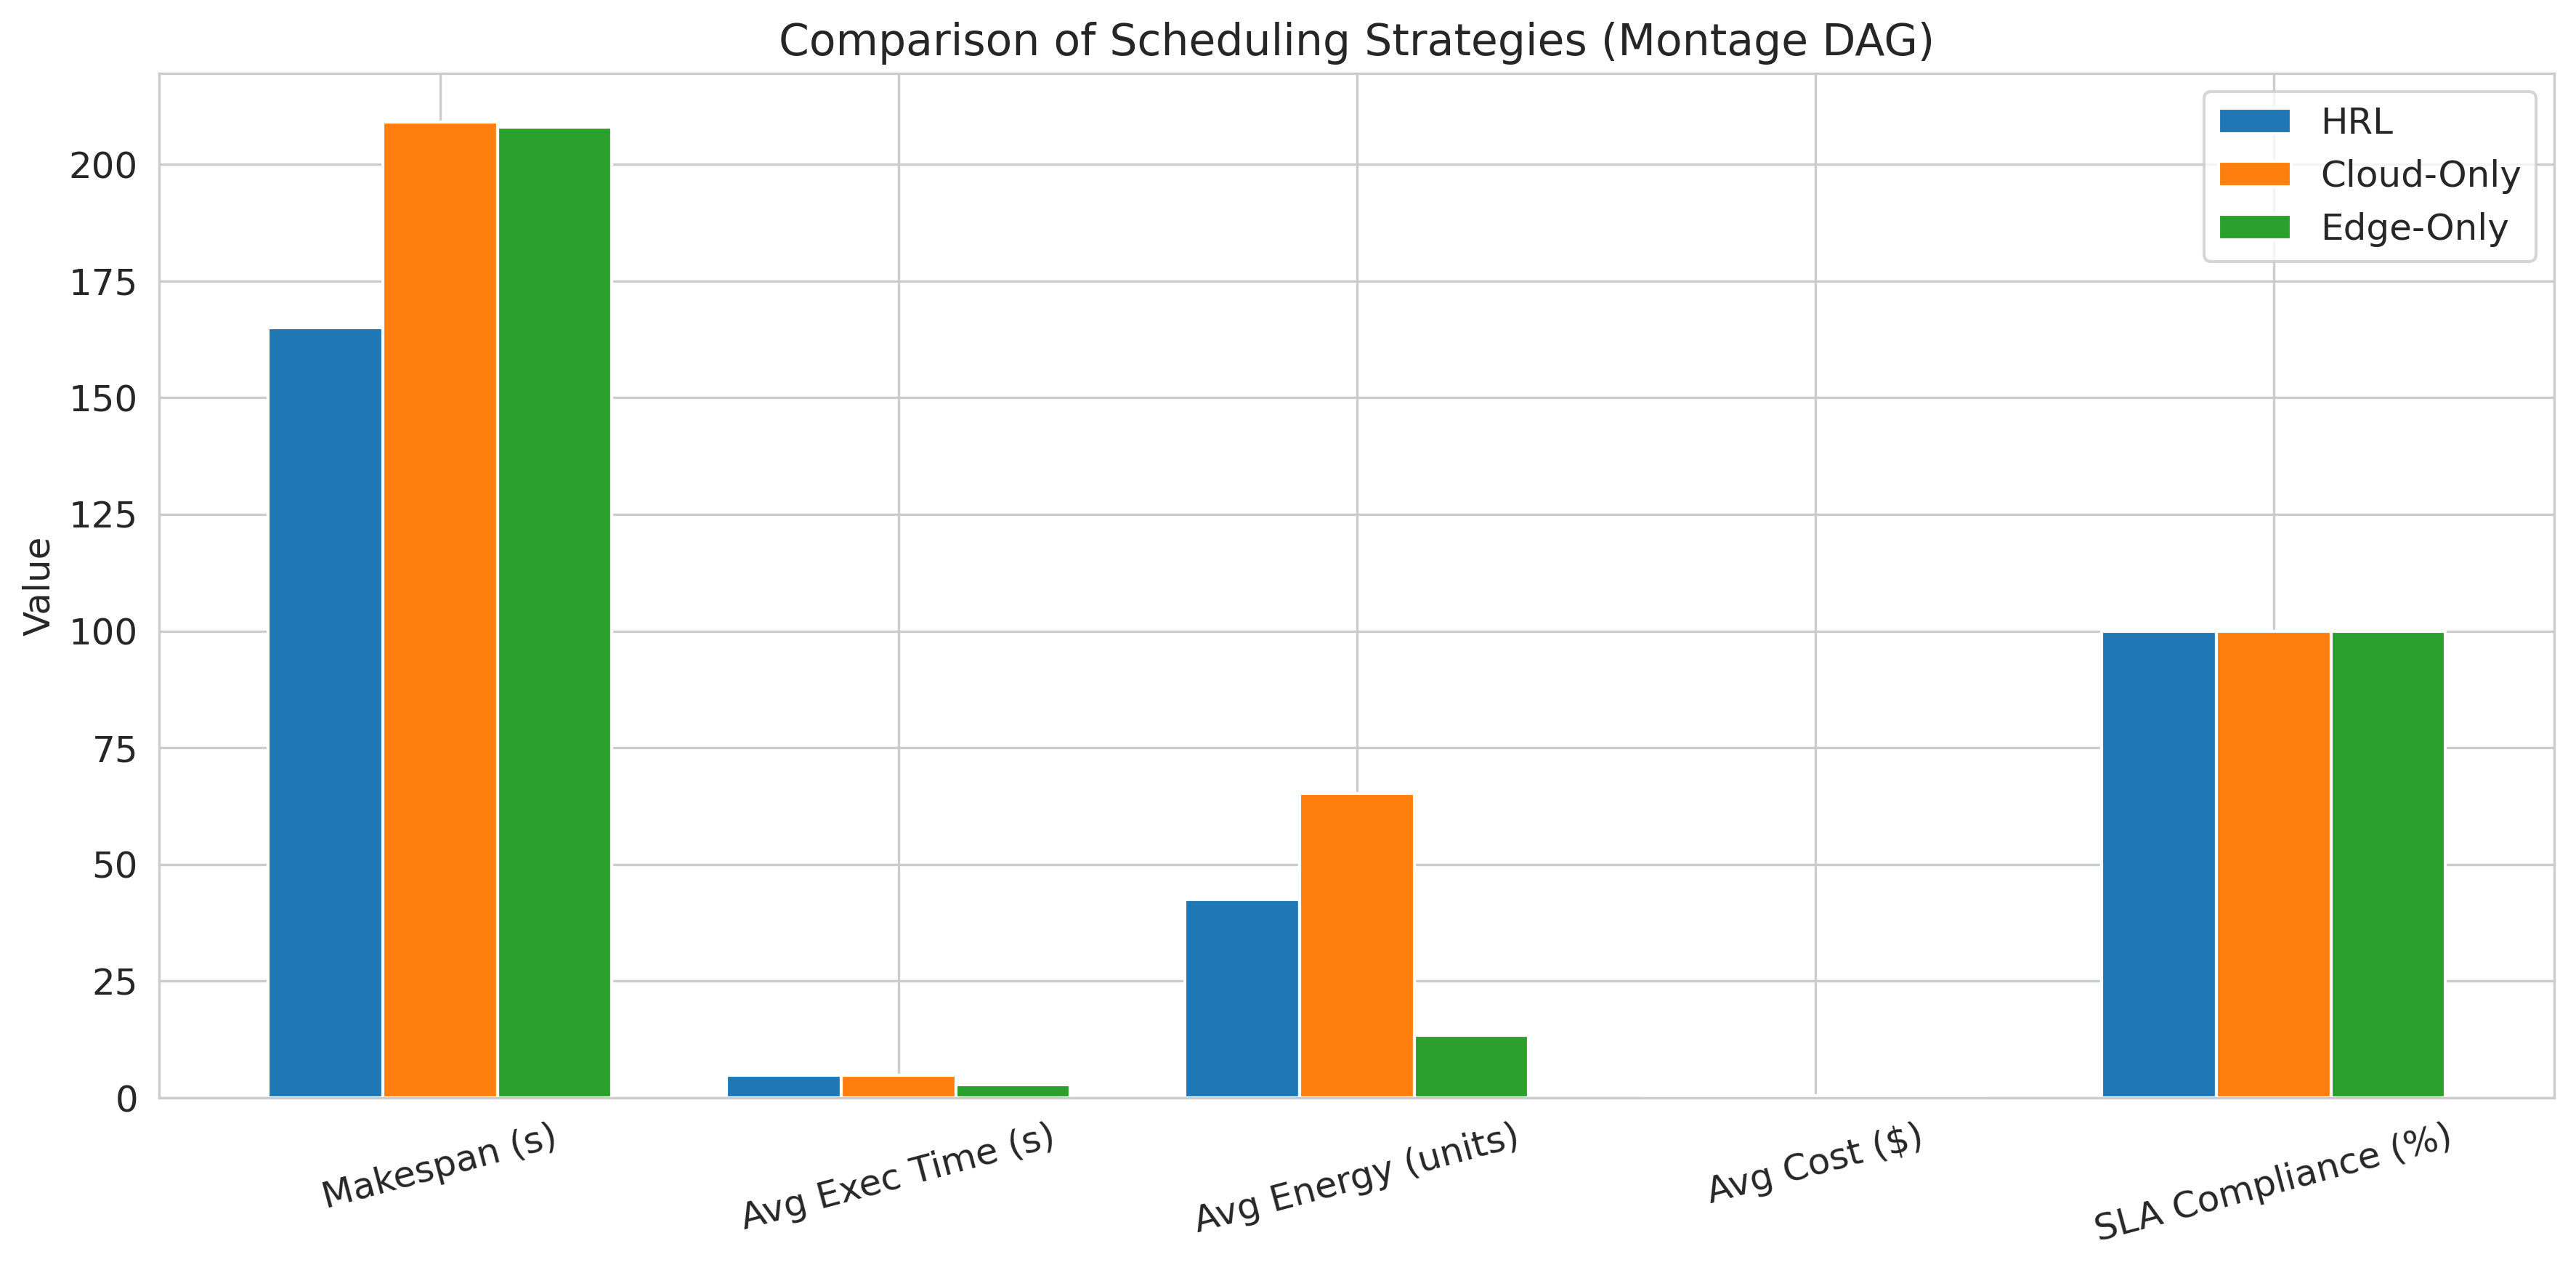

           Displaying placement_distribution.png                                <ipython-input-16-f356d06d38b6>:466

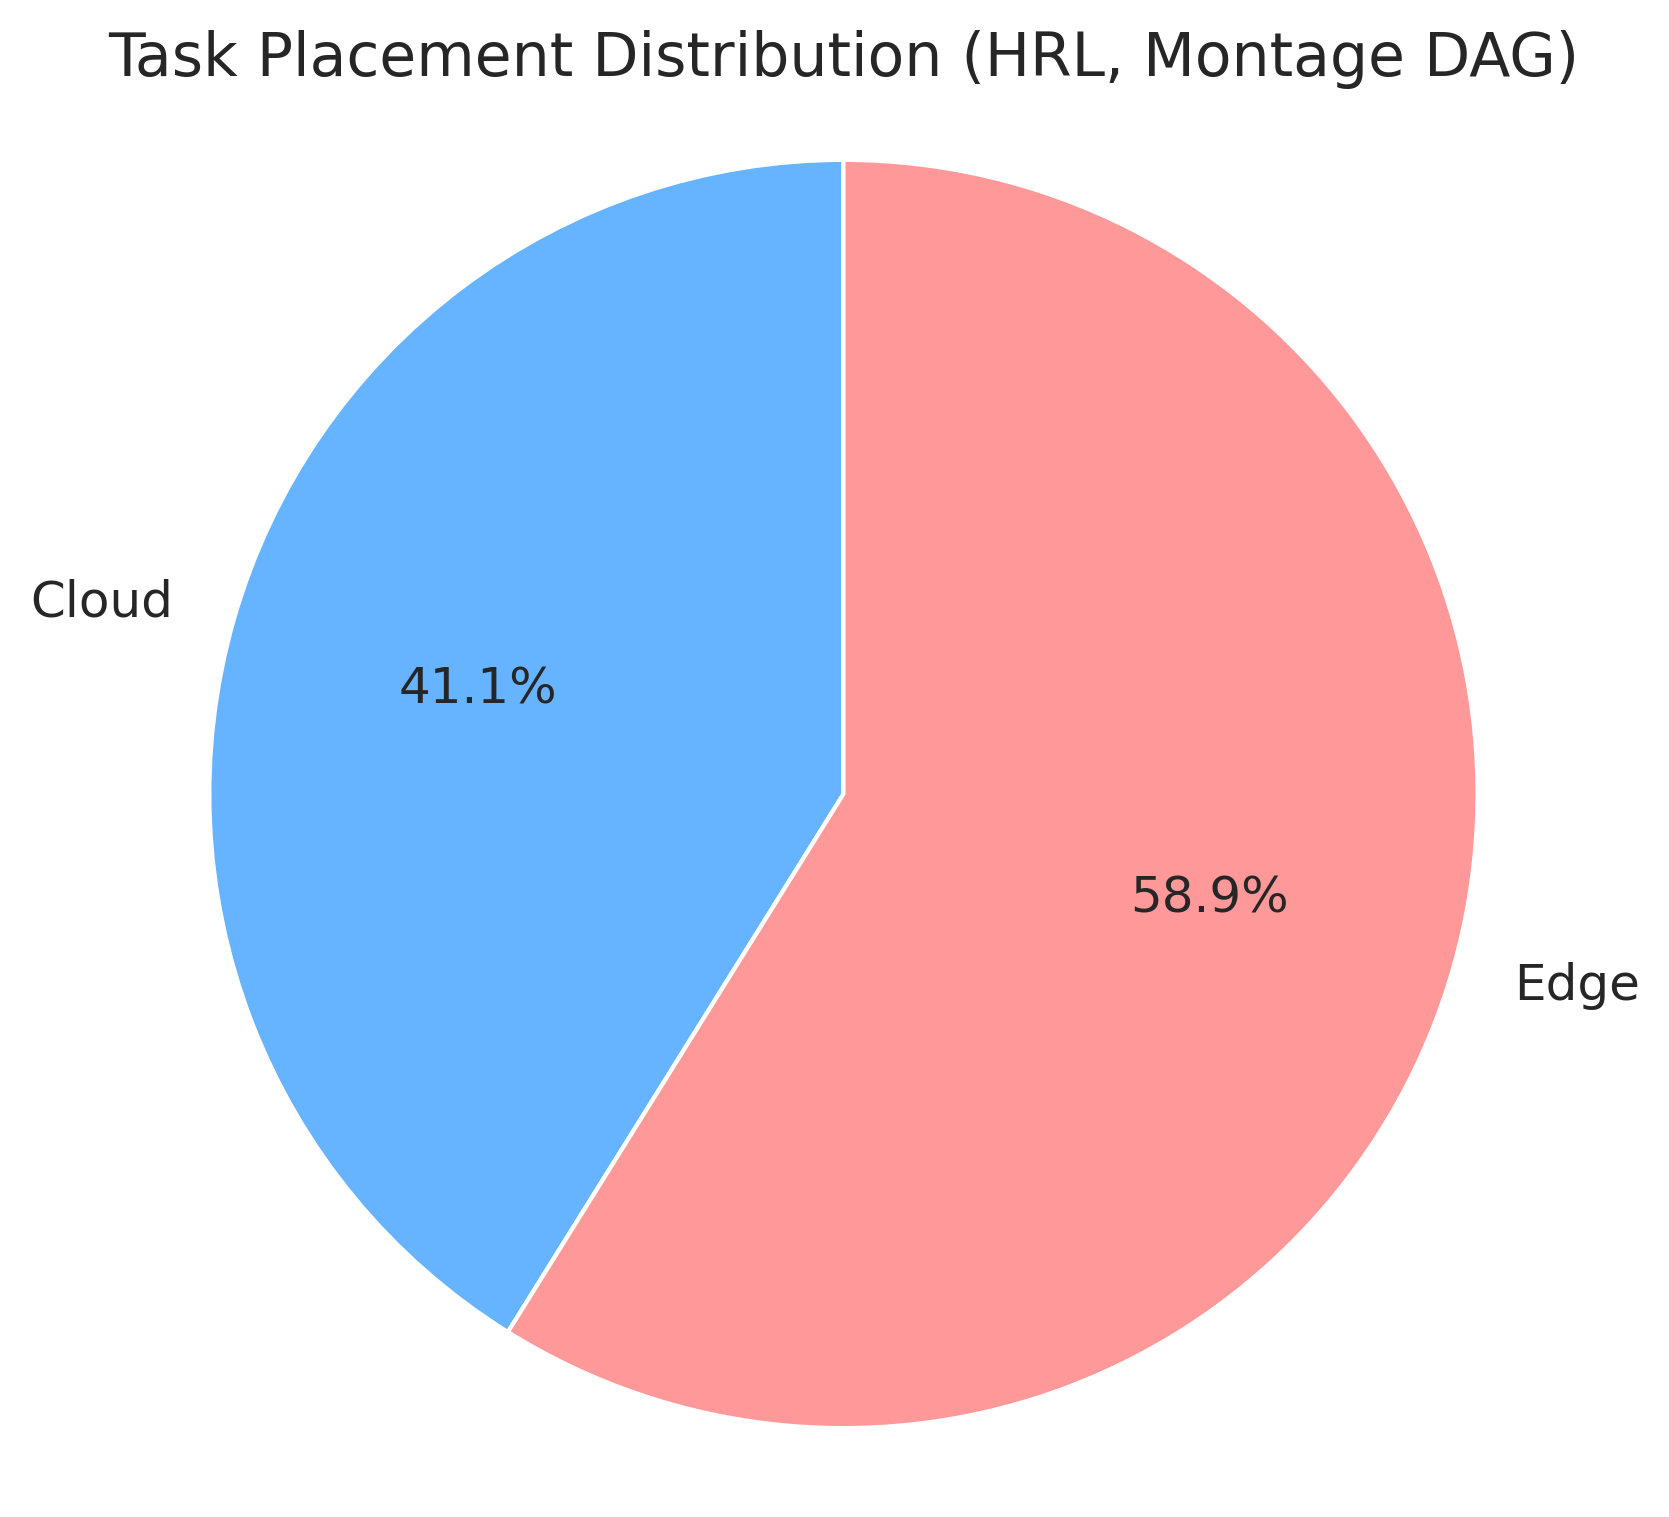

           Displaying load_balance.png                                          <ipython-input-16-f356d06d38b6>:466

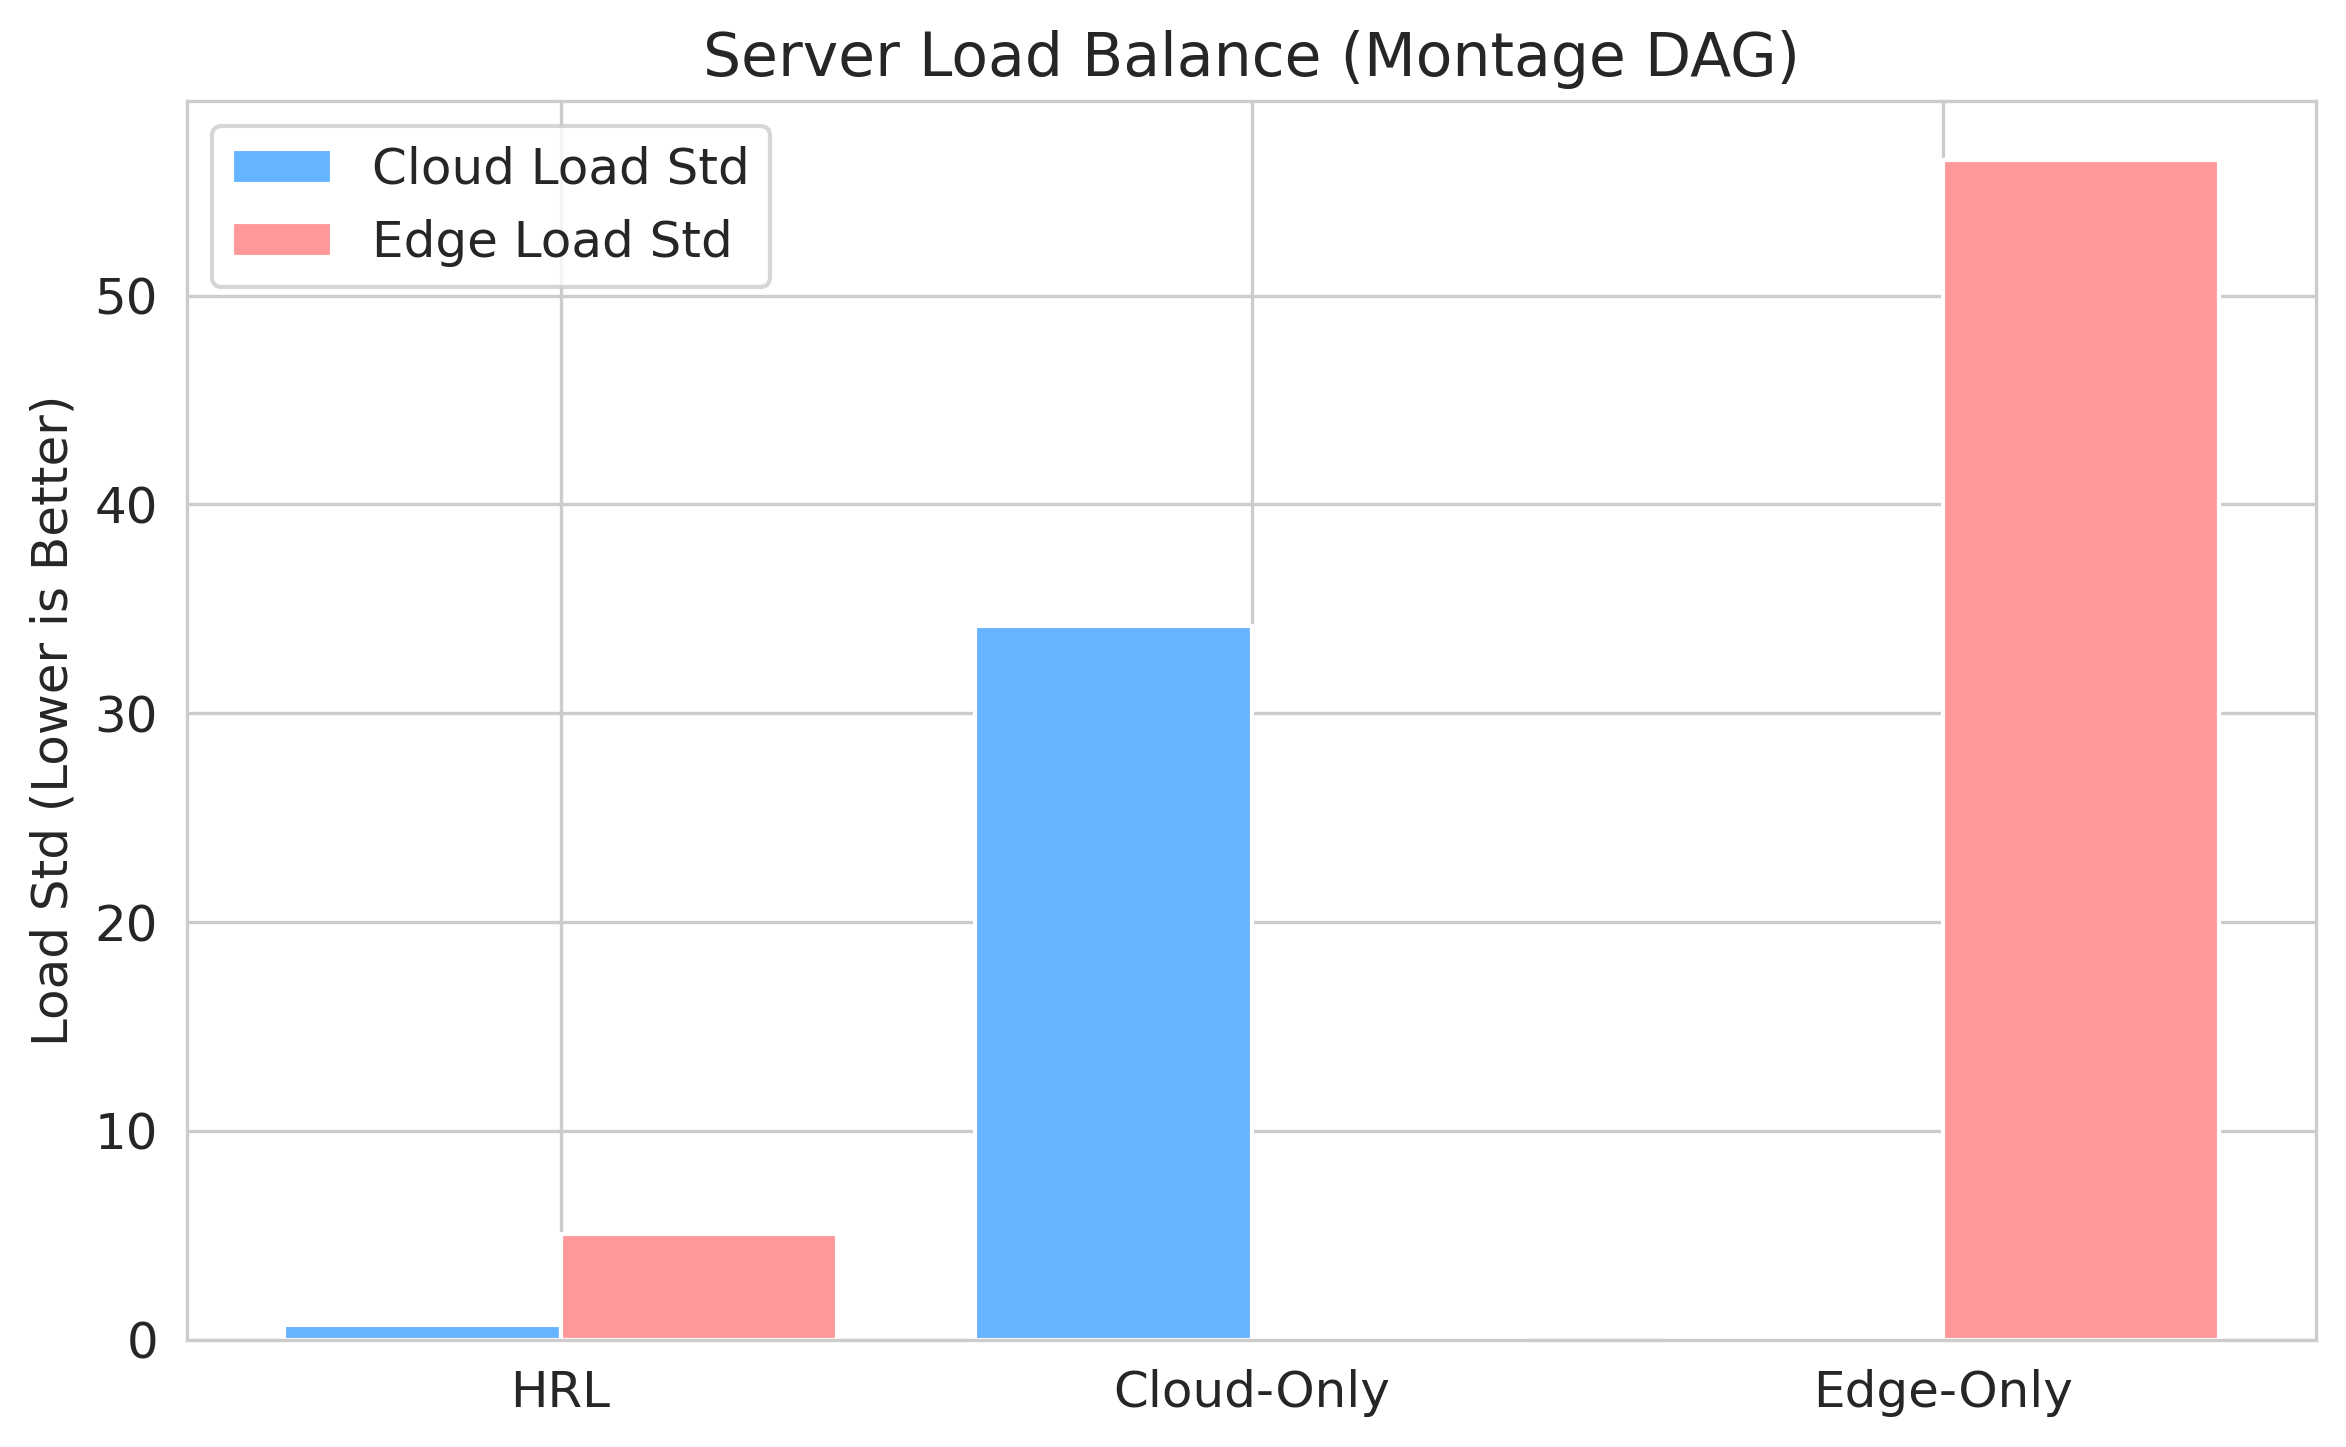

In [17]:
#training and testing of the scheduler and the models involved
if __name__ == "__main__":
    console = Console()
    # Suppress non-essential logs
    console.quiet = True
    for f in ["tier1_scheduler_new.zip", "tier2_scheduler_new.zip", "schedule.json"]:
        if os.path.exists(f):
            os.remove(f)
    # Train GNN on CyberShake
    trainer = GNNTrainer("balanced_cybershake_dag.json", "dag_embeddings_uncert.pth", embedding_dim=32)
    trainer.train(epochs=50)
    # Train HRL on CyberShake
    scheduler = WorkflowScheduler("balanced_cybershake_dag.json", "dag_embeddings_uncert.pth")
    scheduler.train_tier1(timesteps=20000)
    scheduler.train_tier2(timesteps=20000)
    # Validate on Montage
    scheduler.validate()
    scheduler.run_baselines()
    # Generate all results
    console.quiet = False
    scheduler.present_results()

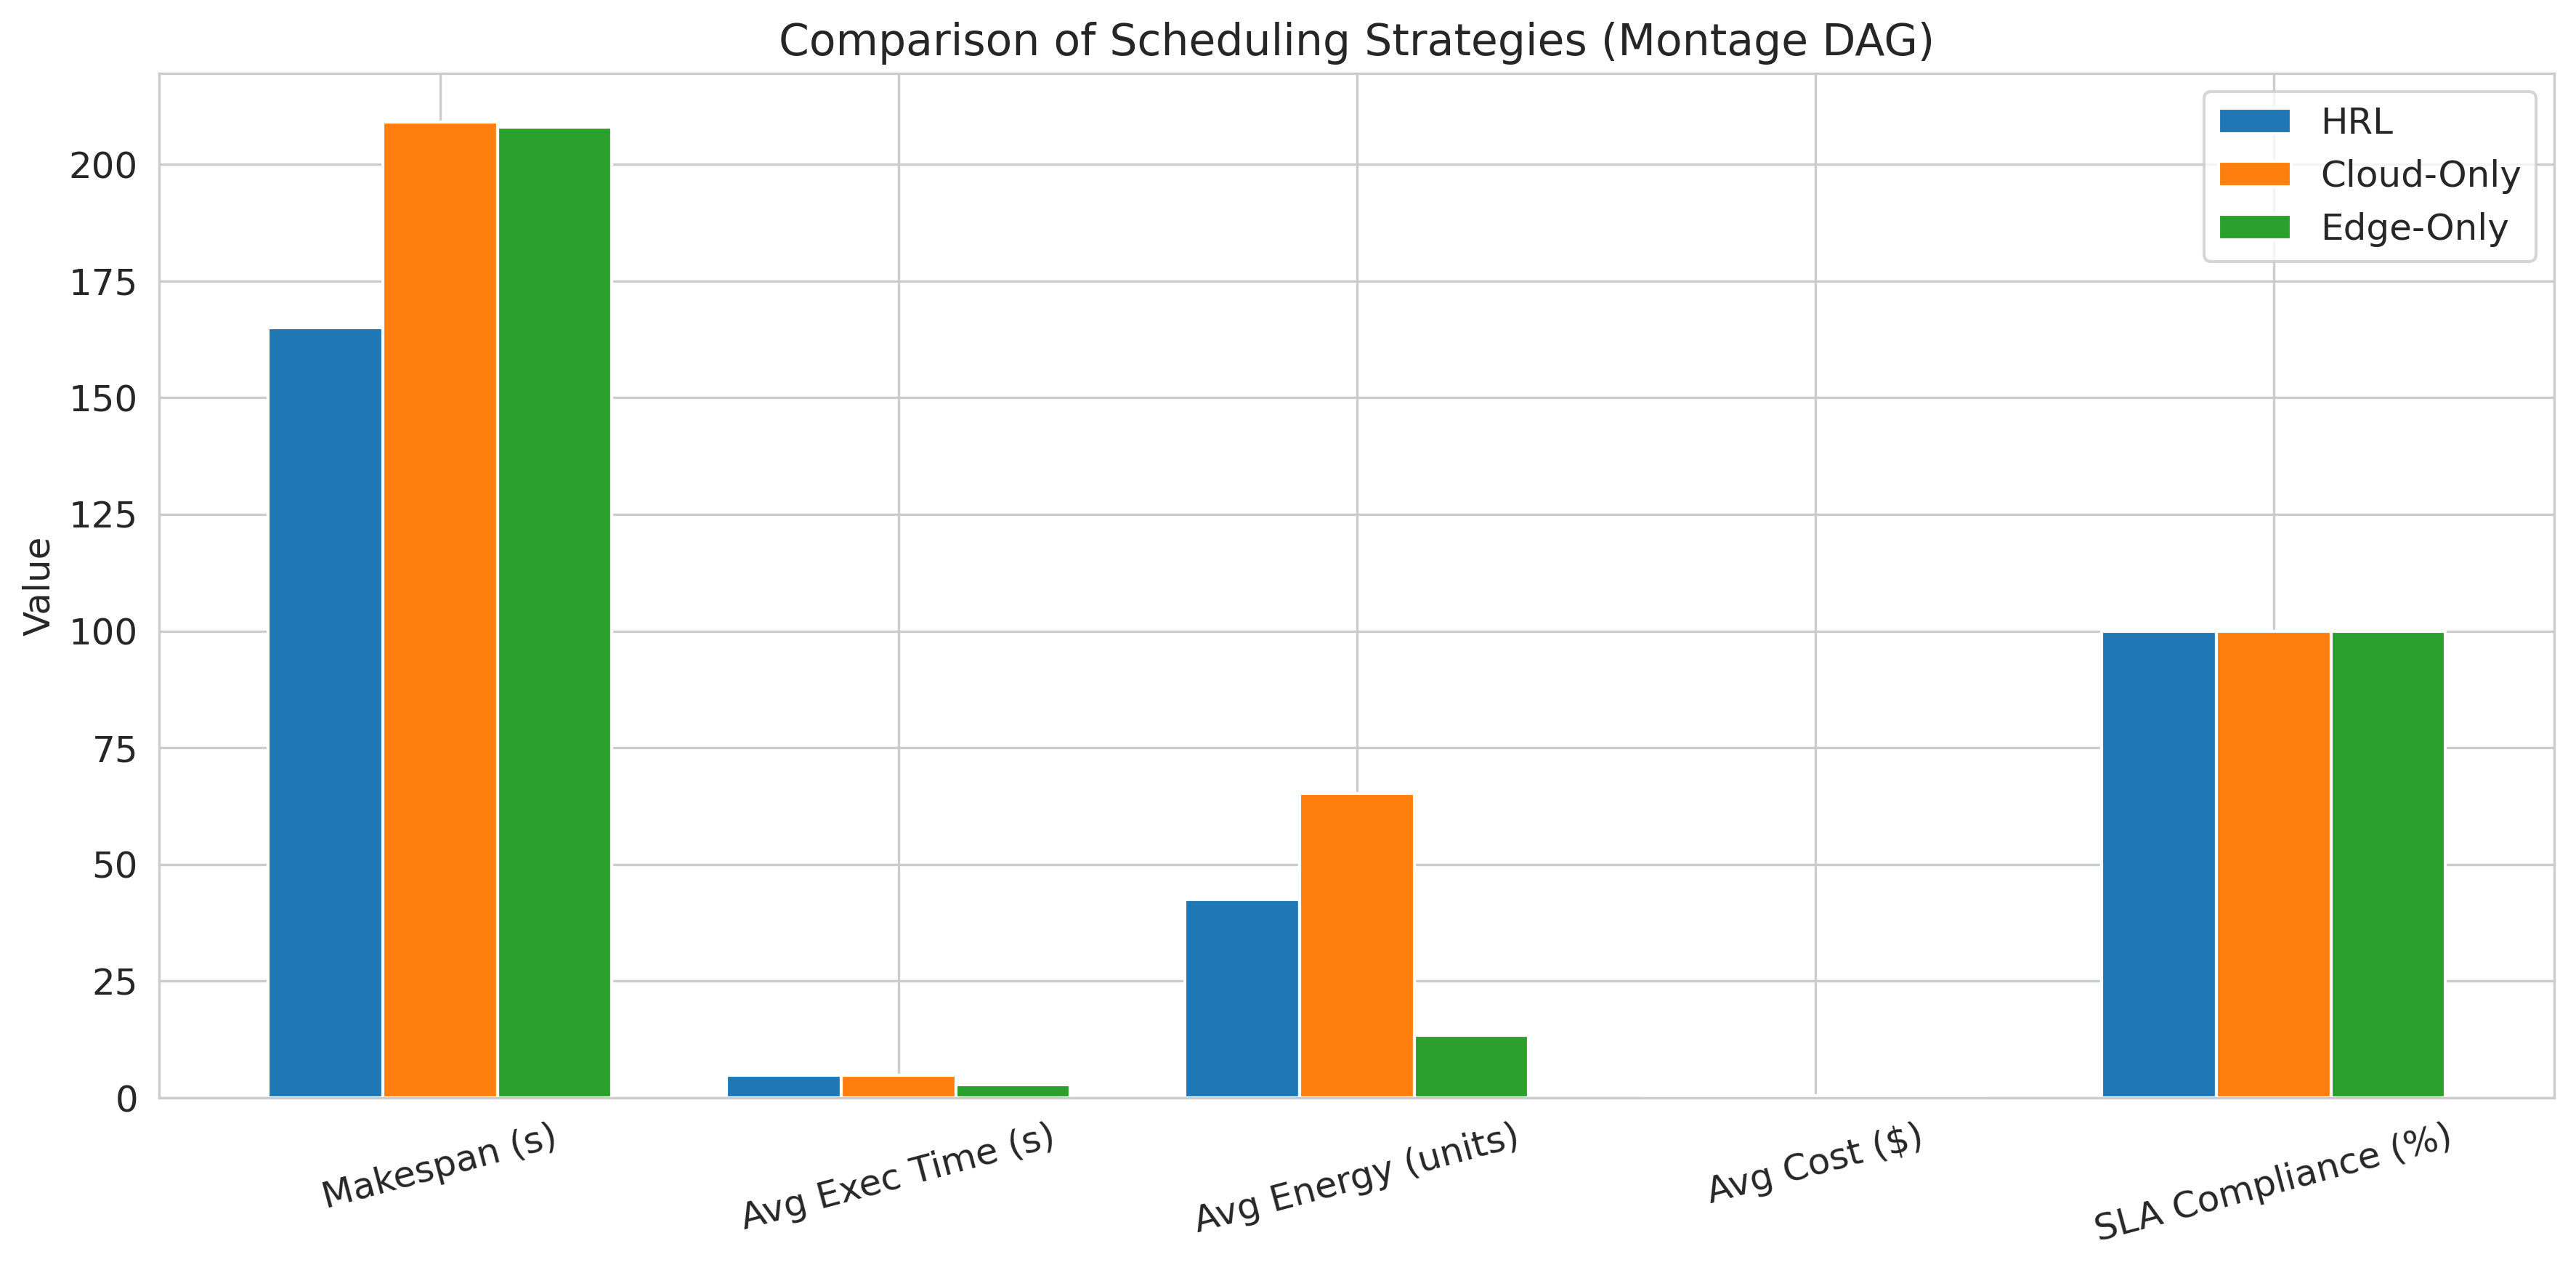

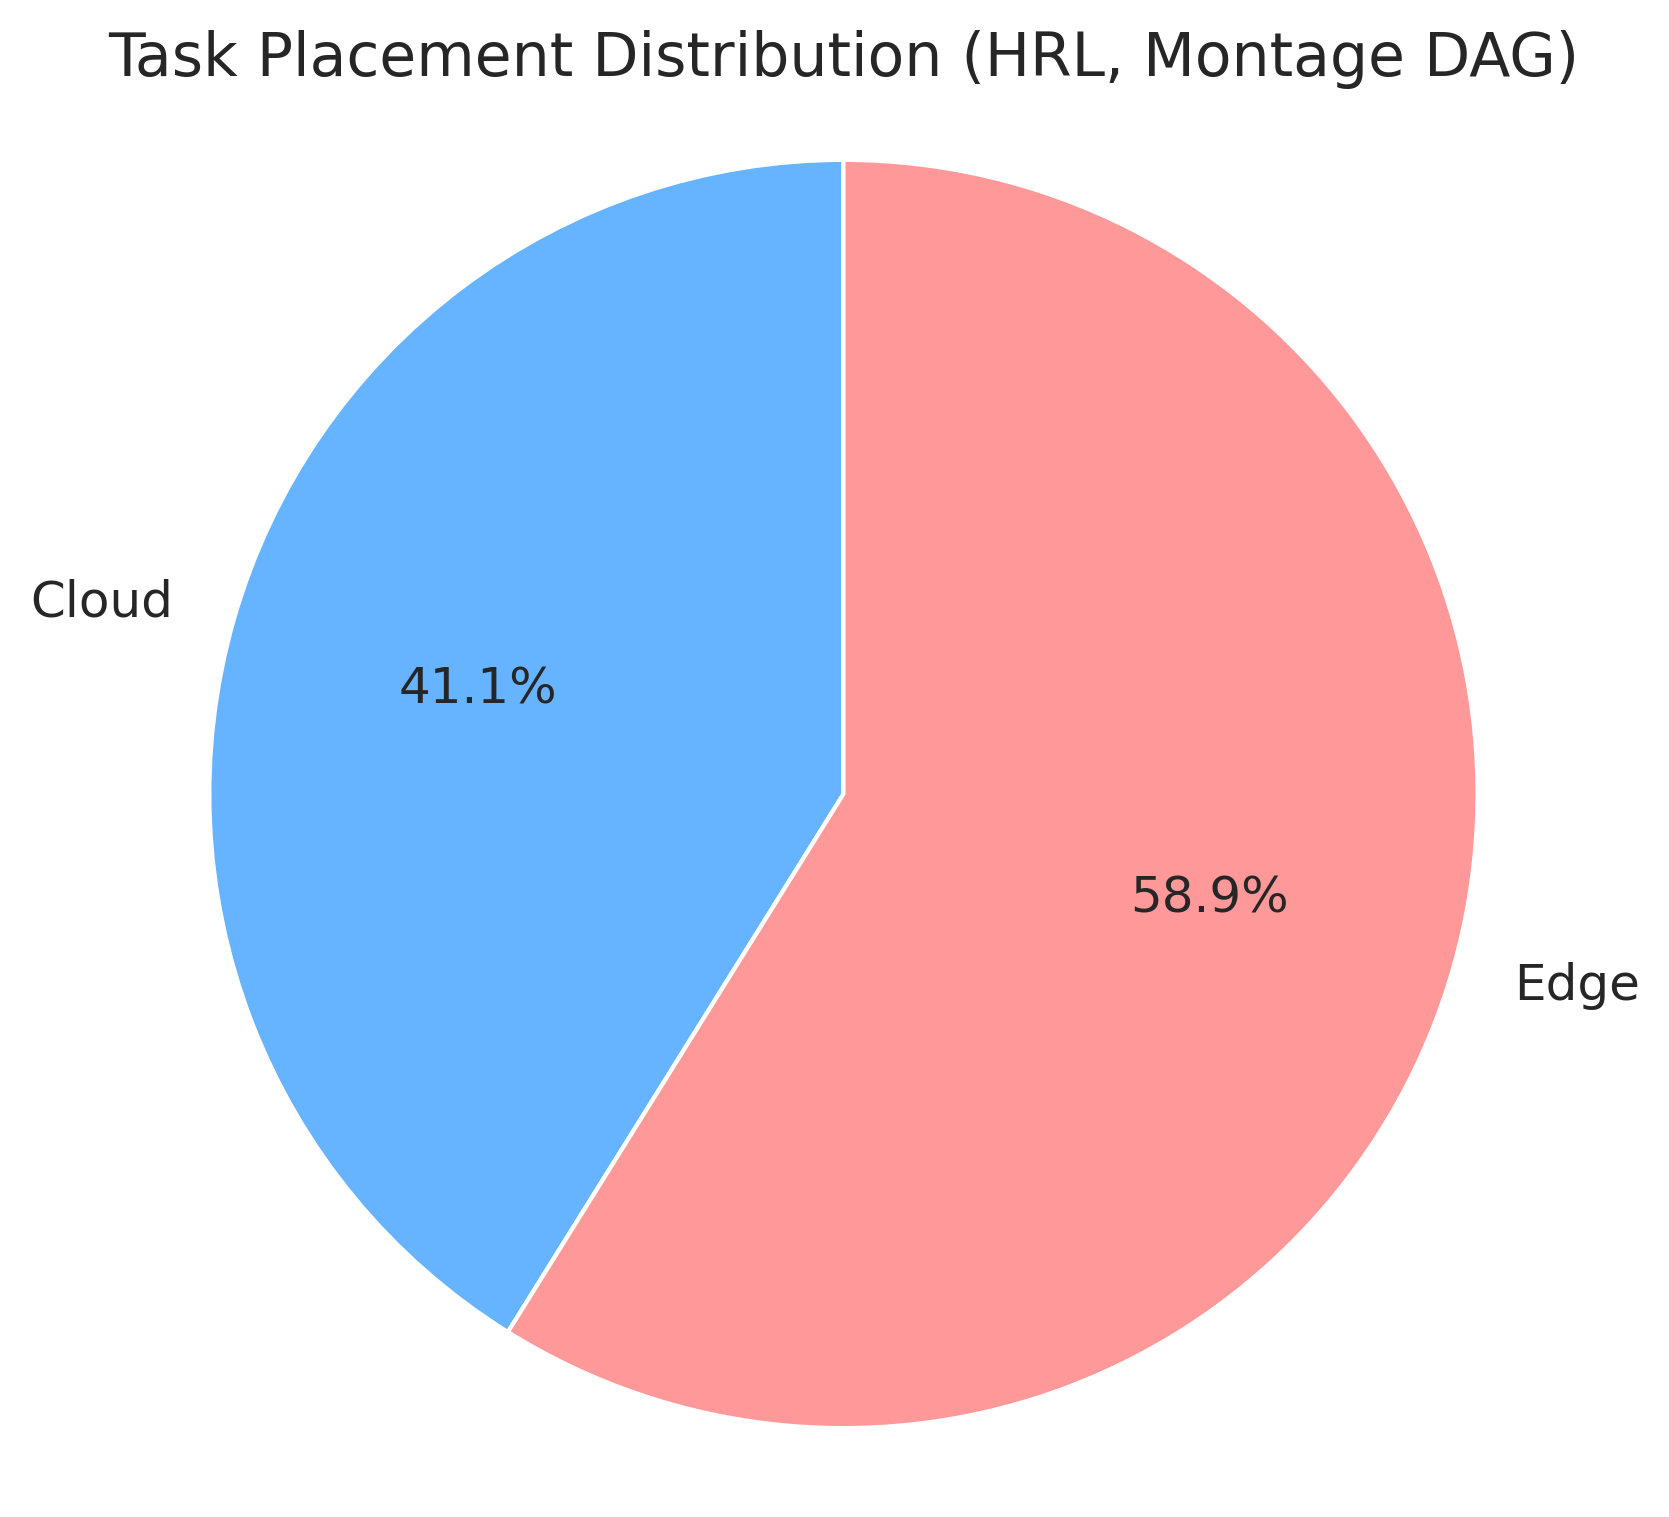

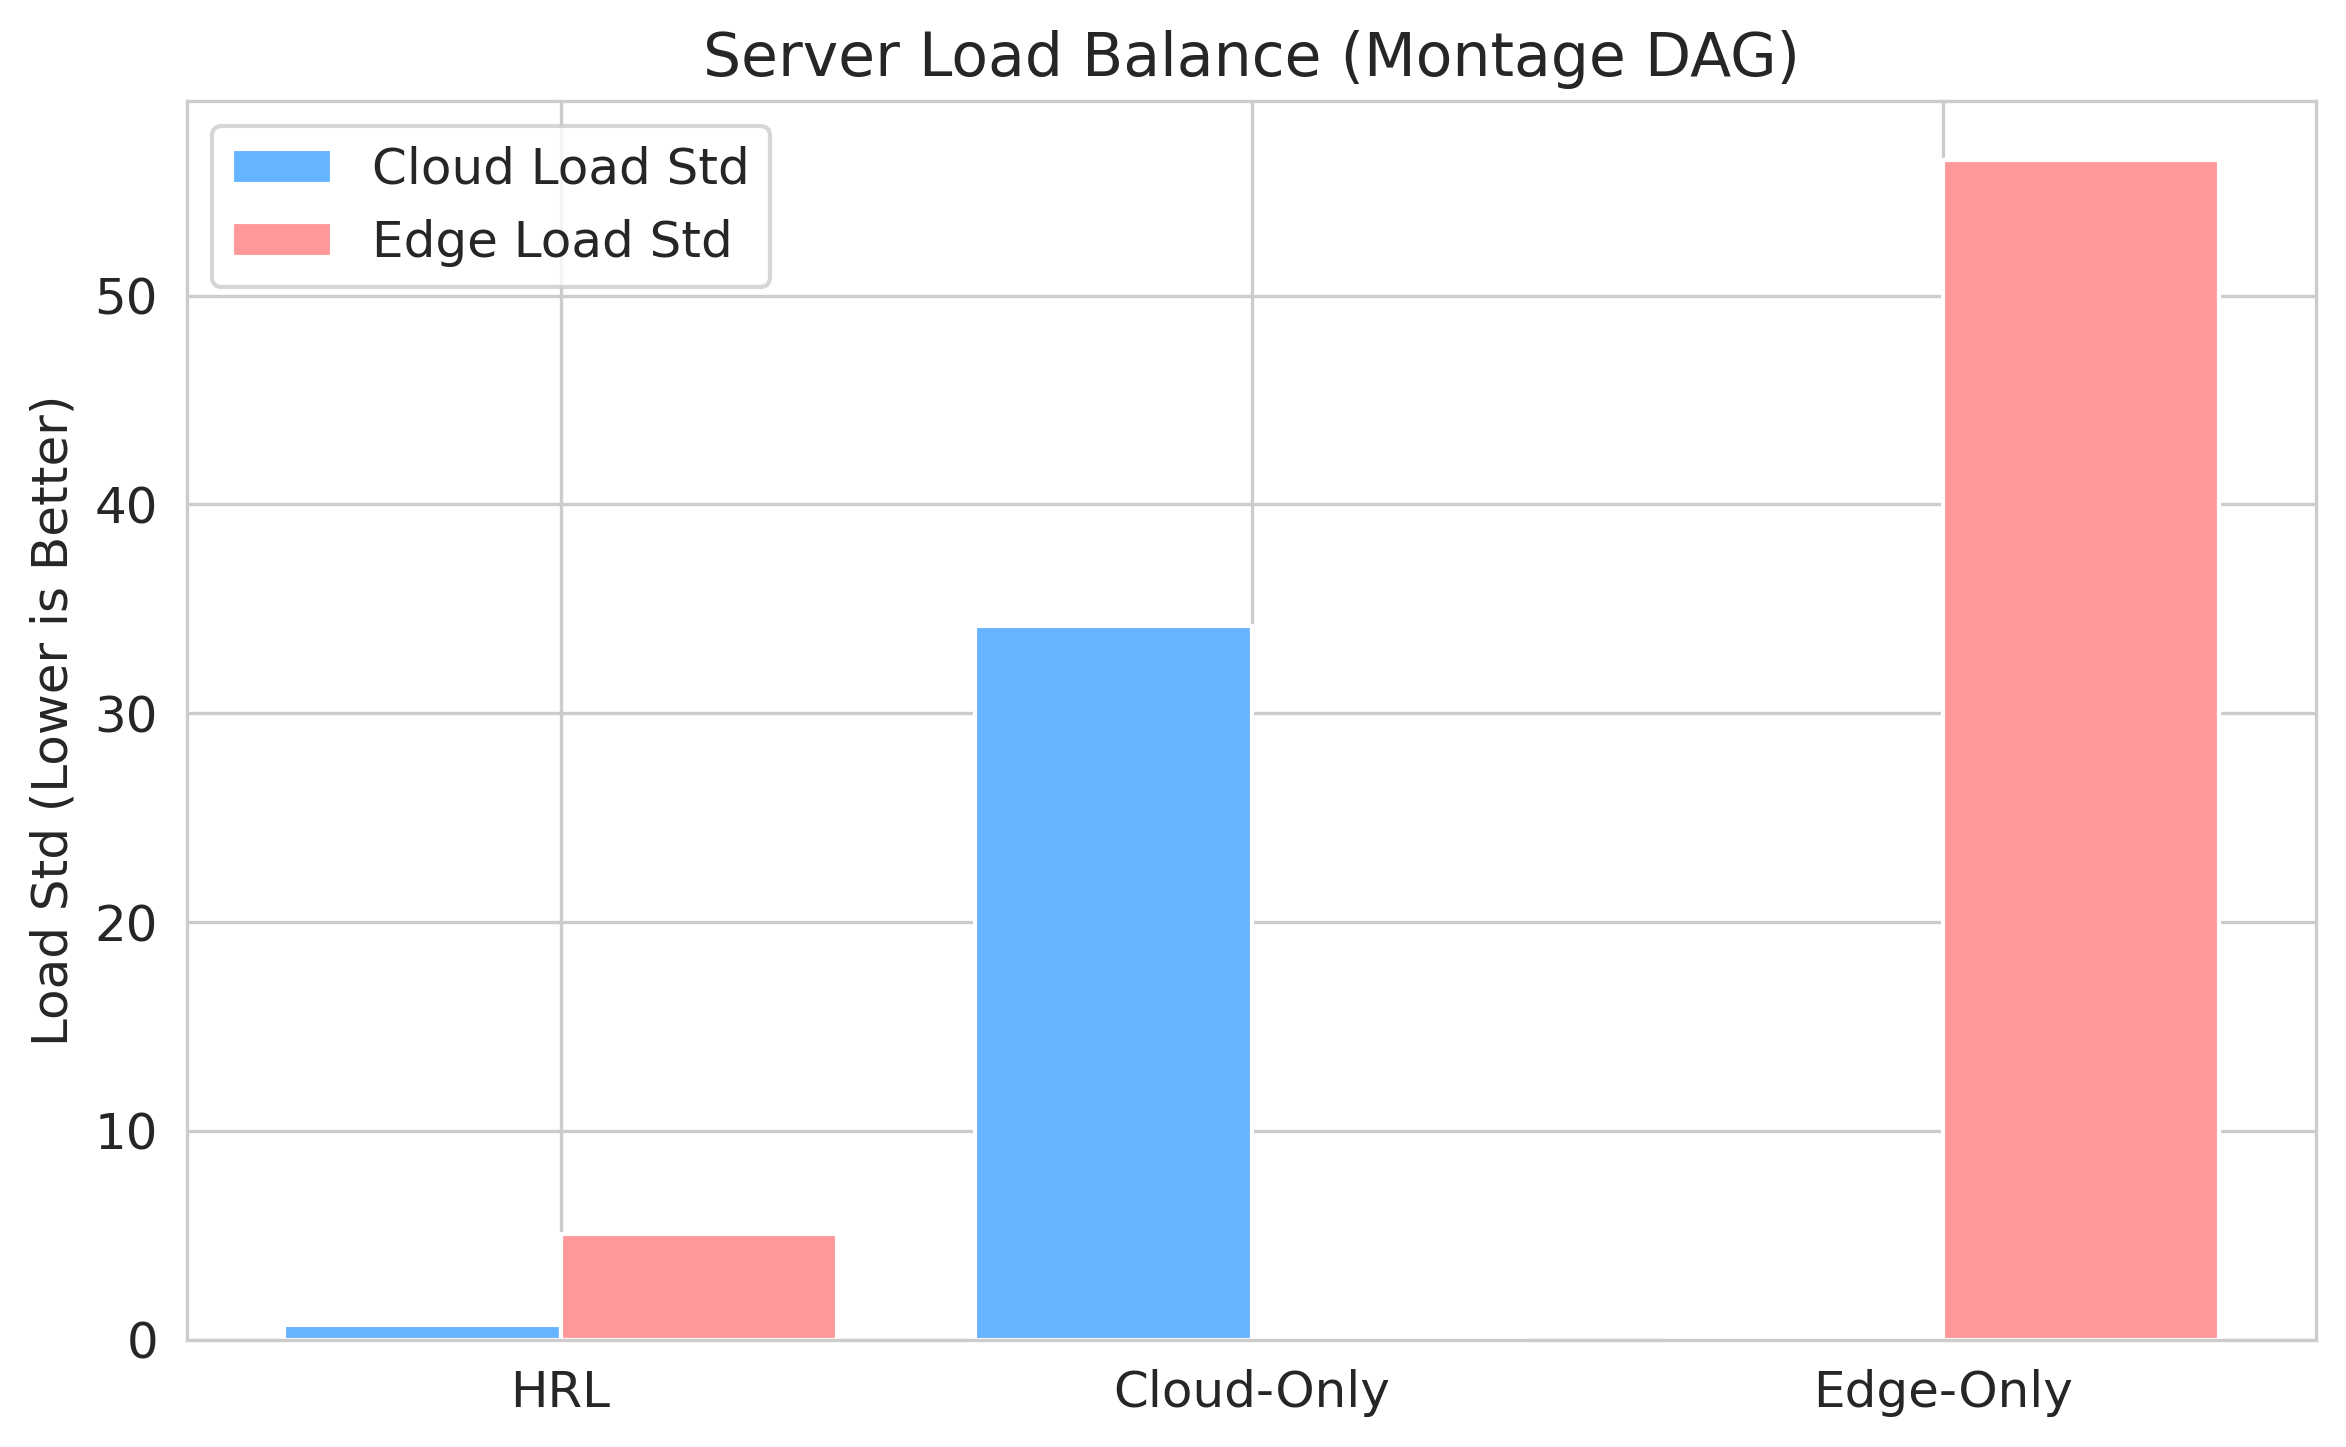

In [18]:
#showing the visualisations seperately
from IPython.display import Image, display
import os

def show_pngs(max_width=300):
    """Displays PNG images with a specified maximum width."""
    image_paths = [
        "metrics_comparison.png",
        "placement_distribution.png",
        "load_balance.png"
    ]
    for image_path in image_paths:
        if os.path.exists(image_path):
            display(Image(filename=image_path, width=max_width))
        else:
            print(f"Warning: Image file not found: {image_path}")
show_pngs(max_width=600)

In [19]:
import json
import os
from rich.console import Console
from rich.table import Table

# Print execution time and placement for tasks from schedule JSONs
def print_schedule_details(modes=["hrl", "cloud", "edge"]):
    console = Console()
    for mode in modes:
        filename = f"schedule_{mode}.json"
        # Check if schedule file exists
        if not os.path.exists(filename):
            console.log(f"Warning: {filename} not found for {mode.upper()}")
            continue
        # Load schedule JSON
        with open(filename, "r") as f:
            schedule = json.load(f)  # Dict: [num_tasks] keys
        if not schedule:
            console.log(f"Warning: {filename} is empty for {mode.upper()}")
            continue
        # Create table for display
        table = Table(title=f"Task Schedule ({mode.upper()}, Montage DAG)")
        table.add_column("Task ID", justify="center")
        table.add_column("Placement", justify="center")
        table.add_column("Execution Time (s)", justify="center")
        # Sort tasks by ID for consistent ordering
        sorted_tasks = sorted(schedule.items(), key=lambda x: x[0])  # List: [num_tasks, (task_id, dict)]
        for task_id, info in sorted_tasks:
            placement = info.get("placement", "N/A")
            exec_time = info.get("exec_time", 0.0)
            table.add_row(task_id, str(placement), f"{exec_time:.2f}")
        console.print(table)
        console.log(f"Displayed {len(schedule)} tasks for {mode.upper()}")

if __name__ == "__main__":
    # Execute for all modes
    print_schedule_details()  # Outputs tables for HRL, cloud, edge

      Task Schedule (HRL, Montage DAG)      
┏━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Task ID ┃ Placement ┃ Execution Time (s) ┃
┡━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ ID00001 │   cloud   │        5.00        │
│ ID00003 │   edge    │        5.00        │
│ ID00004 │   cloud   │        5.00        │
│ ID00005 │   edge    │        5.00        │
│ ID00007 │   cloud   │        4.83        │
│ ID00010 │   edge    │        5.00        │
│ ID00011 │   cloud   │        5.00        │
│ ID00012 │   cloud   │        5.00        │
│ ID00013 │   edge    │        5.00        │
│ ID00014 │   edge    │        5.00        │
│ ID00015 │   cloud   │        5.00        │
│ ID00016 │   cloud   │        5.00        │
│ ID00017 │   edge    │        5.00        │
│ ID00018 │   cloud   │        5.00        │
│ ID00021 │   edge    │        5.00        │
│ ID00023 │   edge    │        5.00        │
│ ID00024 │   cloud   │        5.00        │
│ ID00025 │   cloud   │        5.00        │
│ ID00026 │   edge    │        5.00        │
│ ID00027 │   cloud   │        5.00        │
│ ID00028 │   edge    │        5.00        │
│ ID00029 │   edge    │        5.00        │
│ ID00030 │   cloud   │        5.00        │
│ ID00031 │   cloud   │        5.00        │
│ ID00033 │   cloud   │        5.00        │
│ ID00034 │   cloud   │        4.83        │
│ ID00035 │   cloud   │        5.00        │
│ ID00036 │   cloud   │        5.00        │
│ ID00037 │   cloud   │        5.00        │
│ ID00039 │   edge    │        5.00        │
│ ID00040 │   cloud   │        5.00        │
│ ID00041 │   cloud   │        5.00        │
│ ID00043 │   edge    │        5.00        │
│ ID00044 │   edge    │        5.00        │
│ ID00045 │   cloud   │        5.00        │
│ ID00046 │   edge    │        5.00        │
│ ID00047 │   edge    │        5.00        │
│ ID00048 │   cloud   │        5.00        │
│ ID00049 │   edge    │        4.83        │
│ ID00051 │   cloud   │        5.00        │
│ ID00052 │   edge    │        5.00        │
│ ID00055 │   edge    │        5.00        │
│ ID00056 │   edge    │        4.86        │
│ ID00058 │   edge    │        4.91        │
│ ID00059 │   cloud   │        5.00        │
│ ID00060 │   edge    │        5.00        │
│ ID00061 │   edge    │        5.00        │
│ ID00062 │   edge    │        5.00        │
│ ID00063 │   edge    │        5.00        │
│ ID00064 │   edge    │        5.00        │
│ ID00065 │   edge    │        5.00        │
│ ID00066 │   edge    │        5.00        │
│ ID00067 │   cloud   │        4.90        │
│ ID00069 │   edge    │        5.00        │
│ ID00071 │   edge    │        5.00        │
│ ID00072 │   edge    │        5.00        │
│ ID00074 │   edge    │        4.88        │
│ ID00075 │   edge    │        5.00        │
│ ID00076 │   edge    │        5.00        │
│ ID00077 │   cloud   │        5.00        │
│ ID00078 │   cloud   │        4.99        │
│ ID00079 │   cloud   │        5.00        │
│ ID00081 │   edge    │        5.00        │
│ ID00082 │   cloud   │        5.00        │
│ ID00084 │   edge    │        5.00        │
│ ID00085 │   edge    │        5.00        │
│ ID00086 │   cloud   │        5.00        │
│ ID00087 │   cloud   │        5.00        │
│ ID00088 │   edge    │        5.00        │
│ ID00089 │   edge    │        5.00        │
│ ID00090 │   edge    │        5.00        │
│ ID00091 │   cloud   │        5.00        │
│ ID00093 │   cloud   │        5.00        │
│ ID00095 │   edge    │        5.00        │
│ ID00096 │   edge    │        5.00        │
│ ID00098 │   cloud   │        5.00        │
│ ID00099 │   cloud   │        5.00        │
│ ID00100 │   edge    │        5.00        │
│ ID00101 │   cloud   │        5.00        │
│ ID00102 │   cloud   │        5.00        │
│ ID00103 │   edge    │        5.00        │
│ ID00104 │   edge    │        5.00        │
│ ID00105 │   edge    │        5.00        │
│ ID00106 │   cloud   │        5.00        │
│ ID00107 │   edge    │        5.00     

[05:38:11] Displayed 800 tasks for HRL                                           <ipython-input-19-3827beb8a594>:33

     Task Schedule (CLOUD, Montage DAG)     
┏━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Task ID ┃ Placement ┃ Execution Time (s) ┃
┡━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ ID00001 │   cloud   │        5.00        │
│ ID00003 │   cloud   │        5.00        │
│ ID00004 │   cloud   │        5.00        │
│ ID00005 │   cloud   │        5.00        │
│ ID00007 │   cloud   │        4.84        │
│ ID00010 │   cloud   │        5.00        │
│ ID00011 │   cloud   │        5.00        │
│ ID00012 │   cloud   │        5.00        │
│ ID00013 │   cloud   │        5.00        │
│ ID00014 │   cloud   │        5.00        │
│ ID00015 │   cloud   │        5.00        │
│ ID00016 │   cloud   │        5.00        │
│ ID00017 │   cloud   │        5.00        │
│ ID00018 │   cloud   │        5.00        │
│ ID00021 │   cloud   │        5.00        │
│ ID00023 │   cloud   │        5.00        │
│ ID00024 │   cloud   │        5.00        │
│ ID00025 │   cloud   │        5.00        │
│ ID00026 │   cloud   │        5.00        │
│ ID00027 │   cloud   │        5.00        │
│ ID00028 │   cloud   │        5.00        │
│ ID00029 │   cloud   │        5.00        │
│ ID00030 │   cloud   │        5.00        │
│ ID00031 │   cloud   │        5.00        │
│ ID00033 │   cloud   │        5.00        │
│ ID00034 │   cloud   │        5.00        │
│ ID00035 │   cloud   │        5.00        │
│ ID00036 │   cloud   │        5.00        │
│ ID00037 │   cloud   │        5.00        │
│ ID00039 │   cloud   │        5.00        │
│ ID00040 │   cloud   │        5.00        │
│ ID00041 │   cloud   │        5.00        │
│ ID00043 │   cloud   │        5.00        │
│ ID00044 │   cloud   │        5.00        │
│ ID00045 │   cloud   │        5.00        │
│ ID00046 │   cloud   │        5.00        │
│ ID00047 │   cloud   │        5.00        │
│ ID00048 │   cloud   │        5.00        │
│ ID00049 │   cloud   │        4.84        │
│ ID00051 │   cloud   │        5.00        │
│ ID00052 │   cloud   │        5.00        │
│ ID00055 │   cloud   │        5.00        │
│ ID00056 │   cloud   │        4.84        │
│ ID00058 │   cloud   │        5.00        │
│ ID00059 │   cloud   │        5.00        │
│ ID00060 │   cloud   │        5.00        │
│ ID00061 │   cloud   │        5.00        │
│ ID00062 │   cloud   │        5.00        │
│ ID00063 │   cloud   │        5.00        │
│ ID00064 │   cloud   │        5.00        │
│ ID00065 │   cloud   │        5.00        │
│ ID00066 │   cloud   │        5.00        │
│ ID00067 │   cloud   │        4.84        │
│ ID00069 │   cloud   │        5.00        │
│ ID00071 │   cloud   │        5.00        │
│ ID00072 │   cloud   │        5.00        │
│ ID00074 │   cloud   │        5.00        │
│ ID00075 │   cloud   │        5.00        │
│ ID00076 │   cloud   │        5.00        │
│ ID00077 │   cloud   │        5.00        │
│ ID00078 │   cloud   │        5.00        │
│ ID00079 │   cloud   │        5.00        │
│ ID00081 │   cloud   │        5.00        │
│ ID00082 │   cloud   │        5.00        │
│ ID00084 │   cloud   │        5.00        │
│ ID00085 │   cloud   │        5.00        │
│ ID00086 │   cloud   │        5.00        │
│ ID00087 │   cloud   │        5.00        │
│ ID00088 │   cloud   │        5.00        │
│ ID00089 │   cloud   │        5.00        │
│ ID00090 │   cloud   │        5.00        │
│ ID00091 │   cloud   │        5.00        │
│ ID00093 │   cloud   │        5.00        │
│ ID00095 │   cloud   │        5.00        │
│ ID00096 │   cloud   │        5.00        │
│ ID00098 │   cloud   │        5.00        │
│ ID00099 │   cloud   │        5.00        │
│ ID00100 │   cloud   │        5.00        │
│ ID00101 │   cloud   │        5.00        │
│ ID00102 │   cloud   │        5.00        │
│ ID00103 │   cloud   │        5.00        │
│ ID00104 │   cloud   │        5.00        │
│ ID00105 │   cloud   │        5.00        │
│ ID00106 │   cloud   │        5.00        │
│ ID00107 │   cloud   │        5.00     

           Displayed 800 tasks for CLOUD                                         <ipython-input-19-3827beb8a594>:33

     Task Schedule (EDGE, Montage DAG)      
┏━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Task ID ┃ Placement ┃ Execution Time (s) ┃
┡━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ ID00001 │   edge    │        2.30        │
│ ID00003 │   edge    │        2.39        │
│ ID00004 │   edge    │        2.39        │
│ ID00005 │   edge    │        2.39        │
│ ID00007 │   edge    │        4.84        │
│ ID00010 │   edge    │        2.30        │
│ ID00011 │   edge    │        2.39        │
│ ID00012 │   edge    │        5.00        │
│ ID00013 │   edge    │        2.39        │
│ ID00014 │   edge    │        2.39        │
│ ID00015 │   edge    │        2.39        │
│ ID00016 │   edge    │        5.00        │
│ ID00017 │   edge    │        2.39        │
│ ID00018 │   edge    │        2.39        │
│ ID00021 │   edge    │        2.39        │
│ ID00023 │   edge    │        2.39        │
│ ID00024 │   edge    │        2.39        │
│ ID00025 │   edge    │        5.00        │
│ ID00026 │   edge    │        2.39        │
│ ID00027 │   edge    │        2.39        │
│ ID00028 │   edge    │        2.39        │
│ ID00029 │   edge    │        2.42        │
│ ID00030 │   edge    │        2.39        │
│ ID00031 │   edge    │        2.39        │
│ ID00033 │   edge    │        2.39        │
│ ID00034 │   edge    │        5.00        │
│ ID00035 │   edge    │        5.00        │
│ ID00036 │   edge    │        2.39        │
│ ID00037 │   edge    │        2.30        │
│ ID00039 │   edge    │        2.39        │
│ ID00040 │   edge    │        2.30        │
│ ID00041 │   edge    │        2.42        │
│ ID00043 │   edge    │        2.39        │
│ ID00044 │   edge    │        2.39        │
│ ID00045 │   edge    │        2.39        │
│ ID00046 │   edge    │        2.39        │
│ ID00047 │   edge    │        2.39        │
│ ID00048 │   edge    │        2.39        │
│ ID00049 │   edge    │        4.84        │
│ ID00051 │   edge    │        2.39        │
│ ID00052 │   edge    │        5.00        │
│ ID00055 │   edge    │        2.42        │
│ ID00056 │   edge    │        4.84        │
│ ID00058 │   edge    │        5.00        │
│ ID00059 │   edge    │        2.39        │
│ ID00060 │   edge    │        5.00        │
│ ID00061 │   edge    │        2.39        │
│ ID00062 │   edge    │        2.30        │
│ ID00063 │   edge    │        2.39        │
│ ID00064 │   edge    │        2.39        │
│ ID00065 │   edge    │        2.39        │
│ ID00066 │   edge    │        5.00        │
│ ID00067 │   edge    │        4.84        │
│ ID00069 │   edge    │        2.39        │
│ ID00071 │   edge    │        2.39        │
│ ID00072 │   edge    │        2.39        │
│ ID00074 │   edge    │        5.00        │
│ ID00075 │   edge    │        5.00        │
│ ID00076 │   edge    │        2.39        │
│ ID00077 │   edge    │        5.00        │
│ ID00078 │   edge    │        5.00        │
│ ID00079 │   edge    │        2.30        │
│ ID00081 │   edge    │        2.39        │
│ ID00082 │   edge    │        2.39        │
│ ID00084 │   edge    │        5.00        │
│ ID00085 │   edge    │        2.39        │
│ ID00086 │   edge    │        5.00        │
│ ID00087 │   edge    │        2.30        │
│ ID00088 │   edge    │        2.39        │
│ ID00089 │   edge    │        2.39        │
│ ID00090 │   edge    │        2.39        │
│ ID00091 │   edge    │        5.00        │
│ ID00093 │   edge    │        2.39        │
│ ID00095 │   edge    │        2.39        │
│ ID00096 │   edge    │        2.39        │
│ ID00098 │   edge    │        2.39        │
│ ID00099 │   edge    │        2.39        │
│ ID00100 │   edge    │        2.39        │
│ ID00101 │   edge    │        2.39        │
│ ID00102 │   edge    │        2.39        │
│ ID00103 │   edge    │        2.39        │
│ ID00104 │   edge    │        2.39        │
│ ID00105 │   edge    │        2.39        │
│ ID00106 │   edge    │        5.00        │
│ ID00107 │   edge    │        2.39     

           Displayed 800 tasks for EDGE                                          <ipython-input-19-3827beb8a594>:33

In [20]:
import json
import networkx as nx
import numpy as np
import torch
import os
from rich.console import Console
from rich.table import Table

# SJFScheduler: Shortest Job First scheduler for edge-cloud tasks
class SJFScheduler:
    def __init__(self, dag_file="balanced_montage_dag.json", embeddings_file="montage_embeddings.pth", max_nodes=1000):
        # Initialize SJF scheduler
        # Inputs:
        #   dag_file: Path to Montage DAG
        #   embeddings_file: Path to Montage embeddings
        #   max_nodes: Max nodes per DAG (default 1000)
        self.dag_file = dag_file  # Scalar
        self.embeddings_file = embeddings_file  # Scalar
        self.max_nodes = max_nodes  # Scalar
        self.console = Console()
        self.dag, self.embeddings, self.task_ids = self.load_dag_and_embeddings()  # dag: NetworkX, embeddings: [num_nodes, 32], task_ids: [num_nodes]
        self.task_queue = TaskQueue(self.dag, self.embeddings, self.task_ids)  # TaskQueue instance
        self.metrics = None  # Dict or None

    def load_dag_and_embeddings(self):
        # Load Montage DAG and embeddings
        # Returns: dag (NetworkX), embeddings [num_nodes, 32], task_ids [num_nodes]
        if not os.path.exists(self.dag_file):
            self.console.log(f"Error: DAG file {self.dag_file} not found")
            raise FileNotFoundError(f"DAG file {self.dag_file} not found")
        with open(self.dag_file, "r") as f:
            dag_json = json.load(f)  # Dict
        dag = nx.node_link_graph(dag_json, edges="links")  # NetworkX DAG
        if len(dag.nodes) > self.max_nodes:
            nodes = list(dag.nodes)[:self.max_nodes]
            dag = dag.subgraph(nodes).copy()  # Subgraph
        if not os.path.exists(self.embeddings_file):
            self.console.log(f"Warning: Embeddings file {self.embeddings_file} not found, using zeros")
            task_embeddings_dict = {tid: {"mean": np.zeros(32), "uncertainty": np.zeros(32)} for tid in dag.nodes()}  # Dict: [num_nodes]
            torch.save({"task_embeddings": task_embeddings_dict}, self.embeddings_file)
        embeddings_data = torch.load(self.embeddings_file, map_location=torch.device('cpu'))  # Dict
        task_embeddings_dict = embeddings_data["task_embeddings"]  # Dict: [num_nodes]
        task_ids = list(dag.nodes())  # [num_nodes]
        task_embeddings = np.array([
            task_embeddings_dict.get(tid, {"mean": np.zeros(32)}).get("mean", np.zeros(32)) for tid in task_ids
        ])  # [num_nodes, 32]
        return dag, task_embeddings, task_ids

    def schedule(self):
        # Schedule tasks using SJF, selecting shortest exec_time
        # Returns: Metrics dict
        self.task_queue.reset()
        total_exec_time = total_energy = total_cost = sla_compliance = tasks_started = 0
        queue_lengths = []  # List
        cloud_tasks = 0
        max_steps = len(self.task_ids) * 10
        step = 0
        total_reward = 0
        while len(self.task_queue.completed) < len(self.task_ids) and step < max_steps:
            self.task_queue.update_running()
            queue_lengths.append(len(self.task_queue.get_ready_tasks()))  # List append
            ready_tasks = self.task_queue.get_ready_tasks()  # List
            if not ready_tasks and not self.task_queue.running:
                future_arrivals = [t["arrival_time"] for t in self.task_queue.tasks.values()
                                   if t["arrival_time"] > self.task_queue.current_time and
                                   t["dependencies"].issubset(self.task_queue.completed)]  # List
                if future_arrivals:
                    self.task_queue.current_time = min(future_arrivals)  # Scalar
                    continue
                self.console.log(f"Validation stopped: {len(self.task_ids) - len(self.task_queue.completed)} tasks incomplete")
                break
            ready_tasks = sorted(ready_tasks, key=lambda tid: self.task_queue.tasks[tid]["exec_time"])  # List: [num_ready]
            self.task_queue.update_conditions()
            for tid in ready_tasks[:1]:
                base_time = self.task_queue.tasks[tid]["exec_time"]  # Scalar
                best_exec_time = float('inf')
                best_placement = None
                best_server = None
                for placement in ["cloud", "edge"]:
                    if placement == "edge" and np.mean(self.task_queue.edge_battery) < 20:  # [5]
                        continue
                    for server in range(len(self.task_queue.server_loads[placement])):
                        load_factor = min(self.task_queue.server_loads[placement][server] / (3.0 if placement == "cloud" else 2.0), 0.3)  # Scalar
                        exec_time = base_time * (1 + load_factor * 0.3 + min(self.task_queue.network_latency * 0.3, 0.5))  # Scalar
                        exec_time = min(exec_time, 5.0)  # Scalar
                        if exec_time < best_exec_time:
                            best_exec_time = exec_time
                            best_placement = placement
                            best_server = server
                if best_placement is None:
                    best_placement = "cloud"
                    best_server = int(np.argmin(self.task_queue.server_loads["cloud"]))  # Scalar from [5]
                    load_factor = min(self.task_queue.server_loads["cloud"][best_server] / 3.0, 0.3)  # Scalar
                    best_exec_time = base_time * (1 + load_factor * 0.3 + min(self.task_queue.network_latency * 0.3, 0.5))  # Scalar
                    best_exec_time = min(best_exec_time, 5.0)  # Scalar
                base_power = (self.task_queue.cloud_base_power[best_server] if best_placement == "cloud"
                              else self.task_queue.edge_base_power[best_server])  # Scalar
                energy = (base_power + load_factor * 5) * best_exec_time  # Scalar
                cost = best_exec_time * (0.10 if best_placement == "cloud" else 0.05)  # Scalar
                sla_met = 1 if best_exec_time <= base_time * 1.5 else 0  # Scalar
                self.task_queue.start_task(tid, best_placement, best_server, best_exec_time)
                tasks_started += 1
                total_exec_time += best_exec_time
                total_energy += energy
                total_cost += cost
                sla_compliance += sla_met
                if best_placement == "cloud":
                    cloud_tasks += 1
                total_reward += (30.0 * sla_met - 0.1 * (best_exec_time / 5.0) - 0.05 * (energy / 5.0))
            step += 1
        self.save_schedule()
        completed_count = len(self.task_queue.completed)
        throughput = completed_count / self.task_queue.current_time if self.task_queue.current_time > 0 else 0
        avg_queue_length = np.mean(queue_lengths) if queue_lengths else 0  # Scalar
        cloud_load_balance = np.std(self.task_queue.server_loads["cloud"])  # Scalar from [5]
        edge_load_balance = np.std(self.task_queue.server_loads["edge"])  # Scalar from [5]
        avg_edge_battery = np.mean(self.task_queue.edge_battery)  # Scalar from [5]
        avg_reward = total_reward / step if step > 0 else 0
        cloud_ratio = cloud_tasks / tasks_started if tasks_started > 0 else 0
        avg_exec_time = total_exec_time / tasks_started if tasks_started else 0
        avg_energy = total_energy / tasks_started if tasks_started else 0
        avg_cost = total_cost / tasks_started if tasks_started else 0
        sla_rate = sla_compliance / tasks_started if tasks_started > 0 else 0
        self.metrics = {
            "makespan": self.task_queue.current_time,
            "avg_exec_time": avg_exec_time,
            "avg_energy": avg_energy,
            "avg_cost": avg_cost,
            "sla_rate": sla_rate,
            "cloud_ratio": cloud_ratio,
            "throughput": throughput,
            "avg_queue_length": avg_queue_length,
            "cloud_load_balance": cloud_load_balance,
            "edge_load_balance": edge_load_balance,
            "avg_edge_battery": avg_edge_battery,
            "avg_reward": avg_reward,
            "completed_count": completed_count,
            "total_tasks": len(self.task_ids)
        }  # Dict
        self.console.log(f"SJF Metrics: Makespan={self.metrics['makespan']:.2f}s, SLA={self.metrics['sla_rate']:.2%}")
        return self.metrics

    def save_schedule(self):
        # Save SJF schedule with completion timestamp
        schedule = {
            tid: {
                "placement": task["history"][-1]["placement"] if task["history"] else "N/A",
                "server": int(task["history"][-1]["server"]) if task["history"] else -1,
                "exec_time": float(task["history"][-1]["exec_time"]) if task["history"] else 0.0,
                "timestamp": float(task["history"][-1]["timestamp"]) if task["history"] else 0.0  # Completion time
            } for tid, task in self.task_queue.tasks.items() if task["history"]
        }  # Dict: [num_completed]
        filename = "schedule_sjf.json"
        with open(filename, "w") as f:
            json.dump(schedule, f)
        self.console.log(f"Saved SJF schedule with {len(schedule)} tasks to {filename}")

In [21]:
import json
import networkx as nx
import numpy as np
import torch
import os
from rich.console import Console
from rich.table import Table

# HEFTScheduler: Heterogeneous Earliest Finish Time scheduler for edge-cloud tasks
class HEFTScheduler:
    def __init__(self, dag_file="balanced_montage_dag.json", embeddings_file="montage_embeddings.pth", max_nodes=1000):
        # Initialize HEFT scheduler
        # Inputs:
        #   dag_file: Path to Montage DAG
        #   embeddings_file: Path to Montage embeddings
        #   max_nodes: Max nodes per DAG (default 1000)
        self.dag_file = dag_file  # Scalar
        self.embeddings_file = embeddings_file  # Scalar
        self.max_nodes = max_nodes  # Scalar
        self.console = Console()
        self.dag, self.embeddings, self.task_ids = self.load_dag_and_embeddings()  # dag: NetworkX, embeddings: [num_nodes, 32], task_ids: [num_nodes]
        self.task_queue = TaskQueue(self.dag, self.embeddings, self.task_ids)  # TaskQueue instance
        self.metrics = None  # Dict or None

    def load_dag_and_embeddings(self):
        # Load Montage DAG and embeddings
        # Returns: dag (NetworkX), embeddings [num_nodes, 32], task_ids [num_nodes]
        if not os.path.exists(self.dag_file):
            self.console.log(f"Error: DAG file {self.dag_file} not found")
            raise FileNotFoundError(f"DAG file {self.dag_file} not found")
        with open(self.dag_file, "r") as f:
            dag_json = json.load(f)  # Dict
        dag = nx.node_link_graph(dag_json, edges="links")  # NetworkX DAG
        if len(dag.nodes) > self.max_nodes:
            nodes = list(dag.nodes)[:self.max_nodes]
            dag = dag.subgraph(nodes).copy()  # Subgraph
        if not os.path.exists(self.embeddings_file):
            self.console.log(f"Warning: Embeddings file {self.embeddings_file} not found, using zeros")
            task_embeddings_dict = {tid: {"mean": np.zeros(32), "uncertainty": np.zeros(32)} for tid in dag.nodes()}  # Dict: [num_nodes]
            torch.save({"task_embeddings": task_embeddings_dict}, self.embeddings_file)
        embeddings_data = torch.load(self.embeddings_file, map_location=torch.device('cpu'))  # Dict
        task_embeddings_dict = embeddings_data["task_embeddings"]  # Dict: [num_nodes]
        task_ids = list(dag.nodes())  # [num_nodes]
        task_embeddings = np.array([
            task_embeddings_dict.get(tid, {"mean": np.zeros(32)}).get("mean", np.zeros(32)) for tid in task_ids
        ])  # [num_nodes, 32]
        return dag, task_embeddings, task_ids

    def compute_ranks(self):
        # Compute upward ranks for tasks based on execution and communication times
        # Returns: Sorted task IDs [num_nodes]
        ranks = {}  # Dict: [num_nodes]
        exit_nodes = [n for n in self.dag.nodes if self.dag.out_degree(n) == 0]  # List
        def avg_exec_time(tid):
            return self.dag.nodes[tid].get("execution_time", 1.0)  # Scalar
        def avg_comm_time(src, dst):
            return self.dag.edges.get((src, dst), {}).get("T_comm", 0.1)  # Scalar
        def compute_rank(tid):
            if tid in ranks:
                return ranks[tid]
            if self.dag.out_degree(tid) == 0:
                ranks[tid] = avg_exec_time(tid)
                return ranks[tid]
            max_successor = 0
            for succ in self.dag.successors(tid):
                succ_rank = compute_rank(succ)  # Scalar
                comm_cost = avg_comm_time(tid, succ)  # Scalar
                max_successor = max(max_successor, comm_cost + succ_rank)
            ranks[tid] = avg_exec_time(tid) + max_successor
            return ranks[tid]
        for tid in self.task_ids:
            compute_rank(tid)
        return sorted(self.task_ids, key=lambda tid: ranks[tid], reverse=True)  # [num_nodes]

    def schedule(self):
        # Schedule tasks using HEFT, minimizing earliest finish time
        # Returns: Metrics dict
        self.task_queue.reset()
        total_exec_time = total_energy = total_cost = sla_compliance = tasks_started = 0
        queue_lengths = []  # List
        cloud_tasks = 0
        max_steps = len(self.task_ids) * 10
        step = 0
        total_reward = 0
        task_order = self.compute_ranks()  # [num_nodes]
        scheduled_tasks = set()
        while len(self.task_queue.completed) < len(self.task_ids) and step < max_steps:
            self.task_queue.update_running()
            queue_lengths.append(len(self.task_queue.get_ready_tasks()))  # List append
            ready_tasks = self.task_queue.get_ready_tasks()  # List
            if not ready_tasks and not self.task_queue.running:
                future_arrivals = [t["arrival_time"] for t in self.task_queue.tasks.values()
                                   if t["arrival_time"] > self.task_queue.current_time and
                                   t["dependencies"].issubset(self.task_queue.completed)]  # List
                if future_arrivals:
                    self.task_queue.current_time = min(future_arrivals)  # Scalar
                    continue
                self.console.log(f"Validation stopped: {len(self.task_ids) - len(self.task_queue.completed)} tasks incomplete")
                break
            self.task_queue.update_conditions()
            ready_ranks = [(tid, task_order.index(tid)) for tid in ready_tasks if tid not in scheduled_tasks]  # List: [num_ready, (tid, index)]
            if not ready_ranks:
                self.task_queue.current_time += 0.5
                step += 1
                continue
            tid = min(ready_ranks, key=lambda x: x[1])[0]  # Scalar
            scheduled_tasks.add(tid)
            base_time = self.task_queue.tasks[tid]["exec_time"]  # Scalar
            earliest_finish = float('inf')
            best_placement = None
            best_server = None
            start_time = max([self.task_queue.current_time] +
                             [self.task_queue.tasks[dep]["history"][-1]["timestamp"] +
                              self.dag.edges.get((dep, tid), {}).get("T_comm", 0.1)
                              for dep in self.task_queue.tasks[tid]["dependencies"]
                              if self.task_queue.tasks[dep]["history"]])  # Scalar
            for placement in ["cloud", "edge"]:
                if placement == "edge" and np.mean(self.task_queue.edge_battery) < 20:  # [5]
                    continue
                for server in range(len(self.task_queue.server_loads[placement])):
                    load_factor = min(self.task_queue.server_loads[placement][server] / (3.0 if placement == "cloud" else 2.0), 0.3)  # Scalar
                    exec_time = base_time * (1 + load_factor * 0.3 + min(self.task_queue.network_latency * 0.3, 0.5))  # Scalar
                    exec_time = min(exec_time, 5.0)  # Scalar
                    finish_time = start_time + exec_time
                    if finish_time < earliest_finish:
                        earliest_finish = finish_time
                        best_placement = placement
                        best_server = server
                        best_exec_time = exec_time
            if best_placement is None:
                best_placement = "cloud"
                best_server = int(np.argmin(self.task_queue.server_loads["cloud"]))  # Scalar from [5]
                load_factor = min(self.task_queue.server_loads["cloud"][best_server] / 3.0, 0.3)  # Scalar
                best_exec_time = base_time * (1 + load_factor * 0.3 + min(self.task_queue.network_latency * 0.3, 0.5))  # Scalar
                best_exec_time = min(best_exec_time, 5.0)  # Scalar
            base_power = (self.task_queue.cloud_base_power[best_server] if best_placement == "cloud"
                          else self.task_queue.edge_base_power[best_server])  # Scalar
            energy = (base_power + load_factor * 5) * best_exec_time  # Scalar
            cost = best_exec_time * (0.10 if best_placement == "cloud" else 0.05)  # Scalar
            sla_met = 1 if best_exec_time <= base_time * 1.5 else 0  # Scalar
            self.task_queue.start_task(tid, best_placement, best_server, best_exec_time)
            tasks_started += 1
            total_exec_time += best_exec_time
            total_energy += energy
            total_cost += cost
            sla_compliance += sla_met
            if best_placement == "cloud":
                cloud_tasks += 1
            total_reward += (30.0 * sla_met - 0.1 * (best_exec_time / 5.0) - 0.05 * (energy / 5.0))
            step += 1
        self.save_schedule()
        completed_count = len(self.task_queue.completed)
        throughput = completed_count / self.task_queue.current_time if self.task_queue.current_time > 0 else 0
        avg_queue_length = np.mean(queue_lengths) if queue_lengths else 0  # Scalar
        cloud_load_balance = np.std(self.task_queue.server_loads["cloud"])  # Scalar from [5]
        edge_load_balance = np.std(self.task_queue.server_loads["edge"])  # Scalar from [5]
        avg_edge_battery = np.mean(self.task_queue.edge_battery)  # Scalar from [5]
        avg_reward = total_reward / step if step > 0 else 0
        cloud_ratio = cloud_tasks / tasks_started if tasks_started > 0 else 0
        avg_exec_time = total_exec_time / tasks_started if tasks_started else 0
        avg_energy = total_energy / tasks_started if tasks_started else 0
        avg_cost = total_cost / tasks_started if tasks_started else 0
        sla_rate = sla_compliance / tasks_started if tasks_started > 0 else 0
        self.metrics = {
            "makespan": self.task_queue.current_time,
            "avg_exec_time": avg_exec_time,
            "avg_energy": avg_energy,
            "avg_cost": avg_cost,
            "sla_rate": sla_rate,
            "cloud_ratio": cloud_ratio,
            "throughput": throughput,
            "avg_queue_length": avg_queue_length,
            "cloud_load_balance": cloud_load_balance,
            "edge_load_balance": edge_load_balance,
            "avg_edge_battery": avg_edge_battery,
            "avg_reward": avg_reward,
            "completed_count": completed_count,
            "total_tasks": len(self.task_ids)
        }  # Dict
        self.console.log(f"HEFT Metrics: Makespan={self.metrics['makespan']:.2f}s, SLA={self.metrics['sla_rate']:.2%}")
        return self.metrics

    def save_schedule(self):
        # Save HEFT schedule with completion timestamp
        schedule = {
            tid: {
                "placement": task["history"][-1]["placement"] if task["history"] else "N/A",
                "server": int(task["history"][-1]["server"]) if task["history"] else -1,
                "exec_time": float(task["history"][-1]["exec_time"]) if task["history"] else 0.0,
                "timestamp": float(task["history"][-1]["timestamp"]) if task["history"] else 0.0  # Completion time
            } for tid, task in self.task_queue.tasks.items() if task["history"]
        }  # Dict: [num_completed]
        filename = "schedule_heft.json"
        with open(filename, "w") as f:
            json.dump(schedule, f)
        self.console.log(f"Saved HEFT schedule with {len(schedule)} tasks to {filename}")

In [22]:
import json
import networkx as nx
import numpy as np
import torch
import os
from rich.console import Console
from rich.table import Table

# CriticalPathScheduler: Critical Path Method scheduler for edge-cloud tasks
class CriticalPathScheduler:
    def __init__(self, dag_file="balanced_montage_dag.json", embeddings_file="montage_embeddings.pth", max_nodes=1000):
        # Initialize CPM scheduler
        # Inputs:
        #   dag_file: Path to Montage DAG
        #   embeddings_file: Path to Montage embeddings
        #   max_nodes: Max nodes per DAG (default 1000)
        self.dag_file = dag_file  # Scalar
        self.embeddings_file = embeddings_file  # Scalar
        self.max_nodes = max_nodes  # Scalar
        self.console = Console()
        self.dag, self.embeddings, self.task_ids = self.load_dag_and_embeddings()  # dag: NetworkX, embeddings: [num_nodes, 32], task_ids: [num_nodes]
        self.task_queue = TaskQueue(self.dag, self.embeddings, self.task_ids)  # TaskQueue instance
        self.metrics = None  # Dict or None
        self.critical_path = self.compute_critical_path()  # Set: [num_critical]

    def load_dag_and_embeddings(self):
        # Load Montage DAG and embeddings
        # Returns: dag (NetworkX), embeddings [num_nodes, 32], task_ids [num_nodes]
        if not os.path.exists(self.dag_file):
            self.console.log(f"Error: DAG file {self.dag_file} not found")
            raise FileNotFoundError(f"DAG file {self.dag_file} not found")
        with open(self.dag_file, "r") as f:
            dag_json = json.load(f)  # Dict
        dag = nx.node_link_graph(dag_json, edges="links")  # NetworkX DAG
        if len(dag.nodes) > self.max_nodes:
            nodes = list(dag.nodes)[:self.max_nodes]
            dag = dag.subgraph(nodes).copy()  # Subgraph
        if not os.path.exists(self.embeddings_file):
            self.console.log(f"Warning: Embeddings file {self.embeddings_file} not found, using zeros")
            task_embeddings_dict = {tid: {"mean": np.zeros(32), "uncertainty": np.zeros(32)} for tid in dag.nodes()}  # Dict: [num_nodes]
            torch.save({"task_embeddings": task_embeddings_dict}, self.embeddings_file)
        embeddings_data = torch.load(self.embeddings_file, map_location=torch.device('cpu'))  # Dict
        task_embeddings_dict = embeddings_data["task_embeddings"]  # Dict: [num_nodes]
        task_ids = list(dag.nodes())  # [num_nodes]
        task_embeddings = np.array([
            task_embeddings_dict.get(tid, {"mean": np.zeros(32)}).get("mean", np.zeros(32)) for tid in task_ids
        ])  # [num_nodes, 32]
        return dag, task_embeddings, task_ids

    def compute_critical_path(self):
        # Compute critical path based on execution and communication times
        # Returns: Set of critical task IDs [num_critical]
        longest_path = []
        max_length = 0
        exit_nodes = [n for n in self.dag.nodes if self.dag.out_degree(n) == 0]  # List
        entry_nodes = [n for n in self.dag.nodes if self.dag.in_degree(n) == 0]  # List
        def path_length(path):
            length = sum(self.dag.nodes[n].get("execution_time", 1.0) for n in path)  # Scalar
            for i in range(len(path) - 1):
                length += self.dag.edges.get((path[i], path[i+1]), {}).get("T_comm", 0.1)  # Scalar
            return length
        def find_paths(current, target, path, all_paths):
            if current == target:
                all_paths.append(path[:])
                return
            for succ in self.dag.successors(current):
                path.append(succ)
                find_paths(succ, target, path, all_paths)
                path.pop()
        critical_path = []
        for entry in entry_nodes:
            for exit in exit_nodes:
                all_paths = []
                find_paths(entry, exit, [entry], all_paths)  # List: [num_paths, path]
                for p in all_paths:
                    length = path_length(p)
                    if length > max_length:
                        max_length = length
                        critical_path = p
        return set(critical_path)  # Set: [num_critical]

    def schedule(self):
        # Schedule tasks using CPM, prioritizing critical path on cloud
        # Returns: Metrics dict
        self.task_queue.reset()
        total_exec_time = total_energy = total_cost = sla_compliance = tasks_started = 0
        queue_lengths = []  # List
        cloud_tasks = 0
        max_steps = len(self.task_ids) * 10
        step = 0
        total_reward = 0
        while len(self.task_queue.completed) < len(self.task_ids) and step < max_steps:
            self.task_queue.update_running()
            queue_lengths.append(len(self.task_queue.get_ready_tasks()))  # List append
            ready_tasks = self.task_queue.get_ready_tasks()  # List
            if not ready_tasks and not self.task_queue.running:
                future_arrivals = [t["arrival_time"] for t in self.task_queue.tasks.values()
                                   if t["arrival_time"] > self.task_queue.current_time and
                                   t["dependencies"].issubset(self.task_queue.completed)]  # List
                if future_arrivals:
                    self.task_queue.current_time = min(future_arrivals)  # Scalar
                    continue
                self.console.log(f"Validation stopped: {len(self.task_ids) - len(self.task_queue.completed)} tasks incomplete")
                break
            self.task_queue.update_conditions()
            critical_ready = [tid for tid in ready_tasks if tid in self.critical_path]  # List: [num_critical_ready]
            non_critical_ready = [tid for tid in ready_tasks if tid not in self.critical_path]  # List: [num_non_critical_ready]
            tid = None
            if critical_ready:
                tid = min(critical_ready, key=lambda t: self.task_queue.tasks[t]["exec_time"])  # Scalar
            elif non_critical_ready:
                tid = min(non_critical_ready, key=lambda t: self.task_queue.tasks[t]["exec_time"])  # Scalar
            if tid is None:
                self.task_queue.current_time += 0.5
                step += 1
                continue
            base_time = self.task_queue.tasks[tid]["exec_time"]  # Scalar
            best_exec_time = float('inf')
            best_placement = None
            best_server = None
            if tid in self.critical_path:
                placement = "cloud"
                best_server = int(np.argmin(self.task_queue.server_loads["cloud"]))  # Scalar from [5]
                load_factor = min(self.task_queue.server_loads["cloud"][best_server] / 3.0, 0.3)  # Scalar
                best_exec_time = base_time * (1 + load_factor * 0.3 + min(self.task_queue.network_latency * 0.3, 0.5))  # Scalar
                best_exec_time = min(best_exec_time, 5.0)  # Scalar
                best_placement = placement
            else:
                for placement in ["cloud", "edge"]:
                    if placement == "edge" and np.mean(self.task_queue.edge_battery) < 20:  # [5]
                        continue
                    for server in range(len(self.task_queue.server_loads[placement])):
                        load_factor = min(self.task_queue.server_loads[placement][server] / (3.0 if placement == "cloud" else 2.0), 0.3)  # Scalar
                        exec_time = base_time * (1 + load_factor * 0.3 + min(self.task_queue.network_latency * 0.3, 0.5))  # Scalar
                        exec_time = min(exec_time, 5.0)  # Scalar
                        if exec_time < best_exec_time:
                            best_exec_time = exec_time
                            best_placement = placement
                            best_server = server
                if best_placement is None:
                    best_placement = "cloud"
                    best_server = int(np.argmin(self.task_queue.server_loads["cloud"]))  # Scalar from [5]
                    load_factor = min(self.task_queue.server_loads["cloud"][best_server] / 3.0, 0.3)  # Scalar
                    best_exec_time = base_time * (1 + load_factor * 0.3 + min(self.task_queue.network_latency * 0.3, 0.5))  # Scalar
                    best_exec_time = min(best_exec_time, 5.0)  # Scalar
            base_power = (self.task_queue.cloud_base_power[best_server] if best_placement == "cloud"
                          else self.task_queue.edge_base_power[best_server])  # Scalar
            energy = (base_power + load_factor * 5) * best_exec_time  # Scalar
            cost = best_exec_time * (0.10 if best_placement == "cloud" else 0.05)  # Scalar
            sla_met = 1 if best_exec_time <= base_time * 1.5 else 0  # Scalar
            self.task_queue.start_task(tid, best_placement, best_server, best_exec_time)
            tasks_started += 1
            total_exec_time += best_exec_time
            total_energy += energy
            total_cost += cost
            sla_compliance += sla_met
            if best_placement == "cloud":
                cloud_tasks += 1
            total_reward += (30.0 * sla_met - 0.1 * (best_exec_time / 5.0) - 0.05 * (energy / 5.0))
            step += 1
        self.save_schedule()
        completed_count = len(self.task_queue.completed)
        throughput = completed_count / self.task_queue.current_time if self.task_queue.current_time > 0 else 0
        avg_queue_length = np.mean(queue_lengths) if queue_lengths else 0  # Scalar
        cloud_load_balance = np.std(self.task_queue.server_loads["cloud"])  # Scalar from [5]
        edge_load_balance = np.std(self.task_queue.server_loads["edge"])  # Scalar from [5]
        avg_edge_battery = np.mean(self.task_queue.edge_battery)  # Scalar from [5]
        avg_reward = total_reward / step if step > 0 else 0
        cloud_ratio = cloud_tasks / tasks_started if tasks_started > 0 else 0
        avg_exec_time = total_exec_time / tasks_started if tasks_started else 0
        avg_energy = total_energy / tasks_started if tasks_started else 0
        avg_cost = total_cost / tasks_started if tasks_started else 0
        sla_rate = sla_compliance / tasks_started if tasks_started > 0 else 0
        self.metrics = {
            "makespan": self.task_queue.current_time,
            "avg_exec_time": avg_exec_time,
            "avg_energy": avg_energy,
            "avg_cost": avg_cost,
            "sla_rate": sla_rate,
            "cloud_ratio": cloud_ratio,
            "throughput": throughput,
            "avg_queue_length": avg_queue_length,
            "cloud_load_balance": cloud_load_balance,
            "edge_load_balance": edge_load_balance,
            "avg_edge_battery": avg_edge_battery,
            "avg_reward": avg_reward,
            "completed_count": completed_count,
            "total_tasks": len(self.task_ids)
        }  # Dict
        self.console.log(f"Critical Path Metrics: Makespan={self.metrics['makespan']:.2f}s, SLA={self.metrics['sla_rate']:.2%}")
        return self.metrics

    def save_schedule(self):
        # Save CPM schedule with completion timestamp
        schedule = {
            tid: {
                "placement": task["history"][-1]["placement"] if task["history"] else "N/A",
                "server": int(task["history"][-1]["server"]) if task["history"] else -1,
                "exec_time": float(task["history"][-1]["exec_time"]) if task["history"] else 0.0,
                "timestamp": float(task["history"][-1]["timestamp"]) if task["history"] else 0.0  # Completion time
            } for tid, task in self.task_queue.tasks.items() if task["history"]
        }  # Dict: [num_completed]
        filename = "schedule_critical.json"
        with open(filename, "w") as f:
            json.dump(schedule, f)
        self.console.log(f"Saved Critical Path schedule with {len(schedule)} tasks to {filename}")

In [23]:
#generating metrics for these algorithms
if __name__ == "__main__":
    console = Console()
    dag_file = "balanced_montage_dag.json"
    embeddings_file = "montage_embeddings.pth"

    # Clean up old schedule files
    for f in ["schedule_sjf.json", "schedule_heft.json", "schedule_critical.json"]:
        if os.path.exists(f):
            os.remove(f)

    # Run schedulers
    schedulers = [
        (SJFScheduler, "sjf"),
        (HEFTScheduler, "heft"),
        (CriticalPathScheduler, "critical")
    ]
    metrics = {}
    for scheduler_class, mode in schedulers:
        scheduler = scheduler_class(dag_file, embeddings_file)
        try:
            metrics[mode] = scheduler.schedule()
        except Exception as e:
            console.log(f"Error running {mode.upper()} scheduler: {e}")
            metrics[mode] = None

    # Print metrics table
    headers = ["Metric", "SJF", "HEFT", "Critical Path"]
    metrics_to_display = [
        ("Makespan (s)", "makespan", "{:.2f}"),
        ("SLA Adherence (%)", "sla_rate", "{:.2%}")
    ]
    table = Table(title="Scheduler Metrics (Montage DAG)")
    for h in headers:
        table.add_column(h, justify="center")

    for label, key, fmt in metrics_to_display:
        row = [label]
        for mode in ["sjf", "heft", "critical"]:
            metric = metrics.get(mode)
            if metric is None:
                row.append("N/A")
            else:
                row.append(fmt.format(metric[key]))
        table.add_row(*row)

    console.print(table)

[05:51:32] Waiting for running tasks: ['ID00443', 'ID00562', 'ID00448',           <ipython-input-5-2862c1c163d2>:99
           'ID00571', 'ID00791']                                                                                   

           Waiting for running tasks: ['ID00443', 'ID00562', 'ID00448',           <ipython-input-5-2862c1c163d2>:99
           'ID00571', 'ID00791']                                                                                   

           Waiting for running tasks: ['ID00443', 'ID00562', 'ID00448',           <ipython-input-5-2862c1c163d2>:99
           'ID00571', 'ID00791']                                                                                   

           Waiting for running tasks: ['ID00443', 'ID00562', 'ID00448',           <ipython-input-5-2862c1c163d2>:99
           'ID00571', 'ID00791']                                                                                   

           Waiting for running tasks: ['ID00448', 'ID00571', 'ID00791',           <ipython-input-5-2862c1c163d2>:99
           'ID00348', 'ID00604']                                                                                   

           Waiting for running tasks: ['ID00448', 'ID00571', 'ID00791',           <ipython-input-5-2862c1c163d2>:99
           'ID00348', 'ID00604']                                                                                   

           Waiting for running tasks: ['ID00448', 'ID00571', 'ID00791',           <ipython-input-5-2862c1c163d2>:99
           'ID00348', 'ID00604']                                                                                   

           Waiting for running tasks: ['ID00448', 'ID00571', 'ID00791',           <ipython-input-5-2862c1c163d2>:99
           'ID00348', 'ID00604']                                                                                   

           Waiting for running tasks: ['ID00791', 'ID00348', 'ID00604',           <ipython-input-5-2862c1c163d2>:99
           'ID00431', 'ID00502']                                                                                   

           Waiting for running tasks: ['ID00791', 'ID00348', 'ID00604',           <ipython-input-5-2862c1c163d2>:99
           'ID00431', 'ID00502']                                                                                   

           Waiting for running tasks: ['ID00791', 'ID00348', 'ID00604',           <ipython-input-5-2862c1c163d2>:99
           'ID00431', 'ID00502']                                                                                   

           Waiting for running tasks: ['ID00791', 'ID00348', 'ID00604',           <ipython-input-5-2862c1c163d2>:99
           'ID00431', 'ID00502']                                                                                   

           Waiting for running tasks: ['ID00604', 'ID00431', 'ID00502',           <ipython-input-5-2862c1c163d2>:99
           'ID00445', 'ID00340']                                                                                   

           Waiting for running tasks: ['ID00604', 'ID00431', 'ID00502',           <ipython-input-5-2862c1c163d2>:99
           'ID00445', 'ID00340']                                                                                   

           Waiting for running tasks: ['ID00604', 'ID00431', 'ID00502',           <ipython-input-5-2862c1c163d2>:99
           'ID00445', 'ID00340']                                                                                   

           Waiting for running tasks: ['ID00604', 'ID00431', 'ID00502',           <ipython-input-5-2862c1c163d2>:99
           'ID00445', 'ID00340']                                                                                   

           Waiting for running tasks: ['ID00502', 'ID00445', 'ID00340',           <ipython-input-5-2862c1c163d2>:99
           'ID00256', 'ID00697']                                                                                   

           Waiting for running tasks: ['ID00502', 'ID00445', 'ID00340',           <ipython-input-5-2862c1c163d2>:99
           'ID00256', 'ID00697']                                                                                   

           Waiting for running tasks: ['ID00502', 'ID00445', 'ID00340',           <ipython-input-5-2862c1c163d2>:99
           'ID00256', 'ID00697']                                                                                   

           Waiting for running tasks: ['ID00502', 'ID00445', 'ID00340',           <ipython-input-5-2862c1c163d2>:99
           'ID00256', 'ID00697']                                                                                   

           Waiting for running tasks: ['ID00340', 'ID00256', 'ID00697',           <ipython-input-5-2862c1c163d2>:99
           'ID00351', 'ID00573']                                                                                   

           Waiting for running tasks: ['ID00340', 'ID00256', 'ID00697',           <ipython-input-5-2862c1c163d2>:99
           'ID00351', 'ID00573']                                                                                   

           Waiting for running tasks: ['ID00340', 'ID00256', 'ID00697',           <ipython-input-5-2862c1c163d2>:99
           'ID00351', 'ID00573']                                                                                   

           Waiting for running tasks: ['ID00340', 'ID00256', 'ID00697',           <ipython-input-5-2862c1c163d2>:99
           'ID00351', 'ID00573']                                                                                   

           Waiting for running tasks: ['ID00697', 'ID00351', 'ID00573',           <ipython-input-5-2862c1c163d2>:99
           'ID00514', 'ID00678']                                                                                   

           Waiting for running tasks: ['ID00697', 'ID00351', 'ID00573',           <ipython-input-5-2862c1c163d2>:99
           'ID00514', 'ID00678']                                                                                   

           Waiting for running tasks: ['ID00697', 'ID00351', 'ID00573',           <ipython-input-5-2862c1c163d2>:99
           'ID00514', 'ID00678']                                                                                   

           Waiting for running tasks: ['ID00697', 'ID00351', 'ID00573',           <ipython-input-5-2862c1c163d2>:99
           'ID00514', 'ID00678']                                                                                   

           Waiting for running tasks: ['ID00573', 'ID00514', 'ID00678',           <ipython-input-5-2862c1c163d2>:99
           'ID00150', 'ID00829']                                                                                   

           Waiting for running tasks: ['ID00573', 'ID00514', 'ID00678',           <ipython-input-5-2862c1c163d2>:99
           'ID00150', 'ID00829']                                                                                   

           Waiting for running tasks: ['ID00573', 'ID00514', 'ID00678',           <ipython-input-5-2862c1c163d2>:99
           'ID00150', 'ID00829']                                                                                   

           Waiting for running tasks: ['ID00573', 'ID00514', 'ID00678',           <ipython-input-5-2862c1c163d2>:99
           'ID00150', 'ID00829']                                                                                   

           Waiting for running tasks: ['ID00678', 'ID00150', 'ID00829']           <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00678', 'ID00150', 'ID00829']           <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00678', 'ID00150', 'ID00829']           <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00678', 'ID00150', 'ID00829']           <ipython-input-5-2862c1c163d2>:99

[05:51:33] Waiting for running tasks: ['ID00899', 'ID00870', 'ID00896',           <ipython-input-5-2862c1c163d2>:99
           'ID00917', 'ID00909']                                                                                   

           Waiting for running tasks: ['ID00899', 'ID00870', 'ID00896',           <ipython-input-5-2862c1c163d2>:99
           'ID00917', 'ID00909']                                                                                   

           Waiting for running tasks: ['ID00896', 'ID00917', 'ID00909',           <ipython-input-5-2862c1c163d2>:99
           'ID00921', 'ID00984']                                                                                   

           Waiting for running tasks: ['ID00896', 'ID00917', 'ID00909',           <ipython-input-5-2862c1c163d2>:99
           'ID00921', 'ID00984']                                                                                   

           Waiting for running tasks: ['ID00896', 'ID00917', 'ID00909',           <ipython-input-5-2862c1c163d2>:99
           'ID00921', 'ID00984']                                                                                   

           Waiting for running tasks: ['ID00896', 'ID00917', 'ID00909',           <ipython-input-5-2862c1c163d2>:99
           'ID00921', 'ID00984']                                                                                   

           Waiting for running tasks: ['ID00909', 'ID00921', 'ID00984',           <ipython-input-5-2862c1c163d2>:99
           'ID00969', 'ID00867']                                                                                   

           Waiting for running tasks: ['ID00909', 'ID00921', 'ID00984',           <ipython-input-5-2862c1c163d2>:99
           'ID00969', 'ID00867']                                                                                   

           Waiting for running tasks: ['ID00909', 'ID00921', 'ID00984',           <ipython-input-5-2862c1c163d2>:99
           'ID00969', 'ID00867']                                                                                   

           Waiting for running tasks: ['ID00909', 'ID00921', 'ID00984',           <ipython-input-5-2862c1c163d2>:99
           'ID00969', 'ID00867']                                                                                   

           Waiting for running tasks: ['ID00984', 'ID00969', 'ID00867',           <ipython-input-5-2862c1c163d2>:99
           'ID00885', 'ID00968']                                                                                   

           Waiting for running tasks: ['ID00984', 'ID00969', 'ID00867',           <ipython-input-5-2862c1c163d2>:99
           'ID00885', 'ID00968']                                                                                   

           Waiting for running tasks: ['ID00984', 'ID00969', 'ID00867',           <ipython-input-5-2862c1c163d2>:99
           'ID00885', 'ID00968']                                                                                   

           Waiting for running tasks: ['ID00984', 'ID00969', 'ID00867',           <ipython-input-5-2862c1c163d2>:99
           'ID00885', 'ID00968']                                                                                   

           Waiting for running tasks: ['ID00867', 'ID00885', 'ID00968',           <ipython-input-5-2862c1c163d2>:99
           'ID00900', 'ID00894']                                                                                   

           Waiting for running tasks: ['ID00867', 'ID00885', 'ID00968',           <ipython-input-5-2862c1c163d2>:99
           'ID00900', 'ID00894']                                                                                   

           Waiting for running tasks: ['ID00867', 'ID00885', 'ID00968',           <ipython-input-5-2862c1c163d2>:99
           'ID00900', 'ID00894']                                                                                   

           Waiting for running tasks: ['ID00867', 'ID00885', 'ID00968',           <ipython-input-5-2862c1c163d2>:99
           'ID00900', 'ID00894']                                                                                   

           Waiting for running tasks: ['ID00968', 'ID00900', 'ID00894',           <ipython-input-5-2862c1c163d2>:99
           'ID00895', 'ID00967']                                                                                   

           Waiting for running tasks: ['ID00968', 'ID00900', 'ID00894',           <ipython-input-5-2862c1c163d2>:99
           'ID00895', 'ID00967']                                                                                   

           Waiting for running tasks: ['ID00968', 'ID00900', 'ID00894',           <ipython-input-5-2862c1c163d2>:99
           'ID00895', 'ID00967']                                                                                   

           Waiting for running tasks: ['ID00968', 'ID00900', 'ID00894',           <ipython-input-5-2862c1c163d2>:99
           'ID00895', 'ID00967']                                                                                   

           Waiting for running tasks: ['ID00894', 'ID00895', 'ID00967',           <ipython-input-5-2862c1c163d2>:99
           'ID00985', 'ID00952']                                                                                   

           Waiting for running tasks: ['ID00894', 'ID00895', 'ID00967',           <ipython-input-5-2862c1c163d2>:99
           'ID00985', 'ID00952']                                                                                   

           Waiting for running tasks: ['ID00894', 'ID00895', 'ID00967',           <ipython-input-5-2862c1c163d2>:99
           'ID00985', 'ID00952']                                                                                   

           Waiting for running tasks: ['ID00894', 'ID00895', 'ID00967',           <ipython-input-5-2862c1c163d2>:99
           'ID00985', 'ID00952']                                                                                   

           Waiting for running tasks: ['ID00967', 'ID00985', 'ID00952',           <ipython-input-5-2862c1c163d2>:99
           'ID00850', 'ID00963']                                                                                   

           Waiting for running tasks: ['ID00967', 'ID00985', 'ID00952',           <ipython-input-5-2862c1c163d2>:99
           'ID00850', 'ID00963']                                                                                   

           Waiting for running tasks: ['ID00967', 'ID00985', 'ID00952',           <ipython-input-5-2862c1c163d2>:99
           'ID00850', 'ID00963']                                                                                   

           Waiting for running tasks: ['ID00967', 'ID00985', 'ID00952',           <ipython-input-5-2862c1c163d2>:99
           'ID00850', 'ID00963']                                                                                   

           Waiting for running tasks: ['ID00952', 'ID00850', 'ID00963',           <ipython-input-5-2862c1c163d2>:99
           'ID00855']                                                                                              

           Waiting for running tasks: ['ID00952', 'ID00850', 'ID00963',           <ipython-input-5-2862c1c163d2>:99
           'ID00855']                                                                                              

           Waiting for running tasks: ['ID00952', 'ID00850', 'ID00963',           <ipython-input-5-2862c1c163d2>:99
           'ID00855']                                                                                              

           Waiting for running tasks: ['ID00952', 'ID00850', 'ID00963',           <ipython-input-5-2862c1c163d2>:99
           'ID00855']                                                                                              

           Waiting for running tasks: ['ID00963', 'ID00855']                      <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00963', 'ID00855']                      <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00963', 'ID00855']                      <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00963', 'ID00855']                      <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00996']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00996']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00996']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00996']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00996']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00996']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00996']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00996']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00996']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00996']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00996']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00996']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00996']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00996']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00996']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00996']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00996']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00996']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00996']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00996']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00997']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00997']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00997']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00997']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00997']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00997']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00997']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00997']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00997']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00997']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00997']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00997']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00997']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00997']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00997']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00997']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00997']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00997']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00997']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00997']                                 <ipython-input-5-2862c1c163d2>:99

[05:51:33] Validation stopped: 0 tasks incomplete                                <ipython-input-20-3c451d3ca8e8>:70

           Saved SJF schedule with 800 tasks to schedule_sjf.json               <ipython-input-20-3c451d3ca8e8>:156

           SJF Metrics: Makespan=226.02s, SLA=100.00%                           <ipython-input-20-3c451d3ca8e8>:140

[05:51:39] Waiting for running tasks: ['ID00496', 'ID00187', 'ID00787',           <ipython-input-5-2862c1c163d2>:99
           'ID00416', 'ID00818']                                                                                   

           Waiting for running tasks: ['ID00496', 'ID00187', 'ID00787',           <ipython-input-5-2862c1c163d2>:99
           'ID00416', 'ID00818']                                                                                   

           Waiting for running tasks: ['ID00818', 'ID00601', 'ID00208',           <ipython-input-5-2862c1c163d2>:99
           'ID00359', 'ID00649']                                                                                   

[05:51:40] Waiting for running tasks: ['ID00818', 'ID00601', 'ID00208',           <ipython-input-5-2862c1c163d2>:99
           'ID00359', 'ID00649']                                                                                   

           Waiting for running tasks: ['ID00208', 'ID00359', 'ID00649',           <ipython-input-5-2862c1c163d2>:99
           'ID00492', 'ID00790']                                                                                   

           Waiting for running tasks: ['ID00208', 'ID00359', 'ID00649',           <ipython-input-5-2862c1c163d2>:99
           'ID00492', 'ID00790']                                                                                   

           Waiting for running tasks: ['ID00359', 'ID00649', 'ID00492',           <ipython-input-5-2862c1c163d2>:99
           'ID00790', 'ID00350']                                                                                   

           Waiting for running tasks: ['ID00359', 'ID00649', 'ID00492',           <ipython-input-5-2862c1c163d2>:99
           'ID00790', 'ID00350']                                                                                   

           Waiting for running tasks: ['ID00492', 'ID00790', 'ID00350',           <ipython-input-5-2862c1c163d2>:99
           'ID00229', 'ID00279']                                                                                   

           Waiting for running tasks: ['ID00492', 'ID00790', 'ID00350',           <ipython-input-5-2862c1c163d2>:99
           'ID00229', 'ID00279']                                                                                   

           Waiting for running tasks: ['ID00229', 'ID00279', 'ID00623',           <ipython-input-5-2862c1c163d2>:99
           'ID00366', 'ID00556']                                                                                   

           Waiting for running tasks: ['ID00229', 'ID00279', 'ID00623',           <ipython-input-5-2862c1c163d2>:99
           'ID00366', 'ID00556']                                                                                   

           Waiting for running tasks: ['ID00366', 'ID00556']                      <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00366', 'ID00556']                      <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00366', 'ID00556']                      <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00366', 'ID00556']                      <ipython-input-5-2862c1c163d2>:99

[05:51:40] Validation stopped: 0 tasks incomplete                                <ipython-input-21-3eb4def1c275>:98

           Saved HEFT schedule with 800 tasks to schedule_heft.json             <ipython-input-21-3eb4def1c275>:196

           HEFT Metrics: Makespan=208.02s, SLA=100.00%                          <ipython-input-21-3eb4def1c275>:180

[05:51:41] Waiting for running tasks: ['ID00514', 'ID00243', 'ID00858',           <ipython-input-5-2862c1c163d2>:99
           'ID00984', 'ID00985']                                                                                   

           Waiting for running tasks: ['ID00514', 'ID00243', 'ID00858',           <ipython-input-5-2862c1c163d2>:99
           'ID00984', 'ID00985']                                                                                   

           Waiting for running tasks: ['ID00985', 'ID00065', 'ID00126',           <ipython-input-5-2862c1c163d2>:99
           'ID00137', 'ID00132']                                                                                   

           Waiting for running tasks: ['ID00985', 'ID00065', 'ID00126',           <ipython-input-5-2862c1c163d2>:99
           'ID00137', 'ID00132']                                                                                   

           Waiting for running tasks: ['ID00179', 'ID00786', 'ID00304',           <ipython-input-5-2862c1c163d2>:99
           'ID00877', 'ID00562']                                                                                   

           Waiting for running tasks: ['ID00179', 'ID00786', 'ID00304',           <ipython-input-5-2862c1c163d2>:99
           'ID00877', 'ID00562']                                                                                   

           Waiting for running tasks: ['ID00562', 'ID00448', 'ID00791',           <ipython-input-5-2862c1c163d2>:99
           'ID00348', 'ID00604']                                                                                   

           Waiting for running tasks: ['ID00562', 'ID00448', 'ID00791',           <ipython-input-5-2862c1c163d2>:99
           'ID00348', 'ID00604']                                                                                   

           Waiting for running tasks: ['ID00791', 'ID00348', 'ID00604',           <ipython-input-5-2862c1c163d2>:99
           'ID00431', 'ID00502']                                                                                   

           Waiting for running tasks: ['ID00791', 'ID00348', 'ID00604',           <ipython-input-5-2862c1c163d2>:99
           'ID00431', 'ID00502']                                                                                   

           Waiting for running tasks: ['ID00604', 'ID00431', 'ID00502',           <ipython-input-5-2862c1c163d2>:99
           'ID00340', 'ID00256']                                                                                   

           Waiting for running tasks: ['ID00604', 'ID00431', 'ID00502',           <ipython-input-5-2862c1c163d2>:99
           'ID00340', 'ID00256']                                                                                   

           Waiting for running tasks: ['ID00502', 'ID00340', 'ID00256',           <ipython-input-5-2862c1c163d2>:99
           'ID00697', 'ID00351']                                                                                   

           Waiting for running tasks: ['ID00502', 'ID00340', 'ID00256',           <ipython-input-5-2862c1c163d2>:99
           'ID00697', 'ID00351']                                                                                   

           Waiting for running tasks: ['ID00256', 'ID00697', 'ID00351',           <ipython-input-5-2862c1c163d2>:99
           'ID00776', 'ID00678']                                                                                   

           Waiting for running tasks: ['ID00256', 'ID00697', 'ID00351',           <ipython-input-5-2862c1c163d2>:99
           'ID00776', 'ID00678']                                                                                   

           Waiting for running tasks: ['ID00351', 'ID00776', 'ID00678',           <ipython-input-5-2862c1c163d2>:99
           'ID00885', 'ID00895']                                                                                   

           Waiting for running tasks: ['ID00351', 'ID00776', 'ID00678',           <ipython-input-5-2862c1c163d2>:99
           'ID00885', 'ID00895']                                                                                   

           Waiting for running tasks: ['ID00678', 'ID00885', 'ID00895',           <ipython-input-5-2862c1c163d2>:99
           'ID00967']                                                                                              

           Waiting for running tasks: ['ID00678', 'ID00885', 'ID00895',           <ipython-input-5-2862c1c163d2>:99
           'ID00967']                                                                                              

           Waiting for running tasks: ['ID00895', 'ID00967']                      <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00895', 'ID00967']                      <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00996']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00996']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00996']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00996']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00996']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00996']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00996']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00996']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00996']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00996']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00997']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00997']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00997']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00997']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00997']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00997']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00997']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00997']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00997']                                 <ipython-input-5-2862c1c163d2>:99

           Waiting for running tasks: ['ID00997']                                 <ipython-input-5-2862c1c163d2>:99

[05:51:41] Validation stopped: 0 tasks incomplete                               <ipython-input-22-d4f2f9b90eef>:103

           Saved Critical Path schedule with 800 tasks to                       <ipython-input-22-d4f2f9b90eef>:206
           schedule_critical.json                                                                                  

           Critical Path Metrics: Makespan=222.02s, SLA=100.00%                 <ipython-input-22-d4f2f9b90eef>:190

             Scheduler Metrics (Montage DAG)             
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃      Metric       ┃   SJF   ┃  HEFT   ┃ Critical Path ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│   Makespan (s)    │ 226.02  │ 208.02  │    222.02     │
│ SLA Adherence (%) │ 100.00% │ 100.00% │    100.00%    │
└───────────────────┴─────────┴─────────┴───────────────┘

In [25]:
import json
import os
from rich.console import Console
from rich.table import Table

# Print task details from JSON schedules for SJF, HEFT, and Critical Path
def print_scheduler_details_baseline(modes=["sjf", "heft", "critical"]):
    console = Console()
    for mode in modes:
        filename = f"schedule_{mode}.json"
        # Check if schedule file exists
        if not os.path.exists(filename):
            console.log(f"Warning: {filename} not found for {mode.upper()}. Run {mode.upper()} scheduler first.")
            continue
        # Load schedule JSON
        with open(filename, "r") as f:
            schedule = json.load(f)  # Dict: [num_tasks] keys
        if not schedule:
            console.log(f"Warning: {filename} is empty for {mode.upper()}")
            continue
        # Extract task details
        tasks = []
        for task_id, info in schedule.items():
            exec_time = info.get("exec_time", 0.0)  # Scalar
            placement = info.get("placement", "N/A")
            timestamp = info.get("timestamp", 0.0)  # Scalar
            tasks.append({
                "task_id": task_id,
                "placement": placement,
                "exec_time": exec_time,
                "completion": timestamp
            })  # List append: Dict
        # Sort by completion time
        tasks.sort(key=lambda x: x["completion"])  # List: [num_tasks]
        # Create table for display
        table = Table(title=f"Task Schedule ({mode.upper()}, Montage DAG, Completion Order)")
        table.add_column("Task ID", justify="center")
        table.add_column("Placement", justify="center")
        table.add_column("Execution Time (s)", justify="center")
        table.add_column("Completion Time (s)", justify="center")
        for task in tasks:
            table.add_row(
                task["task_id"],
                task["placement"],
                f"{task['exec_time']:.2f}",
                f"{task['completion']:.2f}"
            )
        console.print(table)
        console.log(f"Displayed {len(tasks)} tasks for {mode.upper()} (exact completion order)")

if __name__ == "__main__":
    # Execute for SJF, HEFT, Critical Path
    print_scheduler_details_baseline()  # Outputs tables for SJF, HEFT, Critical Path

        Task Schedule (SJF, Montage DAG, Completion Order)        
┏━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Task ID ┃ Placement ┃ Execution Time (s) ┃ Completion Time (s) ┃
┡━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ ID00098 │   cloud   │        5.00        │        5.02         │
│ ID00726 │   edge    │        3.65        │        5.02         │
│ ID00149 │   cloud   │        5.00        │        5.52         │
│ ID00611 │   edge    │        3.65        │        5.52         │
│ ID00310 │   edge    │        3.62        │        6.02         │
│ ID00056 │   cloud   │        4.52        │        7.52         │
│ ID00554 │   edge    │        4.00        │        8.02         │
│ ID00145 │   cloud   │        4.68        │        8.02         │
│ ID00049 │   edge    │        4.93        │        9.02         │
│ ID00052 │   cloud   │        5.00        │        9.52         │
│ ID00564 │   cloud   │        4.02        │        9.52         │
│ ID00127 │   cloud   │        5.00        │        10.02        │
│ ID00066 │   cloud   │        4.96        │        10.52        │
│ ID00129 │   cloud   │        4.92        │        10.52        │
│ ID00729 │   cloud   │        3.88        │        11.02        │
│ ID00113 │   cloud   │        5.00        │        11.02        │
│ ID00131 │   cloud   │        4.82        │        11.02        │
│ ID00012 │   cloud   │        4.93        │        11.52        │
│ ID00116 │   cloud   │        5.00        │        12.52        │
│ ID00075 │   cloud   │        4.79        │        12.52        │
│ ID00060 │   cloud   │        4.80        │        13.02        │
│ ID00084 │   cloud   │        5.00        │        13.02        │
│ ID00086 │   cloud   │        4.90        │        13.52        │
│ ID00091 │   cloud   │        5.00        │        14.02        │
│ ID00680 │   cloud   │        3.84        │        14.02        │
│ ID00074 │   cloud   │        5.00        │        14.02        │
│ ID00144 │   cloud   │        5.00        │        14.52        │
│ ID00034 │   cloud   │        5.00        │        14.52        │
│ ID00544 │   cloud   │        3.87        │        15.02        │
│ ID00067 │   cloud   │        4.68        │        15.02        │
│ ID00685 │   cloud   │        4.06        │        15.02        │
│ ID00016 │   cloud   │        4.91        │        15.52        │
│ ID00078 │   cloud   │        5.00        │        16.02        │
│ ID00496 │   cloud   │        4.00        │        16.02        │
│ ID00275 │   cloud   │        3.91        │        16.52        │
│ ID00141 │   cloud   │        5.00        │        16.52        │
│ ID00117 │   cloud   │        5.00        │        16.52        │
│ ID00263 │   cloud   │        5.00        │        17.52        │
│ ID00813 │   cloud   │        4.14        │        17.52        │
│ ID00465 │   cloud   │        4.09        │        17.52        │
│ ID00229 │   cloud   │        3.86        │        17.52        │
│ ID00814 │   cloud   │        3.90        │        18.02        │
│ ID00112 │   cloud   │        4.89        │        18.52        │
│ ID00569 │   cloud   │        5.00        │        19.02        │
│ ID00354 │   cloud   │        5.00        │        19.52        │
│ ID00658 │   cloud   │        5.00        │        19.52        │
│ ID00266 │   cloud   │        5.00        │        20.02        │
│ ID00646 │   cloud   │        5.00        │        20.02        │
│ ID00177 │   cloud   │        3.98        │        20.02        │
│ ID00451 │   cloud   │        5.00        │        20.52        │
│ ID00686 │   cloud   │        5.00        │        20.52        │
│ ID00314 │   cloud   │        4.15        │        20.52        │
│ ID00638 │   cloud   │        3.92        │        21.02        │
│ ID00818 │   cloud   │        4.06        │        21.02        │
│ ID00493 │   cloud   │        3.91        │        21.52        │
│ ID00035 │   cloud   │        4.92        │   

[05:53:50] Displayed 800 tasks for SJF (exact completion order)                  <ipython-input-25-3c1c589947fe>:49

       Task Schedule (HEFT, Montage DAG, Completion Order)        
┏━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Task ID ┃ Placement ┃ Execution Time (s) ┃ Completion Time (s) ┃
┡━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ ID00098 │   cloud   │        5.00        │        5.02         │
│ ID00137 │   cloud   │        5.00        │        5.52         │
│ ID00138 │   cloud   │        5.00        │        6.02         │
│ ID00069 │   cloud   │        5.00        │        6.52         │
│ ID00164 │   cloud   │        5.00        │        7.02         │
│ ID00152 │   cloud   │        5.00        │        7.52         │
│ ID00030 │   cloud   │        5.00        │        8.02         │
│ ID00064 │   cloud   │        5.00        │        8.52         │
│ ID00045 │   cloud   │        5.00        │        9.02         │
│ ID00153 │   cloud   │        5.00        │        9.52         │
│ ID00136 │   cloud   │        5.00        │        10.02        │
│ ID00029 │   cloud   │        5.00        │        10.02        │
│ ID00115 │   cloud   │        5.00        │        10.52        │
│ ID00088 │   cloud   │        5.00        │        10.52        │
│ ID00829 │   cloud   │        5.00        │        11.02        │
│ ID00154 │   cloud   │        5.00        │        11.02        │
│ ID00055 │   cloud   │        5.00        │        11.52        │
│ ID00037 │   cloud   │        5.00        │        11.52        │
│ ID00120 │   cloud   │        5.00        │        12.02        │
│ ID00018 │   cloud   │        5.00        │        12.02        │
│ ID00090 │   cloud   │        5.00        │        12.52        │
│ ID00024 │   cloud   │        5.00        │        12.52        │
│ ID00134 │   cloud   │        5.00        │        13.02        │
│ ID00149 │   cloud   │        5.00        │        13.02        │
│ ID00061 │   cloud   │        5.00        │        13.52        │
│ ID00065 │   cloud   │        5.00        │        13.52        │
│ ID00105 │   cloud   │        5.00        │        14.02        │
│ ID00017 │   cloud   │        5.00        │        14.02        │
│ ID00071 │   cloud   │        5.00        │        14.52        │
│ ID00108 │   cloud   │        5.00        │        14.52        │
│ ID00077 │   cloud   │        5.00        │        15.02        │
│ ID00046 │   cloud   │        5.00        │        15.02        │
│ ID00014 │   cloud   │        5.00        │        15.52        │
│ ID00100 │   cloud   │        5.00        │        15.52        │
│ ID00011 │   cloud   │        5.00        │        16.02        │
│ ID00047 │   cloud   │        5.00        │        16.02        │
│ ID00119 │   cloud   │        5.00        │        16.52        │
│ ID00004 │   cloud   │        5.00        │        16.52        │
│ ID00101 │   cloud   │        5.00        │        17.02        │
│ ID00039 │   cloud   │        5.00        │        17.02        │
│ ID00021 │   cloud   │        5.00        │        17.52        │
│ ID00040 │   cloud   │        5.00        │        17.52        │
│ ID00062 │   cloud   │        5.00        │        18.02        │
│ ID00087 │   cloud   │        5.00        │        18.02        │
│ ID00122 │   cloud   │        5.00        │        18.52        │
│ ID00013 │   cloud   │        5.00        │        18.52        │
│ ID00079 │   cloud   │        5.00        │        19.02        │
│ ID00110 │   cloud   │        5.00        │        19.02        │
│ ID00151 │   cloud   │        5.00        │        19.52        │
│ ID00128 │   cloud   │        5.00        │        19.52        │
│ ID00010 │   cloud   │        5.00        │        20.02        │
│ ID00155 │   cloud   │        5.00        │        20.02        │
│ ID00096 │   cloud   │        5.00        │        20.52        │
│ ID00044 │   cloud   │        5.00        │        20.52        │
│ ID00146 │   cloud   │        5.00        │        21.02        │
│ ID00026 │   cloud   │        5.00        │   

[05:53:51] Displayed 800 tasks for HEFT (exact completion order)                 <ipython-input-25-3c1c589947fe>:49

     Task Schedule (CRITICAL, Montage DAG, Completion Order)      
┏━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Task ID ┃ Placement ┃ Execution Time (s) ┃ Completion Time (s) ┃
┡━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ ID00098 │   cloud   │        5.00        │        5.02         │
│ ID00726 │   edge    │        3.84        │        5.02         │
│ ID00149 │   cloud   │        5.00        │        5.52         │
│ ID00611 │   edge    │        3.91        │        5.52         │
│ ID00310 │   edge    │        3.73        │        6.02         │
│ ID00056 │   cloud   │        4.82        │        7.52         │
│ ID00554 │   cloud   │        3.69        │        7.52         │
│ ID00145 │   cloud   │        5.00        │        8.02         │
│ ID00564 │   cloud   │        3.96        │        9.02         │
│ ID00049 │   cloud   │        4.88        │        9.02         │
│ ID00052 │   cloud   │        4.86        │        9.52         │
│ ID00127 │   cloud   │        4.97        │        10.02        │
│ ID00066 │   cloud   │        4.80        │        10.52        │
│ ID00129 │   cloud   │        4.81        │        10.52        │
│ ID00829 │   cloud   │        5.00        │        11.02        │
│ ID00729 │   cloud   │        3.90        │        11.02        │
│ ID00113 │   cloud   │        4.91        │        11.02        │
│ ID00131 │   cloud   │        5.00        │        11.52        │
│ ID00116 │   cloud   │        5.00        │        12.52        │
│ ID00075 │   cloud   │        5.00        │        12.52        │
│ ID00012 │   cloud   │        5.00        │        13.02        │
│ ID00060 │   cloud   │        4.78        │        13.02        │
│ ID00084 │   cloud   │        4.84        │        13.52        │
│ ID00091 │   cloud   │        4.84        │        14.02        │
│ ID00086 │   cloud   │        5.00        │        14.02        │
│ ID00680 │   cloud   │        4.14        │        14.52        │
│ ID00074 │   cloud   │        4.97        │        14.52        │
│ ID00685 │   cloud   │        3.98        │        14.52        │
│ ID00034 │   cloud   │        5.00        │        14.52        │
│ ID00990 │   cloud   │        3.81        │        15.02        │
│ ID00067 │   cloud   │        4.71        │        15.02        │
│ ID00544 │   cloud   │        4.08        │        15.52        │
│ ID00016 │   cloud   │        5.00        │        15.52        │
│ ID00987 │   cloud   │        3.96        │        15.52        │
│ ID00970 │   cloud   │        3.88        │        15.52        │
│ ID00872 │   cloud   │        3.84        │        16.02        │
│ ID00922 │   cloud   │        3.93        │        16.52        │
│ ID00842 │   cloud   │        3.85        │        17.02        │
│ ID00275 │   cloud   │        4.08        │        17.02        │
│ ID00946 │   cloud   │        4.14        │        17.52        │
│ ID00890 │   cloud   │        4.00        │        17.52        │
│ ID00914 │   cloud   │        3.84        │        17.52        │
│ ID00813 │   cloud   │        3.99        │        18.02        │
│ ID00465 │   cloud   │        3.95        │        18.02        │
│ ID00814 │   cloud   │        3.94        │        18.52        │
│ ID00496 │   cloud   │        4.03        │        19.02        │
│ ID00229 │   cloud   │        3.79        │        19.02        │
│ ID00965 │   cloud   │        4.15        │        19.52        │
│ ID00973 │   cloud   │        3.93        │        19.52        │
│ ID00078 │   cloud   │        4.92        │        20.52        │
│ ID00177 │   cloud   │        4.07        │        20.52        │
│ ID00638 │   cloud   │        3.91        │        21.02        │
│ ID00141 │   cloud   │        4.82        │        21.02        │
│ ID00493 │   cloud   │        3.85        │        21.02        │
│ ID00035 │   cloud   │        4.80        │        21.52        │
│ ID00112 │   cloud   │        5.00        │   

[05:53:52] Displayed 800 tasks for CRITICAL (exact completion order)             <ipython-input-25-3c1c589947fe>:49